In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches

import os
import math
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

In [2]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

You should consider upgrading via the '/home/andres/anaconda3/bin/python -m pip install --upgrade pip' command.


### Gaussians

In [3]:
##############
# PARAMETERS #
##############

# gaussian, mean
epsilon = 0.3

# number of events
N = 1000000

# requested number of ensembles
n_ensembles = 10000

# number of expected background events per ensemble
B_expected = 50000

# ratio S_expected/B_expected (signal ratio)
SB_ratio = 0.01

# Working points (to select signal enriched regions)
WP = [0.25, 0.5, 0.75]



# SOME USEFUL DERIVATED PARAMETERS:

# S_expected:
S_expected = 500

# S/\sqrt{B}
SsqrtB = 500/(50000)**0.5

In [8]:
store_AUC = []

store_muhat_mean_gaussian = []
store_Z_gaussian = []

store_muhat_mean_XG_MLL = []
store_Z_XG_MLL = []

SrootB_WP0 = []
SrootB_WP1 = []
SrootB_WP2 = []

## Dim=1

(1000000, 1)
(1000000, 1)
(1000000, 1)
(1000000, 1)


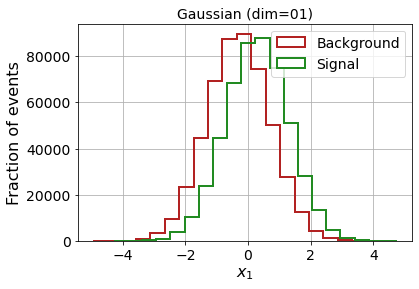

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.68528	validation_1-logloss:0.68529
[1]	validation_0-logloss:0.67894	validation_1-logloss:0.67896
[2]	validation_0-logloss:0.67374	validation_1-logloss:0.67376
[3]	validation_0-logloss:0.66954	validation_1-logloss:0.66956
[4]	validation_0-logloss:0.66605	validation_1-logloss:0.66609
[5]	validation_0-logloss:0.66325	validation_1-logloss:0.66329
[6]	validation_0-logloss:0.66083	validation_1-logloss:0.66088
[7]	validation_0-logloss:0.65894	validation_1-logloss:0.65901
[8]	validation_0-logloss:0.65735	validation_1-logloss:0.65743
[9]	validation_0-logloss:0.65611	validation_1-logloss:0.65620
[10]	validation_0-logloss:0.65498	validation_1-logloss:0.65510
[11]	validation_0-logloss:0.65410	validation_1-logloss:0.65423
[12]	validation_0-logloss:0.65338	validation_1-logloss:0.65352
[13]	validation_0-logloss:0.65276	validation_1-logloss:0.65292
[14]	validation_0-logloss:0.65231	validation_1-logloss:0.65249
[15]	validation_0-logloss:0.65191	validation_1-logloss:0.65210
[1

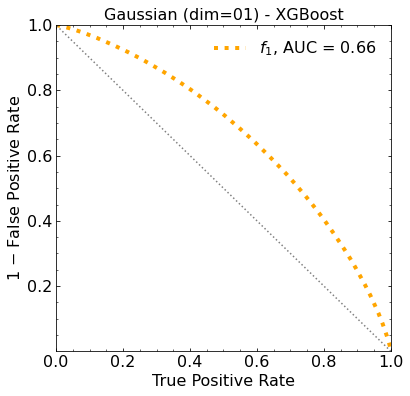

Classification score:


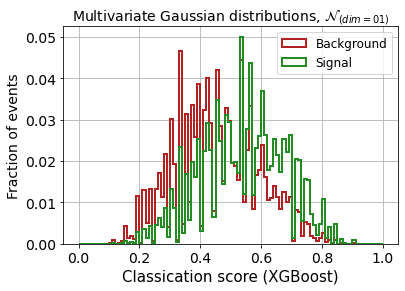

Classification score interpolation:


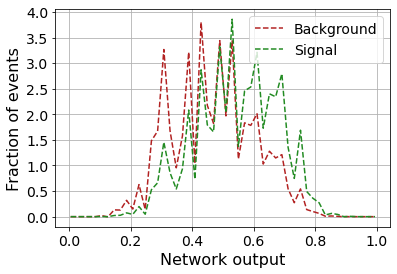


 ----------------------------------------- 

TRUE PDF LIKELIHOOD (GAUSSIANS):
B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  10000

 If  10100  =  1009    then the proposed range has to be extended
n_ensembles (actual):  9233
This may take long...


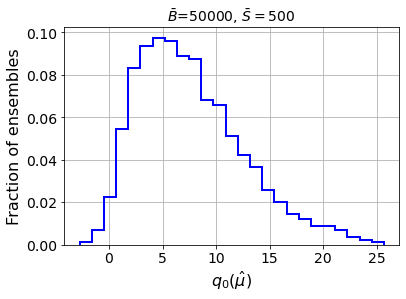

muhat mean:  1.0405826925159751
median q_muhat:  6.954510725330351
Z_gaussian:  2.6371406343481856

 ------------------------------------ 

MACHINE-LEARNED LIKELIHOOD
B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  10000

 If  10100  =  1009    then the proposed range has to be extended
n_ensembles (actual):  9233

 This may take long... 



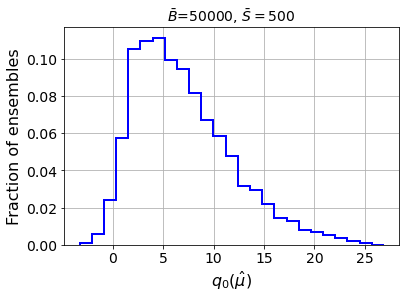

muhat mean:  0.9941622441243365
median q_muhat:  6.121419555014995
Z_XG:  2.474150269287416

 ----------------------------------------- 

Working points, counting over 1 bin:
S_expected =  500
WP: 0     S/B**0.5=  2.23606797749979
WP:  0.25     S/B**0.5=  2.267044600074433
WP:  0.5     S/B**0.5=  2.225532310946481
WP:  0.75     S/B**0.5=  1.0575716153065058
------------------------


In [79]:
dim=1

#######################
# generate the events #
#######################
    
background_X_1 = np.random.normal(-epsilon,1,N)
    
signal_X_1 = np.random.normal(epsilon,1,N)

dim1 = np.concatenate((background_X_1,signal_X_1))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1']].values 
Y_gauss = df[['Y']].values

X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss, Y_gauss, test_size=0.5)


print(X_gauss_train.shape)
print(Y_gauss_train.shape)
print(X_gauss_val.shape)
print(Y_gauss_val.shape)


# PLOT (only 1st feature) to visualize the data
X_gauss_val_SM = []
X_gauss_val_NP = []

for i in range(len(Y_gauss_val)):
    if Y_gauss_val[i] ==0:
        X_gauss_val_SM.append(X_gauss_val[i].tolist())
    else:
        X_gauss_val_NP.append(X_gauss_val[i].tolist())    


X_gauss_val_SM = np.array(X_gauss_val_SM)
X_gauss_val_NP = np.array(X_gauss_val_NP)


weights = np.ones_like(X_gauss_val_SM[:,0])/float(len(X_gauss_val_SM[:,0]))
plt.hist(X_gauss_val_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_val_NP[:,0])/float(len(X_gauss_val_NP[:,0]))
plt.hist(X_gauss_val_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  




#######################
# CLASSIFIER: XGBoost #
#######################

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_gauss_train,Y_gauss_train,eval_set=[(X_gauss_train, Y_gauss_train), (X_gauss_val, Y_gauss_val)],
        eval_metric='logloss',early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_gauss_val).T[1]


# ROC
fpr_gauss_xg, tpr_gauss_xg, _ = roc_curve(Y_gauss_val, y_pred_xg)
roc_auc_xg = auc(fpr_gauss_xg, tpr_gauss_xg)

store_AUC.append(roc_auc_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_gauss_xg,1-fpr_gauss_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.title(r"Gaussian (dim=%0.2d) - XGBoost" % dim,fontsize=16)
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_val)):
    if Y_gauss_val[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('Multivariate Gaussian distributions, $\mathcal{N}_{(dim=%0.2d)}$' % dim, fontsize=14)
plt.show()





# INTERPOLATE TO USE AS p_s(x) and p_b(x) ESTIMATES

# center of each bin

binsSM_mid = []
binsNP_mid = []

for i in range(len(binsSM)-1):
    binsSM_mid.append( ((binsSM[i+1]-binsSM[i])/2)+binsSM[i] )
    
for i in range(len(binsNP)-1):
    binsNP_mid.append( ((binsNP[i+1]-binsNP[i])/2)+binsNP[i] )
    

# get the width of each bin
bin_width_SM = binsSM[1] - binsSM[0]
bin_width_NP = binsNP[1] - binsNP[0]
   
    
# Interpolation, cubic
fcubic_XG_SM = interp1d(binsSM_mid, nSM, kind='cubic')
fcubic_XG_NP = interp1d(binsNP_mid, nNP, kind='cubic')


# Normalize

def fcubic_XG_SM_norm(x):
    return fcubic_XG_SM(x)/bin_width_SM

def fcubic_XG_NP_norm(x):
    return fcubic_XG_NP(x)/bin_width_NP


print('Classification score interpolation:')
# x to plot
xnew_XG_SM = np.linspace(min(binsSM_mid), max(binsSM_mid), num=50, endpoint=True)
xnew_XG_NP = np.linspace(min(binsNP_mid), max(binsNP_mid), num=50, endpoint=True)

plt.plot(xnew_XG_SM, fcubic_XG_SM_norm(xnew_XG_SM), '--', color='firebrick', label='Background')
plt.plot(xnew_XG_NP, fcubic_XG_NP_norm(xnew_XG_NP), '--', color='forestgreen', label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Network output",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.show()

print('\n ----------------------------------------- \n')





###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

print('TRUE PDF LIKELIHOOD (GAUSSIANS):')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print('S/$\sqrt{B}$: ', SsqrtB)
print('n_ensembles (initial): ', n_ensembles)


# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected


# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break


for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))



# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######



print('This may take long...')


#############################
# NOW LETS APPLY THE METHOD #
#############################
muhat_selected_list = []
q_muhat = []

for bb in range(len(list_nums_ensembles)):

    for kk in range(list_nums_ensembles[bb]):

        # SIGNAL events in an ensemble
        NP_shuf = shuffle(X_gauss_val_NP)[:list_S_per_ensembles[bb]]

        prob_NP_given_B = [] # p_b(S_ensemble)
        prob_NP_given_S = [] # p_s(S_ensemble)

        for ll in range(len(NP_shuf)):
            prob_NP_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]-epsilon)**2 ) ) )
            prob_NP_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]+epsilon)**2 ) ) )


        # BACKGROUND events in an ensemble
        SM_shuf = shuffle(X_gauss_val_SM)[:list_B_per_ensembles[bb]]

        prob_SM_given_B = [] # p_b(B_ensemble)
        prob_SM_given_S = [] # p_s(B_ensemble)

        for ll in range(len(SM_shuf)):
            prob_SM_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]-epsilon)**2 ) ) )
            prob_SM_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]+epsilon)**2 ) ) )


        # p_b(x_ensemble) =    concatenate: p_b(B_ensemble) and p_b(S_ensemble)
        prob_x_given_B = prob_SM_given_B + prob_NP_given_B

        # p_s(x_ensemble) =    concatenate: p_s(B_ensemble) and p_s(S_ensemble)
        prob_x_given_S = prob_SM_given_S + prob_NP_given_S




        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble



        mu_hat_condition_equal_1 = []

        # grid, mu_hat is around 1
        muhat_test = np.arange(0.5, 2, 0.1).tolist()

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



        muhat_selected = 1

        # from the grid, select the mu_hat such that the condition is equal to 1
        if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 > 0:
                    muhat_selected = muhat_test[ll]
                    break


        if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 < 0:
                    muhat_selected = muhat_test[ll]
                    break


        muhat_selected_list.append(muhat_selected)



        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
plt.show()


# Finally calculate muhat_mean and Z_gaussian
muhat_mean_gaussian = np.mean(muhat_selected_list)
store_muhat_mean_gaussian.append(muhat_mean_gaussian)

# Remove nan if any
q_muhat = [x for x in q_muhat if x == x]
    
q_muhat_median = np.median(q_muhat)

Z_gaussian = abs(q_muhat_median)**0.5
store_Z_gaussian.append(Z_gaussian)

print('muhat mean: ', muhat_mean_gaussian)
print('median q_muhat: ', q_muhat_median)
print('Z_gaussian: ', Z_gaussian)


print('\n ------------------------------------ \n')


    
    
    
##############################
# MACHINE-LEARNED LIKELIHOOD #
##############################

print('MACHINE-LEARNED LIKELIHOOD')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)
print('n_ensembles (initial): ', n_ensembles)


# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected


# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break


for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))



# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######



print('\n This may take long... \n')


# To avoid issues
for kkk in range(len(pred_XG_NP)):
    if pred_XG_NP[kkk] < min(binsNP_mid):
        pred_XG_NP[kkk] = min(binsNP_mid)
    elif pred_XG_NP[kkk] > max(binsNP_mid):
        pred_XG_NP[kkk] = max(binsNP_mid)        

for kkk in range(len(pred_XG_SM)):
    if pred_XG_SM[kkk] < min(binsSM_mid):
        pred_XG_SM[kkk] = min(binsSM_mid)
    elif pred_XG_SM[kkk] > max(binsSM_mid):
        pred_XG_SM[kkk] = max(binsSM_mid)


# NOW LETS APPLY THE METHOD

muhat_selected_list = []
q_muhat = []

for bb in range(len(list_nums_ensembles)):

    for kk in range(list_nums_ensembles[bb]):

        # SIGNAL: classification score for the SIGNAL events in an ensemble
        pred_NP_shuf = np.random.choice(pred_XG_NP, list_S_per_ensembles[bb])

        # BACKGROUND: classification score for the BACKGROUND events in an ensemble
        pred_SM_shuf = np.random.choice(pred_XG_SM, list_B_per_ensembles[bb])




        # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_B = np.ndarray.tolist( fcubic_XG_SM_norm( pred_SM_shuf ) ) + np.ndarray.tolist( fcubic_XG_SM_norm( pred_NP_shuf ) )

        # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_S = np.ndarray.tolist( fcubic_XG_NP_norm( pred_SM_shuf ) ) + np.ndarray.tolist( fcubic_XG_NP_norm( pred_NP_shuf ) )





        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble



        mu_hat_condition_equal_1 = []

        # grid, mu_hat is around 1
        muhat_test = np.arange(0.5, 2, 0.1).tolist()

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



        muhat_selected = 1

        # from the grid, select the mu_hat such that the condition is equal to 1
        if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 > 0:
                    muhat_selected = muhat_test[ll]
                    break


        if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 < 0:
                    muhat_selected = muhat_test[ll]
                    break


        muhat_selected_list.append(muhat_selected)



        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
plt.show()



# Finally calculate muhat_mean and Z_gaussian
muhat_mean_XG = np.mean(muhat_selected_list)
store_muhat_mean_XG_MLL.append(muhat_mean_XG)

# Remove nan if any
q_muhat = [x for x in q_muhat if x == x]
    
q_muhat_median = np.median(q_muhat)

Z_XG = abs(q_muhat_median)**0.5
store_Z_XG_MLL.append(Z_XG)

print('muhat mean: ', muhat_mean_XG)
print('median q_muhat: ', q_muhat_median)
print('Z_XG: ', Z_XG)


print('\n ----------------------------------------- \n')
    
    
    
    
    
    
#######################################
# Working points, counting over 1 bin #
#######################################

print('Working points, counting over 1 bin:')

# BACKGROUND 

# number of background ensembles
B_ensembles = int(len(pred_XG_SM)/B_expected)

# shorten the number of B events so I get an integer number of ensembles
pred_XG_SM_entero = pred_XG_SM[:int(len(pred_XG_SM)/B_expected) * B_expected]

XG_SM_passWP0 = 0
XG_SM_passWP1 = 0
XG_SM_passWP2 = 0

for i in range(len(pred_XG_SM_entero)):
    if pred_XG_SM_entero[i] > WP[0]:
        XG_SM_passWP0 += 1
    if pred_XG_SM_entero[i] > WP[1]:
        XG_SM_passWP1 += 1
    if pred_XG_SM_entero[i] > WP[2]:
        XG_SM_passWP2 += 1



# SIGNAL

# number of signal ensembles
S_ensembles = int(len(pred_XG_NP)/S_expected)

# shorten the number of S events so I get an integer number of ensembles
pred_XG_NP_entero = pred_XG_NP[:int(len(pred_XG_NP)/S_expected) * S_expected]

XG_NP_passWP0 = 0
XG_NP_passWP1 = 0
XG_NP_passWP2 = 0

for i in range(len(pred_XG_NP_entero)):
    if pred_XG_NP_entero[i] > WP[0]:
        XG_NP_passWP0 += 1
    if pred_XG_NP_entero[i] > WP[1]:
        XG_NP_passWP1 += 1
    if pred_XG_NP_entero[i] > WP[2]:
        XG_NP_passWP2 += 1

Z_WP0 = ( XG_NP_passWP0 / S_ensembles ) / ( XG_SM_passWP0 / B_ensembles )**0.5
Z_WP1 = ( XG_NP_passWP1 / S_ensembles ) / ( XG_SM_passWP1 / B_ensembles )**0.5
Z_WP2 = ( XG_NP_passWP2 / S_ensembles ) / ( XG_SM_passWP2 / B_ensembles )**0.5


# save the results Z_binned after WP
SrootB_WP0.append( Z_WP0 )
SrootB_WP1.append( Z_WP1 )
SrootB_WP2.append( Z_WP2 )

print('S_expected = ', S_expected)
print('WP: 0     S/B**0.5= ', S_expected/(B_expected)**0.5)
print('WP: ', WP[0], '    S/B**0.5= ', Z_WP0 )
print('WP: ', WP[1], '    S/B**0.5= ', Z_WP1 )
print('WP: ', WP[2], '    S/B**0.5= ', Z_WP2 )
print('------------------------')

In [80]:
print('dim = ', dim)

print(roc_auc_xg)

print(muhat_mean_gaussian)
print(Z_gaussian)

print(muhat_mean_XG)
print(Z_XG)

print(Z_WP0)
print(Z_WP1)
print(Z_WP2)

dim =  1
0.6638915006110954
1.0405826925159751
2.6371406343481856
0.9941622441243365
2.474150269287416
2.267044600074433
2.225532310946481
1.0575716153065058


In [ ]:
# To use if you dont want to run everything again. Store the previous results
store_AUC.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()

store_muhat_mean_XG_MLL.append()
store_Z_XG_MLL.append()

SrootB_WP0.append()
SrootB_WP1.append()
SrootB_WP2.append()

## Dim=2

(1000000, 2)
(1000000, 1)
(1000000, 2)
(1000000, 1)


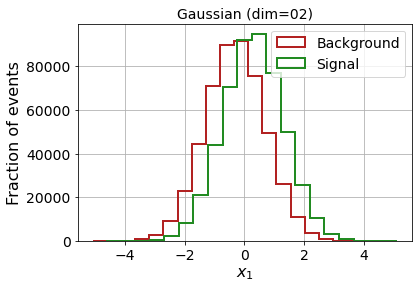

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67913	validation_1-logloss:0.67922
[1]	validation_0-logloss:0.66758	validation_1-logloss:0.66775
[2]	validation_0-logloss:0.65811	validation_1-logloss:0.65834
[3]	validation_0-logloss:0.65020	validation_1-logloss:0.65048
[4]	validation_0-logloss:0.64365	validation_1-logloss:0.64399
[5]	validation_0-logloss:0.63814	validation_1-logloss:0.63852
[6]	validation_0-logloss:0.63360	validation_1-logloss:0.63404
[7]	validation_0-logloss:0.62977	validation_1-logloss:0.63026
[8]	validation_0-logloss:0.62657	validation_1-logloss:0.62710
[9]	validation_0-logloss:0.62389	validation_1-logloss:0.62446
[10]	validation_0-logloss:0.62163	validation_1-logloss:0.62224
[11]	validation_0-logloss:0.61973	validation_1-logloss:0.62038
[12]	validation_0-logloss:0.61814	validation_1-logloss:0.61881
[13]	validation_0-logloss:0.61679	validation_1-logloss:0.61748
[14]	validation_0-logloss:0.61567	validation_1-logloss:0.61640
[15]	validation_0-logloss:0.61472	validation_1-logloss:0.61547
[1

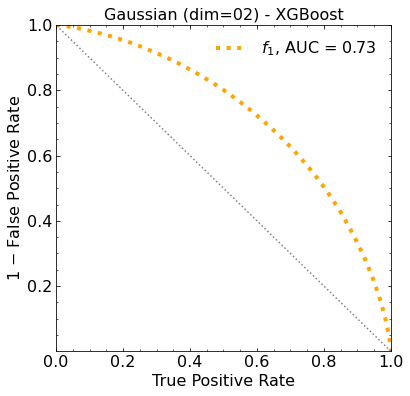

Classification score:


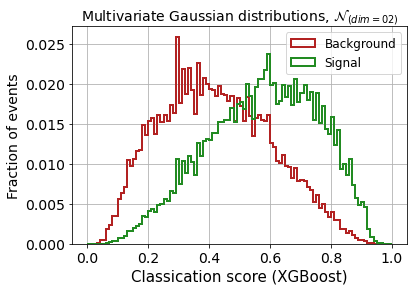

Classification score interpolation:


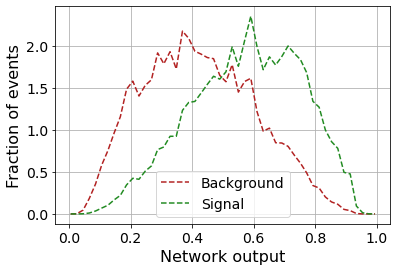


 ----------------------------------------- 

TRUE PDF LIKELIHOOD (GAUSSIANS):
B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  10000

 If  10100  =  1009    then the proposed range has to be extended
n_ensembles (actual):  9233
This may take long...


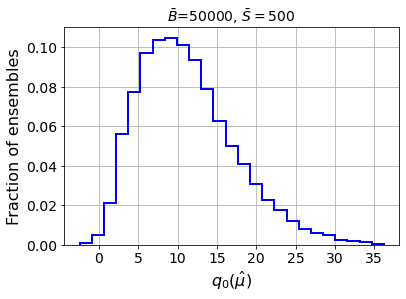

muhat mean:  1.0691107982237624
median q_muhat:  10.360368513887579
Z_gaussian:  3.218752633224178

 ------------------------------------ 

MACHINE-LEARNED LIKELIHOOD
B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  10000

 If  10100  =  1009    then the proposed range has to be extended
n_ensembles (actual):  9233

 This may take long... 



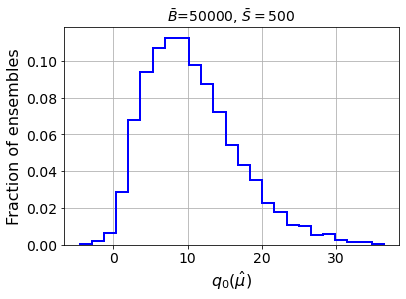

muhat mean:  1.0375392613451748
median q_muhat:  9.807839458738727
Z_XG:  3.13174702981239

 ----------------------------------------- 

Working points, counting over 1 bin:
S_expected =  500
WP: 0     S/B**0.5=  2.23606797749979
WP:  0.25     S/B**0.5=  2.3796724420276565
WP:  0.5     S/B**0.5=  2.560015384615385
WP:  0.75     S/B**0.5=  2.0630879237466377
------------------------


In [12]:
dim=2

#######################
# generate the events #
#######################
    
background_X_1 = np.random.normal(-epsilon,1,N)
background_X_2 = np.random.normal(-epsilon,1,N)
    
signal_X_1 = np.random.normal(epsilon,1,N)
signal_X_2 = np.random.normal(epsilon,1,N)

dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2']].values 
Y_gauss = df[['Y']].values

X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss, Y_gauss, test_size=0.5)


print(X_gauss_train.shape)
print(Y_gauss_train.shape)
print(X_gauss_val.shape)
print(Y_gauss_val.shape)


# PLOT (only 1st feature) to visualize the data
X_gauss_val_SM = []
X_gauss_val_NP = []

for i in range(len(Y_gauss_val)):
    if Y_gauss_val[i] ==0:
        X_gauss_val_SM.append(X_gauss_val[i].tolist())
    else:
        X_gauss_val_NP.append(X_gauss_val[i].tolist())    


X_gauss_val_SM = np.array(X_gauss_val_SM)
X_gauss_val_NP = np.array(X_gauss_val_NP)


weights = np.ones_like(X_gauss_val_SM[:,0])/float(len(X_gauss_val_SM[:,0]))
plt.hist(X_gauss_val_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_val_NP[:,0])/float(len(X_gauss_val_NP[:,0]))
plt.hist(X_gauss_val_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  




#######################
# CLASSIFIER: XGBoost #
#######################

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_gauss_train,Y_gauss_train,eval_set=[(X_gauss_train, Y_gauss_train), (X_gauss_val, Y_gauss_val)],
        eval_metric='logloss',early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_gauss_val).T[1]


# ROC
fpr_gauss_xg, tpr_gauss_xg, _ = roc_curve(Y_gauss_val, y_pred_xg)
roc_auc_xg = auc(fpr_gauss_xg, tpr_gauss_xg)

store_AUC.append(roc_auc_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_gauss_xg,1-fpr_gauss_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.title(r"Gaussian (dim=%0.2d) - XGBoost" % dim,fontsize=16)
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_val)):
    if Y_gauss_val[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('Multivariate Gaussian distributions, $\mathcal{N}_{(dim=%0.2d)}$' % dim, fontsize=14)
plt.show()





# INTERPOLATE TO USE AS p_s(x) and p_b(x) ESTIMATES

# center of each bin

binsSM_mid = []
binsNP_mid = []

for i in range(len(binsSM)-1):
    binsSM_mid.append( ((binsSM[i+1]-binsSM[i])/2)+binsSM[i] )
    
for i in range(len(binsNP)-1):
    binsNP_mid.append( ((binsNP[i+1]-binsNP[i])/2)+binsNP[i] )
    

# get the width of each bin
bin_width_SM = binsSM[1] - binsSM[0]
bin_width_NP = binsNP[1] - binsNP[0]
   
    
# Interpolation, cubic
fcubic_XG_SM = interp1d(binsSM_mid, nSM, kind='cubic')
fcubic_XG_NP = interp1d(binsNP_mid, nNP, kind='cubic')


# Normalize

def fcubic_XG_SM_norm(x):
    return fcubic_XG_SM(x)/bin_width_SM

def fcubic_XG_NP_norm(x):
    return fcubic_XG_NP(x)/bin_width_NP


print('Classification score interpolation:')
# x to plot
xnew_XG_SM = np.linspace(min(binsSM_mid), max(binsSM_mid), num=50, endpoint=True)
xnew_XG_NP = np.linspace(min(binsNP_mid), max(binsNP_mid), num=50, endpoint=True)

plt.plot(xnew_XG_SM, fcubic_XG_SM_norm(xnew_XG_SM), '--', color='firebrick', label='Background')
plt.plot(xnew_XG_NP, fcubic_XG_NP_norm(xnew_XG_NP), '--', color='forestgreen', label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Network output",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.show()

print('\n ----------------------------------------- \n')





###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

print('TRUE PDF LIKELIHOOD (GAUSSIANS):')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print('S/$\sqrt{B}$: ', SsqrtB)
print('n_ensembles (initial): ', n_ensembles)


# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected


# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break


for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))



# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######



print('This may take long...')


#############################
# NOW LETS APPLY THE METHOD #
#############################
muhat_selected_list = []
q_muhat = []

for bb in range(len(list_nums_ensembles)):

    for kk in range(list_nums_ensembles[bb]):

        # SIGNAL events in an ensemble
        NP_shuf = shuffle(X_gauss_val_NP)[:list_S_per_ensembles[bb]]

        prob_NP_given_B = [] # p_b(S_ensemble)
        prob_NP_given_S = [] # p_s(S_ensemble)

        for ll in range(len(NP_shuf)):
            prob_NP_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]-epsilon)**2 + (NP_shuf[ll,1]-epsilon)**2 ) ) )
            prob_NP_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]+epsilon)**2 + (NP_shuf[ll,1]+epsilon)**2 ) ) )


        # BACKGROUND events in an ensemble
        SM_shuf = shuffle(X_gauss_val_SM)[:list_B_per_ensembles[bb]]

        prob_SM_given_B = [] # p_b(B_ensemble)
        prob_SM_given_S = [] # p_s(B_ensemble)

        for ll in range(len(SM_shuf)):
            prob_SM_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]-epsilon)**2 + (SM_shuf[ll,1]-epsilon)**2 ) ) )
            prob_SM_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]+epsilon)**2 + (SM_shuf[ll,1]+epsilon)**2 ) ) )


        # p_b(x_ensemble) =    concatenate: p_b(B_ensemble) and p_b(S_ensemble)
        prob_x_given_B = prob_SM_given_B + prob_NP_given_B

        # p_s(x_ensemble) =    concatenate: p_s(B_ensemble) and p_s(S_ensemble)
        prob_x_given_S = prob_SM_given_S + prob_NP_given_S




        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble



        mu_hat_condition_equal_1 = []

        # grid, mu_hat is around 1
        muhat_test = np.arange(0.5, 2, 0.1).tolist()

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



        muhat_selected = 1

        # from the grid, select the mu_hat such that the condition is equal to 1
        if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 > 0:
                    muhat_selected = muhat_test[ll]
                    break


        if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 < 0:
                    muhat_selected = muhat_test[ll]
                    break


        muhat_selected_list.append(muhat_selected)



        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
plt.show()


# Finally calculate muhat_mean and Z_gaussian
muhat_mean_gaussian = np.mean(muhat_selected_list)
store_muhat_mean_gaussian.append(muhat_mean_gaussian)

# Remove nan if any
q_muhat = [x for x in q_muhat if x == x]

q_muhat_median = np.median(q_muhat)

Z_gaussian = abs(q_muhat_median)**0.5
store_Z_gaussian.append(Z_gaussian)

print('muhat mean: ', muhat_mean_gaussian)
print('median q_muhat: ', q_muhat_median)
print('Z_gaussian: ', Z_gaussian)


print('\n ------------------------------------ \n')


    
    
    
##############################
# MACHINE-LEARNED LIKELIHOOD #
##############################

print('MACHINE-LEARNED LIKELIHOOD')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)
print('n_ensembles (initial): ', n_ensembles)


# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected


# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break


for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))



# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######



print('\n This may take long... \n')


# To avoid issues
for kkk in range(len(pred_XG_NP)):
    if pred_XG_NP[kkk] < min(binsNP_mid):
        pred_XG_NP[kkk] = min(binsNP_mid)
    elif pred_XG_NP[kkk] > max(binsNP_mid):
        pred_XG_NP[kkk] = max(binsNP_mid)        

for kkk in range(len(pred_XG_SM)):
    if pred_XG_SM[kkk] < min(binsSM_mid):
        pred_XG_SM[kkk] = min(binsSM_mid)
    elif pred_XG_SM[kkk] > max(binsSM_mid):
        pred_XG_SM[kkk] = max(binsSM_mid)
        
        

# NOW LETS APPLY THE METHOD

muhat_selected_list = []
q_muhat = []

for bb in range(len(list_nums_ensembles)):

    for kk in range(list_nums_ensembles[bb]):

        # SIGNAL: classification score for the SIGNAL events in an ensemble
        pred_NP_shuf = np.random.choice(pred_XG_NP, list_S_per_ensembles[bb])

        # BACKGROUND: classification score for the BACKGROUND events in an ensemble
        pred_SM_shuf = np.random.choice(pred_XG_SM, list_B_per_ensembles[bb])




        # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_B = np.ndarray.tolist( fcubic_XG_SM_norm( pred_SM_shuf ) ) + np.ndarray.tolist( fcubic_XG_SM_norm( pred_NP_shuf ) )

        # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_S = np.ndarray.tolist( fcubic_XG_NP_norm( pred_SM_shuf ) ) + np.ndarray.tolist( fcubic_XG_NP_norm( pred_NP_shuf ) )





        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble



        mu_hat_condition_equal_1 = []

        # grid, mu_hat is around 1
        muhat_test = np.arange(0.5, 2, 0.1).tolist()

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



        muhat_selected = 1

        # from the grid, select the mu_hat such that the condition is equal to 1
        if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 > 0:
                    muhat_selected = muhat_test[ll]
                    break


        if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 < 0:
                    muhat_selected = muhat_test[ll]
                    break


        muhat_selected_list.append(muhat_selected)



        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
plt.show()



# Finally calculate muhat_mean and Z_gaussian
muhat_mean_XG = np.mean(muhat_selected_list)
store_muhat_mean_XG_MLL.append(muhat_mean_XG)

# Remove nan if any
q_muhat = [x for x in q_muhat if x == x]

q_muhat_median = np.median(q_muhat)

Z_XG = abs(q_muhat_median)**0.5
store_Z_XG_MLL.append(Z_XG)

print('muhat mean: ', muhat_mean_XG)
print('median q_muhat: ', q_muhat_median)
print('Z_XG: ', Z_XG)


print('\n ----------------------------------------- \n')
    
    
    
    
    
    
#######################################
# Working points, counting over 1 bin #
#######################################

print('Working points, counting over 1 bin:')

# BACKGROUND 

# number of background ensembles
B_ensembles = int(len(pred_XG_SM)/B_expected)

# shorten the number of B events so I get an integer number of ensembles
pred_XG_SM_entero = pred_XG_SM[:int(len(pred_XG_SM)/B_expected) * B_expected]

XG_SM_passWP0 = 0
XG_SM_passWP1 = 0
XG_SM_passWP2 = 0

for i in range(len(pred_XG_SM_entero)):
    if pred_XG_SM_entero[i] > WP[0]:
        XG_SM_passWP0 += 1
    if pred_XG_SM_entero[i] > WP[1]:
        XG_SM_passWP1 += 1
    if pred_XG_SM_entero[i] > WP[2]:
        XG_SM_passWP2 += 1



# SIGNAL

# number of signal ensembles
S_ensembles = int(len(pred_XG_NP)/S_expected)

# shorten the number of S events so I get an integer number of ensembles
pred_XG_NP_entero = pred_XG_NP[:int(len(pred_XG_NP)/S_expected) * S_expected]

XG_NP_passWP0 = 0
XG_NP_passWP1 = 0
XG_NP_passWP2 = 0

for i in range(len(pred_XG_NP_entero)):
    if pred_XG_NP_entero[i] > WP[0]:
        XG_NP_passWP0 += 1
    if pred_XG_NP_entero[i] > WP[1]:
        XG_NP_passWP1 += 1
    if pred_XG_NP_entero[i] > WP[2]:
        XG_NP_passWP2 += 1

Z_WP0 = ( XG_NP_passWP0 / S_ensembles ) / ( XG_SM_passWP0 / B_ensembles )**0.5
Z_WP1 = ( XG_NP_passWP1 / S_ensembles ) / ( XG_SM_passWP1 / B_ensembles )**0.5
Z_WP2 = ( XG_NP_passWP2 / S_ensembles ) / ( XG_SM_passWP2 / B_ensembles )**0.5


# save the results Z_binned after WP
SrootB_WP0.append( Z_WP0 )
SrootB_WP1.append( Z_WP1 )
SrootB_WP2.append( Z_WP2 )

print('S_expected = ', S_expected)
print('WP: 0     S/B**0.5= ', S_expected/(B_expected)**0.5)
print('WP: ', WP[0], '    S/B**0.5= ', Z_WP0 )
print('WP: ', WP[1], '    S/B**0.5= ', Z_WP1 )
print('WP: ', WP[2], '    S/B**0.5= ', Z_WP2 )
print('------------------------')

In [13]:
print('dim = ', dim)

print(roc_auc_xg)

print(muhat_mean_gaussian)
print(Z_gaussian)

print(muhat_mean_XG)
print(Z_XG)

print(Z_WP0)
print(Z_WP1)
print(Z_WP2)

dim =  2
0.725416446010977
1.0691107982237624
3.218752633224178
1.0375392613451748
3.13174702981239
2.3796724420276565
2.560015384615385
2.0630879237466377


In [ ]:
# To use if you dont want to run everything again. Store the previous results
store_AUC.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()

store_muhat_mean_XG_MLL.append()
store_Z_XG_MLL.append()

SrootB_WP0.append()
SrootB_WP1.append()
SrootB_WP2.append()

## Dim=3

(1000000, 3)
(1000000, 1)
(1000000, 3)
(1000000, 1)


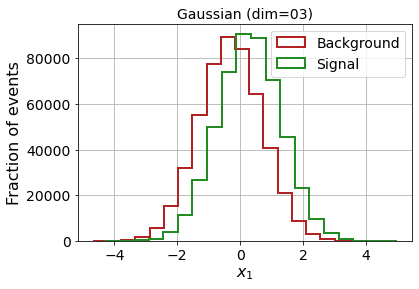

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67567	validation_1-logloss:0.67569
[1]	validation_0-logloss:0.66105	validation_1-logloss:0.66112
[2]	validation_0-logloss:0.64881	validation_1-logloss:0.64891
[3]	validation_0-logloss:0.63847	validation_1-logloss:0.63859
[4]	validation_0-logloss:0.62967	validation_1-logloss:0.62983
[5]	validation_0-logloss:0.62217	validation_1-logloss:0.62239
[6]	validation_0-logloss:0.61578	validation_1-logloss:0.61604
[7]	validation_0-logloss:0.61033	validation_1-logloss:0.61059
[8]	validation_0-logloss:0.60560	validation_1-logloss:0.60591
[9]	validation_0-logloss:0.60152	validation_1-logloss:0.60188
[10]	validation_0-logloss:0.59797	validation_1-logloss:0.59836
[11]	validation_0-logloss:0.59489	validation_1-logloss:0.59531
[12]	validation_0-logloss:0.59221	validation_1-logloss:0.59267
[13]	validation_0-logloss:0.58989	validation_1-logloss:0.59037
[14]	validation_0-logloss:0.58786	validation_1-logloss:0.58838
[15]	validation_0-logloss:0.58607	validation_1-logloss:0.58662
[1

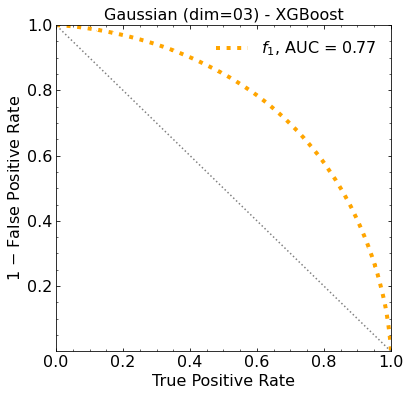

Classification score:


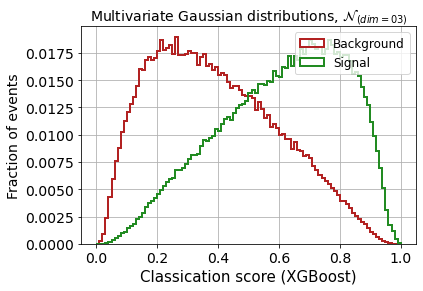

Classification score interpolation:


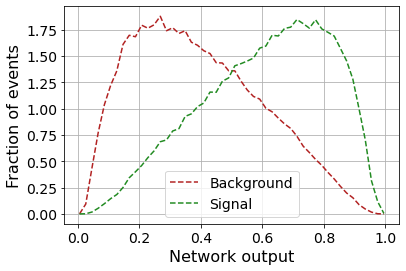


 ----------------------------------------- 

TRUE PDF LIKELIHOOD (GAUSSIANS):
B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  10000

 If  10100  =  1009    then the proposed range has to be extended
n_ensembles (actual):  9233
This may take long...


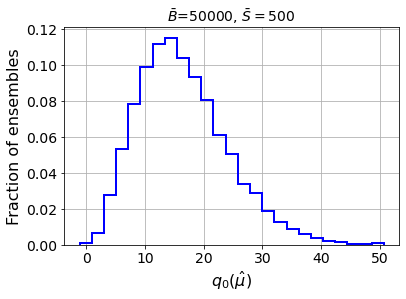

muhat mean:  1.0953536228744718
median q_muhat:  15.607412083052395
Z_gaussian:  3.9506217337341214

 ------------------------------------ 

MACHINE-LEARNED LIKELIHOOD
B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  10000

 If  10100  =  1009    then the proposed range has to be extended
n_ensembles (actual):  9233

 This may take long... 



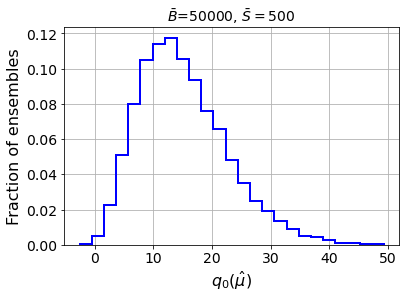

muhat mean:  1.0485757608577928
median q_muhat:  14.092263921146127
Z_XG:  3.753966425149022

 ----------------------------------------- 

Working points, counting over 1 bin:
S_expected =  500
WP: 0     S/B**0.5=  2.23606797749979
WP:  0.25     S/B**0.5=  2.508664062521924
WP:  0.5     S/B**0.5=  2.8444554292488755
WP:  0.75     S/B**0.5=  2.7485853598268957
------------------------


In [71]:
dim=3

#######################
# generate the events #
#######################
    
background_X_1 = np.random.normal(-epsilon,1,N)
background_X_2 = np.random.normal(-epsilon,1,N)
background_X_3 = np.random.normal(-epsilon,1,N)
    
signal_X_1 = np.random.normal(epsilon,1,N)
signal_X_2 = np.random.normal(epsilon,1,N)
signal_X_3 = np.random.normal(epsilon,1,N)

dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2','dim3']].values 
Y_gauss = df[['Y']].values

X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss, Y_gauss, test_size=0.5)


print(X_gauss_train.shape)
print(Y_gauss_train.shape)
print(X_gauss_val.shape)
print(Y_gauss_val.shape)


# PLOT (only 1st feature) to visualize the data
X_gauss_val_SM = []
X_gauss_val_NP = []

for i in range(len(Y_gauss_val)):
    if Y_gauss_val[i] ==0:
        X_gauss_val_SM.append(X_gauss_val[i].tolist())
    else:
        X_gauss_val_NP.append(X_gauss_val[i].tolist())    


X_gauss_val_SM = np.array(X_gauss_val_SM)
X_gauss_val_NP = np.array(X_gauss_val_NP)


weights = np.ones_like(X_gauss_val_SM[:,0])/float(len(X_gauss_val_SM[:,0]))
plt.hist(X_gauss_val_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_val_NP[:,0])/float(len(X_gauss_val_NP[:,0]))
plt.hist(X_gauss_val_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  




#######################
# CLASSIFIER: XGBoost #
#######################

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_gauss_train,Y_gauss_train,eval_set=[(X_gauss_train, Y_gauss_train), (X_gauss_val, Y_gauss_val)],
        eval_metric='logloss',early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_gauss_val).T[1]


# ROC
fpr_gauss_xg, tpr_gauss_xg, _ = roc_curve(Y_gauss_val, y_pred_xg)
roc_auc_xg = auc(fpr_gauss_xg, tpr_gauss_xg)

store_AUC.append(roc_auc_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_gauss_xg,1-fpr_gauss_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.title(r"Gaussian (dim=%0.2d) - XGBoost" % dim,fontsize=16)
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_val)):
    if Y_gauss_val[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('Multivariate Gaussian distributions, $\mathcal{N}_{(dim=%0.2d)}$' % dim, fontsize=14)
plt.show()





# INTERPOLATE TO USE AS p_s(x) and p_b(x) ESTIMATES

# center of each bin

binsSM_mid = []
binsNP_mid = []

for i in range(len(binsSM)-1):
    binsSM_mid.append( ((binsSM[i+1]-binsSM[i])/2)+binsSM[i] )
    
for i in range(len(binsNP)-1):
    binsNP_mid.append( ((binsNP[i+1]-binsNP[i])/2)+binsNP[i] )
    

# get the width of each bin
bin_width_SM = binsSM[1] - binsSM[0]
bin_width_NP = binsNP[1] - binsNP[0]
   
    
# Interpolation, cubic
fcubic_XG_SM = interp1d(binsSM_mid, nSM, kind='cubic')
fcubic_XG_NP = interp1d(binsNP_mid, nNP, kind='cubic')


# Normalize

def fcubic_XG_SM_norm(x):
    return fcubic_XG_SM(x)/bin_width_SM

def fcubic_XG_NP_norm(x):
    return fcubic_XG_NP(x)/bin_width_NP


print('Classification score interpolation:')
# x to plot
xnew_XG_SM = np.linspace(min(binsSM_mid), max(binsSM_mid), num=50, endpoint=True)
xnew_XG_NP = np.linspace(min(binsNP_mid), max(binsNP_mid), num=50, endpoint=True)

plt.plot(xnew_XG_SM, fcubic_XG_SM_norm(xnew_XG_SM), '--', color='firebrick', label='Background')
plt.plot(xnew_XG_NP, fcubic_XG_NP_norm(xnew_XG_NP), '--', color='forestgreen', label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Network output",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.show()

print('\n ----------------------------------------- \n')





###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

print('TRUE PDF LIKELIHOOD (GAUSSIANS):')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print('S/$\sqrt{B}$: ', SsqrtB)
print('n_ensembles (initial): ', n_ensembles)


# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected


# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break


for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))



# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######



print('This may take long...')


#############################
# NOW LETS APPLY THE METHOD #
#############################
muhat_selected_list = []
q_muhat = []

for bb in range(len(list_nums_ensembles)):

    for kk in range(list_nums_ensembles[bb]):

        # SIGNAL events in an ensemble
        NP_shuf = shuffle(X_gauss_val_NP)[:list_S_per_ensembles[bb]]

        prob_NP_given_B = [] # p_b(S_ensemble)
        prob_NP_given_S = [] # p_s(S_ensemble)

        for ll in range(len(NP_shuf)):
            prob_NP_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]-epsilon)**2 + (NP_shuf[ll,1]-epsilon)**2 + (NP_shuf[ll,2]-epsilon)**2 ) ) )
            prob_NP_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]+epsilon)**2 + (NP_shuf[ll,1]+epsilon)**2 + (NP_shuf[ll,2]+epsilon)**2 ) ) )


        # BACKGROUND events in an ensemble
        SM_shuf = shuffle(X_gauss_val_SM)[:list_B_per_ensembles[bb]]

        prob_SM_given_B = [] # p_b(B_ensemble)
        prob_SM_given_S = [] # p_s(B_ensemble)

        for ll in range(len(SM_shuf)):
            prob_SM_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]-epsilon)**2 + (SM_shuf[ll,1]-epsilon)**2 + (SM_shuf[ll,2]-epsilon)**2 ) ) )
            prob_SM_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]+epsilon)**2 + (SM_shuf[ll,1]+epsilon)**2 + (SM_shuf[ll,2]+epsilon)**2 ) ) )


        # p_b(x_ensemble) =    concatenate: p_b(B_ensemble) and p_b(S_ensemble)
        prob_x_given_B = prob_SM_given_B + prob_NP_given_B

        # p_s(x_ensemble) =    concatenate: p_s(B_ensemble) and p_s(S_ensemble)
        prob_x_given_S = prob_SM_given_S + prob_NP_given_S




        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble



        mu_hat_condition_equal_1 = []

        # grid, mu_hat is around 1
        muhat_test = np.arange(0.5, 2, 0.1).tolist()

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



        muhat_selected = 1

        # from the grid, select the mu_hat such that the condition is equal to 1
        if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 > 0:
                    muhat_selected = muhat_test[ll]
                    break


        if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 < 0:
                    muhat_selected = muhat_test[ll]
                    break


        muhat_selected_list.append(muhat_selected)



        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
plt.show()


# Finally calculate muhat_mean and Z_gaussian
muhat_mean_gaussian = np.mean(muhat_selected_list)
store_muhat_mean_gaussian.append(muhat_mean_gaussian)

# Remove nan if any
q_muhat = [x for x in q_muhat if x == x]

q_muhat_median = np.median(q_muhat)

Z_gaussian = abs(q_muhat_median)**0.5
store_Z_gaussian.append(Z_gaussian)

print('muhat mean: ', muhat_mean_gaussian)
print('median q_muhat: ', q_muhat_median)
print('Z_gaussian: ', Z_gaussian)


print('\n ------------------------------------ \n')


    
    
    
##############################
# MACHINE-LEARNED LIKELIHOOD #
##############################

print('MACHINE-LEARNED LIKELIHOOD')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)
print('n_ensembles (initial): ', n_ensembles)


# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected


# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break


for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))



# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######



print('\n This may take long... \n')



# To avoid issues
for kkk in range(len(pred_XG_NP)):
    if pred_XG_NP[kkk] < min(binsNP_mid):
        pred_XG_NP[kkk] = min(binsNP_mid)
    elif pred_XG_NP[kkk] > max(binsNP_mid):
        pred_XG_NP[kkk] = max(binsNP_mid)        

for kkk in range(len(pred_XG_SM)):
    if pred_XG_SM[kkk] < min(binsSM_mid):
        pred_XG_SM[kkk] = min(binsSM_mid)
    elif pred_XG_SM[kkk] > max(binsSM_mid):
        pred_XG_SM[kkk] = max(binsSM_mid)
        
        

# NOW LETS APPLY THE METHOD

muhat_selected_list = []
q_muhat = []

for bb in range(len(list_nums_ensembles)):

    for kk in range(list_nums_ensembles[bb]):

        # SIGNAL: classification score for the SIGNAL events in an ensemble
        pred_NP_shuf = np.random.choice(pred_XG_NP, list_S_per_ensembles[bb])

        # BACKGROUND: classification score for the BACKGROUND events in an ensemble
        pred_SM_shuf = np.random.choice(pred_XG_SM, list_B_per_ensembles[bb])



        # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_B = np.ndarray.tolist( fcubic_XG_SM_norm( pred_SM_shuf ) ) + np.ndarray.tolist( fcubic_XG_SM_norm( pred_NP_shuf ) )

        # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_S = np.ndarray.tolist( fcubic_XG_NP_norm( pred_SM_shuf ) ) + np.ndarray.tolist( fcubic_XG_NP_norm( pred_NP_shuf ) )





        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble



        mu_hat_condition_equal_1 = []

        # grid, mu_hat is around 1
        muhat_test = np.arange(0.5, 2, 0.1).tolist()

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



        muhat_selected = 1

        # from the grid, select the mu_hat such that the condition is equal to 1
        if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 > 0:
                    muhat_selected = muhat_test[ll]
                    break


        if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 < 0:
                    muhat_selected = muhat_test[ll]
                    break


        muhat_selected_list.append(muhat_selected)



        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
plt.show()



# Finally calculate muhat_mean and Z_gaussian
muhat_mean_XG = np.mean(muhat_selected_list)
store_muhat_mean_XG_MLL.append(muhat_mean_XG)

# Remove nan if any
q_muhat = [x for x in q_muhat if x == x]

q_muhat_median = np.median(q_muhat)

Z_XG = abs(q_muhat_median)**0.5
store_Z_XG_MLL.append(Z_XG)

print('muhat mean: ', muhat_mean_XG)
print('median q_muhat: ', q_muhat_median)
print('Z_XG: ', Z_XG)


print('\n ----------------------------------------- \n')
    
    
    
    
    
    
#######################################
# Working points, counting over 1 bin #
#######################################

print('Working points, counting over 1 bin:')

# BACKGROUND 

# number of background ensembles
B_ensembles = int(len(pred_XG_SM)/B_expected)

# shorten the number of B events so I get an integer number of ensembles
pred_XG_SM_entero = pred_XG_SM[:int(len(pred_XG_SM)/B_expected) * B_expected]

XG_SM_passWP0 = 0
XG_SM_passWP1 = 0
XG_SM_passWP2 = 0

for i in range(len(pred_XG_SM_entero)):
    if pred_XG_SM_entero[i] > WP[0]:
        XG_SM_passWP0 += 1
    if pred_XG_SM_entero[i] > WP[1]:
        XG_SM_passWP1 += 1
    if pred_XG_SM_entero[i] > WP[2]:
        XG_SM_passWP2 += 1



# SIGNAL

# number of signal ensembles
S_ensembles = int(len(pred_XG_NP)/S_expected)

# shorten the number of S events so I get an integer number of ensembles
pred_XG_NP_entero = pred_XG_NP[:int(len(pred_XG_NP)/S_expected) * S_expected]

XG_NP_passWP0 = 0
XG_NP_passWP1 = 0
XG_NP_passWP2 = 0

for i in range(len(pred_XG_NP_entero)):
    if pred_XG_NP_entero[i] > WP[0]:
        XG_NP_passWP0 += 1
    if pred_XG_NP_entero[i] > WP[1]:
        XG_NP_passWP1 += 1
    if pred_XG_NP_entero[i] > WP[2]:
        XG_NP_passWP2 += 1

Z_WP0 = ( XG_NP_passWP0 / S_ensembles ) / ( XG_SM_passWP0 / B_ensembles )**0.5
Z_WP1 = ( XG_NP_passWP1 / S_ensembles ) / ( XG_SM_passWP1 / B_ensembles )**0.5
Z_WP2 = ( XG_NP_passWP2 / S_ensembles ) / ( XG_SM_passWP2 / B_ensembles )**0.5


# save the results Z_binned after WP
SrootB_WP0.append( Z_WP0 )
SrootB_WP1.append( Z_WP1 )
SrootB_WP2.append( Z_WP2 )

print('S_expected = ', S_expected)
print('WP: 0     S/B**0.5= ', S_expected/(B_expected)**0.5)
print('WP: ', WP[0], '    S/B**0.5= ', Z_WP0 )
print('WP: ', WP[1], '    S/B**0.5= ', Z_WP1 )
print('WP: ', WP[2], '    S/B**0.5= ', Z_WP2 )
print('------------------------')

In [72]:
print('dim = ', dim)

print(roc_auc_xg)

print(muhat_mean_gaussian)
print(Z_gaussian)

print(muhat_mean_XG)
print(Z_XG)

print(Z_WP0)
print(Z_WP1)
print(Z_WP2)

dim =  3
0.7684496798444643
1.0953536228744718
3.9506217337341214
1.0485757608577928
3.753966425149022
2.508664062521924
2.8444554292488755
2.7485853598268957


In [ ]:
# To use if you dont want to run everything again. Store the previous results
store_AUC.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()

store_muhat_mean_XG_MLL.append()
store_Z_XG_MLL.append()

SrootB_WP0.append()
SrootB_WP1.append()
SrootB_WP2.append()

## Dim=4

(1000000, 4)
(1000000, 1)
(1000000, 4)
(1000000, 1)


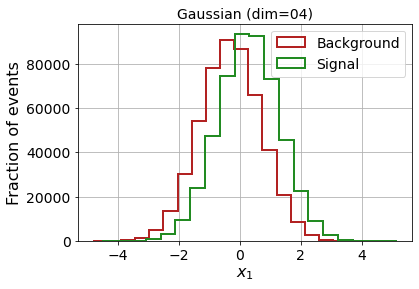

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67309	validation_1-logloss:0.67316
[1]	validation_0-logloss:0.65630	validation_1-logloss:0.65639
[2]	validation_0-logloss:0.64225	validation_1-logloss:0.64236
[3]	validation_0-logloss:0.63020	validation_1-logloss:0.63038
[4]	validation_0-logloss:0.61978	validation_1-logloss:0.62001
[5]	validation_0-logloss:0.61084	validation_1-logloss:0.61112
[6]	validation_0-logloss:0.60305	validation_1-logloss:0.60339
[7]	validation_0-logloss:0.59625	validation_1-logloss:0.59660
[8]	validation_0-logloss:0.59029	validation_1-logloss:0.59068
[9]	validation_0-logloss:0.58506	validation_1-logloss:0.58550
[10]	validation_0-logloss:0.58038	validation_1-logloss:0.58086
[11]	validation_0-logloss:0.57626	validation_1-logloss:0.57677
[12]	validation_0-logloss:0.57254	validation_1-logloss:0.57309
[13]	validation_0-logloss:0.56928	validation_1-logloss:0.56985
[14]	validation_0-logloss:0.56634	validation_1-logloss:0.56694
[15]	validation_0-logloss:0.56371	validation_1-logloss:0.56433
[1

[130]	validation_0-logloss:0.53738	validation_1-logloss:0.53992
[131]	validation_0-logloss:0.53737	validation_1-logloss:0.53992
[132]	validation_0-logloss:0.53736	validation_1-logloss:0.53992
[133]	validation_0-logloss:0.53735	validation_1-logloss:0.53992
[134]	validation_0-logloss:0.53734	validation_1-logloss:0.53992
[135]	validation_0-logloss:0.53732	validation_1-logloss:0.53992
[136]	validation_0-logloss:0.53732	validation_1-logloss:0.53992
[137]	validation_0-logloss:0.53731	validation_1-logloss:0.53992
[138]	validation_0-logloss:0.53730	validation_1-logloss:0.53992
[139]	validation_0-logloss:0.53728	validation_1-logloss:0.53992
[140]	validation_0-logloss:0.53727	validation_1-logloss:0.53992
[141]	validation_0-logloss:0.53727	validation_1-logloss:0.53993
[142]	validation_0-logloss:0.53726	validation_1-logloss:0.53993
[143]	validation_0-logloss:0.53724	validation_1-logloss:0.53992
[144]	validation_0-logloss:0.53724	validation_1-logloss:0.53992
[145]	validation_0-logloss:0.53723	valid

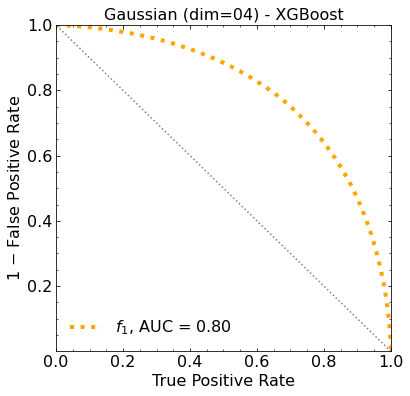

Classification score:


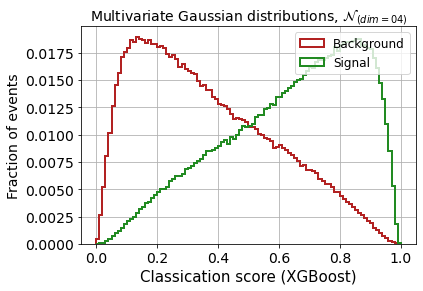

Classification score interpolation:


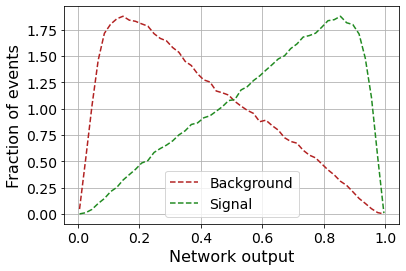


 ----------------------------------------- 

TRUE PDF LIKELIHOOD (GAUSSIANS):
B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  10000

 If  10100  =  1009    then the proposed range has to be extended
n_ensembles (actual):  9233
This may take long...


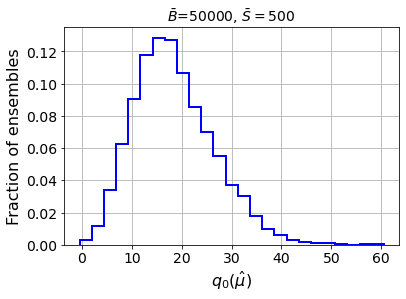

muhat mean:  0.9826167009639337
median q_muhat:  17.60046990141052
Z_gaussian:  4.195291396483744

 ------------------------------------ 

MACHINE-LEARNED LIKELIHOOD
B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  10000

 If  10100  =  1009    then the proposed range has to be extended
n_ensembles (actual):  9233

 This may take long... 



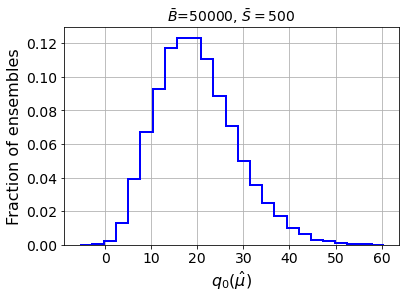

muhat mean:  1.042499729232102
median q_muhat:  19.20111188532917
Z_XG:  4.38190733417871

 ----------------------------------------- 

Working points, counting over 1 bin:
S_expected =  500
WP: 0     S/B**0.5=  2.23606797749979
WP:  0.25     S/B**0.5=  2.6501612122414833
WP:  0.5     S/B**0.5=  3.097421499100125
WP:  0.75     S/B**0.5=  3.2959269619417806
------------------------


In [47]:
dim=4

#######################
# generate the events #
#######################
    
background_X_1 = np.random.normal(-epsilon,1,N)
background_X_2 = np.random.normal(-epsilon,1,N)
background_X_3 = np.random.normal(-epsilon,1,N)
background_X_4 = np.random.normal(-epsilon,1,N)
    
signal_X_1 = np.random.normal(epsilon,1,N)
signal_X_2 = np.random.normal(epsilon,1,N)
signal_X_3 = np.random.normal(epsilon,1,N)
signal_X_4 = np.random.normal(epsilon,1,N)

dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))
dim4 = np.concatenate((background_X_4,signal_X_4))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['dim4'] = dim4.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2','dim3','dim4']].values 
Y_gauss = df[['Y']].values

X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss, Y_gauss, test_size=0.5)


print(X_gauss_train.shape)
print(Y_gauss_train.shape)
print(X_gauss_val.shape)
print(Y_gauss_val.shape)


# PLOT (only 1st feature) to visualize the data
X_gauss_val_SM = []
X_gauss_val_NP = []

for i in range(len(Y_gauss_val)):
    if Y_gauss_val[i] ==0:
        X_gauss_val_SM.append(X_gauss_val[i].tolist())
    else:
        X_gauss_val_NP.append(X_gauss_val[i].tolist())    


X_gauss_val_SM = np.array(X_gauss_val_SM)
X_gauss_val_NP = np.array(X_gauss_val_NP)


weights = np.ones_like(X_gauss_val_SM[:,0])/float(len(X_gauss_val_SM[:,0]))
plt.hist(X_gauss_val_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_val_NP[:,0])/float(len(X_gauss_val_NP[:,0]))
plt.hist(X_gauss_val_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  




#######################
# CLASSIFIER: XGBoost #
#######################

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_gauss_train,Y_gauss_train,eval_set=[(X_gauss_train, Y_gauss_train), (X_gauss_val, Y_gauss_val)],
        eval_metric='logloss',early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_gauss_val).T[1]


# ROC
fpr_gauss_xg, tpr_gauss_xg, _ = roc_curve(Y_gauss_val, y_pred_xg)
roc_auc_xg = auc(fpr_gauss_xg, tpr_gauss_xg)

store_AUC.append(roc_auc_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_gauss_xg,1-fpr_gauss_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.title(r"Gaussian (dim=%0.2d) - XGBoost" % dim,fontsize=16)
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_val)):
    if Y_gauss_val[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('Multivariate Gaussian distributions, $\mathcal{N}_{(dim=%0.2d)}$' % dim, fontsize=14)
plt.show()





# INTERPOLATE TO USE AS p_s(x) and p_b(x) ESTIMATES

# center of each bin

binsSM_mid = []
binsNP_mid = []

for i in range(len(binsSM)-1):
    binsSM_mid.append( ((binsSM[i+1]-binsSM[i])/2)+binsSM[i] )
    
for i in range(len(binsNP)-1):
    binsNP_mid.append( ((binsNP[i+1]-binsNP[i])/2)+binsNP[i] )
    

# get the width of each bin
bin_width_SM = binsSM[1] - binsSM[0]
bin_width_NP = binsNP[1] - binsNP[0]
   
    
# Interpolation, cubic
fcubic_XG_SM = interp1d(binsSM_mid, nSM, kind='cubic')
fcubic_XG_NP = interp1d(binsNP_mid, nNP, kind='cubic')


# Normalize

def fcubic_XG_SM_norm(x):
    return fcubic_XG_SM(x)/bin_width_SM

def fcubic_XG_NP_norm(x):
    return fcubic_XG_NP(x)/bin_width_NP


print('Classification score interpolation:')
# x to plot
xnew_XG_SM = np.linspace(min(binsSM_mid), max(binsSM_mid), num=50, endpoint=True)
xnew_XG_NP = np.linspace(min(binsNP_mid), max(binsNP_mid), num=50, endpoint=True)

plt.plot(xnew_XG_SM, fcubic_XG_SM_norm(xnew_XG_SM), '--', color='firebrick', label='Background')
plt.plot(xnew_XG_NP, fcubic_XG_NP_norm(xnew_XG_NP), '--', color='forestgreen', label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Network output",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.show()

print('\n ----------------------------------------- \n')





###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

print('TRUE PDF LIKELIHOOD (GAUSSIANS):')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print('S/$\sqrt{B}$: ', SsqrtB)
print('n_ensembles (initial): ', n_ensembles)


# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected


# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break


for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))



# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######



print('This may take long...')


#############################
# NOW LETS APPLY THE METHOD #
#############################
muhat_selected_list = []
q_muhat = []

for bb in range(len(list_nums_ensembles)):

    for kk in range(list_nums_ensembles[bb]):

        # SIGNAL events in an ensemble
        NP_shuf = shuffle(X_gauss_val_NP)[:list_S_per_ensembles[bb]]

        prob_NP_given_B = [] # p_b(S_ensemble)
        prob_NP_given_S = [] # p_s(S_ensemble)

        for ll in range(len(NP_shuf)):
            prob_NP_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]-epsilon)**2 + (NP_shuf[ll,1]-epsilon)**2 + (NP_shuf[ll,2]-epsilon)**2 + (NP_shuf[ll,3]-epsilon)**2 ) ) )
            prob_NP_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]+epsilon)**2 + (NP_shuf[ll,1]+epsilon)**2 + (NP_shuf[ll,2]+epsilon)**2 + (NP_shuf[ll,3]+epsilon)**2 ) ) )


        # BACKGROUND events in an ensemble
        SM_shuf = shuffle(X_gauss_val_SM)[:list_B_per_ensembles[bb]]

        prob_SM_given_B = [] # p_b(B_ensemble)
        prob_SM_given_S = [] # p_s(B_ensemble)

        for ll in range(len(SM_shuf)):
            prob_SM_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]-epsilon)**2 + (SM_shuf[ll,1]-epsilon)**2 + (SM_shuf[ll,2]-epsilon)**2 + (SM_shuf[ll,3]-epsilon)**2 ) ) )
            prob_SM_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]+epsilon)**2 + (SM_shuf[ll,1]+epsilon)**2 + (SM_shuf[ll,2]+epsilon)**2 + (SM_shuf[ll,3]+epsilon)**2 ) ) )


        # p_b(x_ensemble) =    concatenate: p_b(B_ensemble) and p_b(S_ensemble)
        prob_x_given_B = prob_SM_given_B + prob_NP_given_B

        # p_s(x_ensemble) =    concatenate: p_s(B_ensemble) and p_s(S_ensemble)
        prob_x_given_S = prob_SM_given_S + prob_NP_given_S




        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble



        mu_hat_condition_equal_1 = []

        # grid, mu_hat is around 1
        muhat_test = np.arange(0.5, 2, 0.1).tolist()

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



        muhat_selected = 1

        # from the grid, select the mu_hat such that the condition is equal to 1
        if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 > 0:
                    muhat_selected = muhat_test[ll]
                    break


        if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 < 0:
                    muhat_selected = muhat_test[ll]
                    break


        muhat_selected_list.append(muhat_selected)



        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
plt.show()


# Finally calculate muhat_mean and Z_gaussian
muhat_mean_gaussian = np.mean(muhat_selected_list)
store_muhat_mean_gaussian.append(muhat_mean_gaussian)

# Remove nan if any
q_muhat = [x for x in q_muhat if x == x]

q_muhat_median = np.median(q_muhat)

Z_gaussian = abs(q_muhat_median)**0.5
store_Z_gaussian.append(Z_gaussian)

print('muhat mean: ', muhat_mean_gaussian)
print('median q_muhat: ', q_muhat_median)
print('Z_gaussian: ', Z_gaussian)


print('\n ------------------------------------ \n')


    
    
    
##############################
# MACHINE-LEARNED LIKELIHOOD #
##############################

print('MACHINE-LEARNED LIKELIHOOD')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)
print('n_ensembles (initial): ', n_ensembles)


# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected


# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break


for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))



# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######



print('\n This may take long... \n')


# To avoid issues
for kkk in range(len(pred_XG_NP)):
    if pred_XG_NP[kkk] < min(binsNP_mid):
        pred_XG_NP[kkk] = min(binsNP_mid)+0.0005
    elif pred_XG_NP[kkk] > max(binsNP_mid):
        pred_XG_NP[kkk] = max(binsNP_mid)-0.0005      

for kkk in range(len(pred_XG_SM)):
    if pred_XG_SM[kkk] < min(binsSM_mid):
        pred_XG_SM[kkk] = min(binsSM_mid)+0.0005
    elif pred_XG_SM[kkk] > max(binsSM_mid):
        pred_XG_SM[kkk] = max(binsSM_mid)-0.0005
        
        

# NOW LETS APPLY THE METHOD

muhat_selected_list = []
q_muhat = []

for bb in range(len(list_nums_ensembles)):

    for kk in range(list_nums_ensembles[bb]):

        # SIGNAL: classification score for the SIGNAL events in an ensemble
        pred_NP_shuf = np.random.choice(pred_XG_NP, list_S_per_ensembles[bb])

        # BACKGROUND: classification score for the BACKGROUND events in an ensemble
        pred_SM_shuf = np.random.choice(pred_XG_SM, list_B_per_ensembles[bb])



        # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_B = np.ndarray.tolist( fcubic_XG_SM_norm( pred_SM_shuf ) ) + np.ndarray.tolist( fcubic_XG_SM_norm( pred_NP_shuf ) )

        # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_S = np.ndarray.tolist( fcubic_XG_NP_norm( pred_SM_shuf ) ) + np.ndarray.tolist( fcubic_XG_NP_norm( pred_NP_shuf ) )





        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble



        mu_hat_condition_equal_1 = []

        # grid, mu_hat is around 1
        muhat_test = np.arange(0.5, 2, 0.1).tolist()

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



        muhat_selected = 1

        # from the grid, select the mu_hat such that the condition is equal to 1
        if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 > 0:
                    muhat_selected = muhat_test[ll]
                    break


        if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 < 0:
                    muhat_selected = muhat_test[ll]
                    break


        muhat_selected_list.append(muhat_selected)



        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
plt.show()


# Finally calculate muhat_mean and Z_gaussian
muhat_mean_XG = np.mean(muhat_selected_list)
store_muhat_mean_XG_MLL.append(muhat_mean_XG)

# Remove nan if any
q_muhat = [x for x in q_muhat if x == x]

q_muhat_median = np.median(q_muhat)

Z_XG = abs(q_muhat_median)**0.5
store_Z_XG_MLL.append(Z_XG)

print('muhat mean: ', muhat_mean_XG)
print('median q_muhat: ', q_muhat_median)
print('Z_XG: ', Z_XG)


print('\n ----------------------------------------- \n')
    
    
    
    
    
    
#######################################
# Working points, counting over 1 bin #
#######################################

print('Working points, counting over 1 bin:')

# BACKGROUND 

# number of background ensembles
B_ensembles = int(len(pred_XG_SM)/B_expected)

# shorten the number of B events so I get an integer number of ensembles
pred_XG_SM_entero = pred_XG_SM[:int(len(pred_XG_SM)/B_expected) * B_expected]

XG_SM_passWP0 = 0
XG_SM_passWP1 = 0
XG_SM_passWP2 = 0

for i in range(len(pred_XG_SM_entero)):
    if pred_XG_SM_entero[i] > WP[0]:
        XG_SM_passWP0 += 1
    if pred_XG_SM_entero[i] > WP[1]:
        XG_SM_passWP1 += 1
    if pred_XG_SM_entero[i] > WP[2]:
        XG_SM_passWP2 += 1



# SIGNAL

# number of signal ensembles
S_ensembles = int(len(pred_XG_NP)/S_expected)

# shorten the number of S events so I get an integer number of ensembles
pred_XG_NP_entero = pred_XG_NP[:int(len(pred_XG_NP)/S_expected) * S_expected]

XG_NP_passWP0 = 0
XG_NP_passWP1 = 0
XG_NP_passWP2 = 0

for i in range(len(pred_XG_NP_entero)):
    if pred_XG_NP_entero[i] > WP[0]:
        XG_NP_passWP0 += 1
    if pred_XG_NP_entero[i] > WP[1]:
        XG_NP_passWP1 += 1
    if pred_XG_NP_entero[i] > WP[2]:
        XG_NP_passWP2 += 1

Z_WP0 = ( XG_NP_passWP0 / S_ensembles ) / ( XG_SM_passWP0 / B_ensembles )**0.5
Z_WP1 = ( XG_NP_passWP1 / S_ensembles ) / ( XG_SM_passWP1 / B_ensembles )**0.5
Z_WP2 = ( XG_NP_passWP2 / S_ensembles ) / ( XG_SM_passWP2 / B_ensembles )**0.5


# save the results Z_binned after WP
SrootB_WP0.append( Z_WP0 )
SrootB_WP1.append( Z_WP1 )
SrootB_WP2.append( Z_WP2 )

print('S_expected = ', S_expected)
print('WP: 0     S/B**0.5= ', S_expected/(B_expected)**0.5)
print('WP: ', WP[0], '    S/B**0.5= ', Z_WP0 )
print('WP: ', WP[1], '    S/B**0.5= ', Z_WP1 )
print('WP: ', WP[2], '    S/B**0.5= ', Z_WP2 )
print('------------------------')

In [48]:
print('dim = ', dim)

print(roc_auc_xg)

print(muhat_mean_gaussian)
print(Z_gaussian)

print(muhat_mean_XG)
print(Z_XG)

print(Z_WP0)
print(Z_WP1)
print(Z_WP2)

dim =  4
0.801921440479743
0.9826167009639337
4.195291396483744
1.042499729232102
4.38190733417871
2.6501612122414833
3.097421499100125
3.2959269619417806


In [ ]:
# To use if you dont want to run everything again. Store the previous results
store_AUC.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()

store_muhat_mean_XG_MLL.append()
store_Z_XG_MLL.append()

SrootB_WP0.append()
SrootB_WP1.append()
SrootB_WP2.append()

## Dim=5

(1000000, 5)
(1000000, 1)
(1000000, 5)
(1000000, 1)


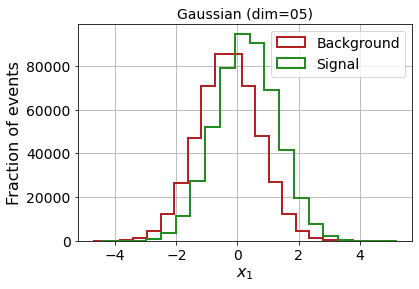

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67102	validation_1-logloss:0.67108
[1]	validation_0-logloss:0.65264	validation_1-logloss:0.65275
[2]	validation_0-logloss:0.63720	validation_1-logloss:0.63735
[3]	validation_0-logloss:0.62389	validation_1-logloss:0.62408
[4]	validation_0-logloss:0.61225	validation_1-logloss:0.61248
[5]	validation_0-logloss:0.60215	validation_1-logloss:0.60249
[6]	validation_0-logloss:0.59340	validation_1-logloss:0.59380
[7]	validation_0-logloss:0.58554	validation_1-logloss:0.58600
[8]	validation_0-logloss:0.57856	validation_1-logloss:0.57908
[9]	validation_0-logloss:0.57245	validation_1-logloss:0.57302
[10]	validation_0-logloss:0.56693	validation_1-logloss:0.56753
[11]	validation_0-logloss:0.56199	validation_1-logloss:0.56265
[12]	validation_0-logloss:0.55757	validation_1-logloss:0.55829
[13]	validation_0-logloss:0.55356	validation_1-logloss:0.55433
[14]	validation_0-logloss:0.54993	validation_1-logloss:0.55075
[15]	validation_0-logloss:0.54663	validation_1-logloss:0.54751
[1

[130]	validation_0-logloss:0.50633	validation_1-logloss:0.50916
[131]	validation_0-logloss:0.50632	validation_1-logloss:0.50916
[132]	validation_0-logloss:0.50631	validation_1-logloss:0.50916
[133]	validation_0-logloss:0.50630	validation_1-logloss:0.50916
[134]	validation_0-logloss:0.50629	validation_1-logloss:0.50916
[135]	validation_0-logloss:0.50627	validation_1-logloss:0.50915
[136]	validation_0-logloss:0.50626	validation_1-logloss:0.50916
[137]	validation_0-logloss:0.50625	validation_1-logloss:0.50915
[138]	validation_0-logloss:0.50625	validation_1-logloss:0.50915
[139]	validation_0-logloss:0.50624	validation_1-logloss:0.50915
[140]	validation_0-logloss:0.50623	validation_1-logloss:0.50915
[141]	validation_0-logloss:0.50622	validation_1-logloss:0.50915
[142]	validation_0-logloss:0.50621	validation_1-logloss:0.50915
[143]	validation_0-logloss:0.50620	validation_1-logloss:0.50915
[144]	validation_0-logloss:0.50618	validation_1-logloss:0.50916
[145]	validation_0-logloss:0.50618	valid

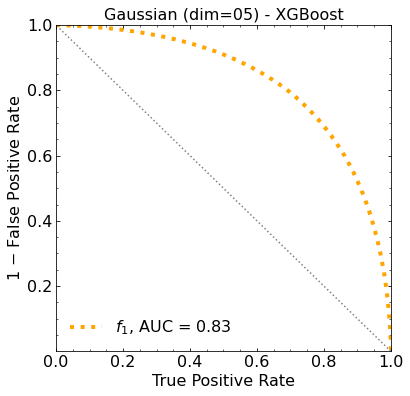

Classification score:


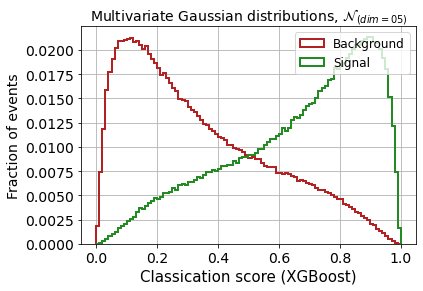

Classification score interpolation:


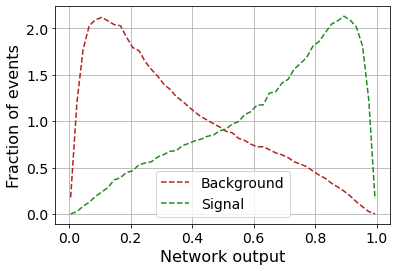


 ----------------------------------------- 

TRUE PDF LIKELIHOOD (GAUSSIANS):
B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  10000

 If  10100  =  1009    then the proposed range has to be extended
n_ensembles (actual):  9233
This may take long...


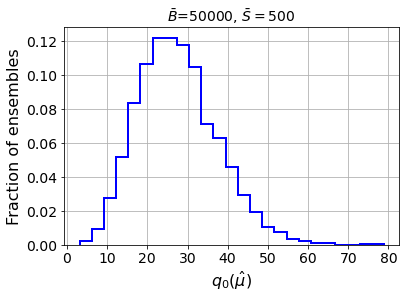

muhat mean:  1.0331094985378533
median q_muhat:  26.810001922002243
Z_gaussian:  5.177837571998782

 ------------------------------------ 

MACHINE-LEARNED LIKELIHOOD
B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  10000

 If  10100  =  1009    then the proposed range has to be extended
n_ensembles (actual):  9233

 This may take long... 



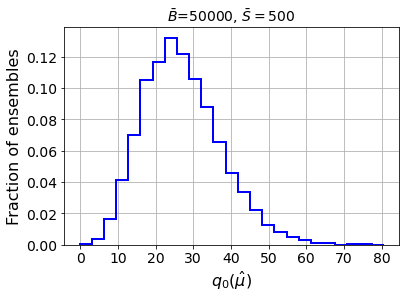

muhat mean:  1.0362828982995775
median q_muhat:  26.056598694116133
Z_XG:  5.104566455059247

 ----------------------------------------- 

Working points, counting over 1 bin:
S_expected =  500
WP: 0     S/B**0.5=  2.23606797749979
WP:  0.25     S/B**0.5=  2.7934384898886457
WP:  0.5     S/B**0.5=  3.340172178933246
WP:  0.75     S/B**0.5=  3.76635027415483
------------------------


In [81]:
dim=5

#######################
# generate the events #
#######################
    
background_X_1 = np.random.normal(-epsilon,1,N)
background_X_2 = np.random.normal(-epsilon,1,N)
background_X_3 = np.random.normal(-epsilon,1,N)
background_X_4 = np.random.normal(-epsilon,1,N)
background_X_5 = np.random.normal(-epsilon,1,N)
    
signal_X_1 = np.random.normal(epsilon,1,N)
signal_X_2 = np.random.normal(epsilon,1,N)
signal_X_3 = np.random.normal(epsilon,1,N)
signal_X_4 = np.random.normal(epsilon,1,N)
signal_X_5 = np.random.normal(epsilon,1,N)

dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))
dim4 = np.concatenate((background_X_4,signal_X_4))
dim5 = np.concatenate((background_X_5,signal_X_5))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['dim4'] = dim4.reshape(-1)
df['dim5'] = dim5.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2','dim3','dim4','dim5']].values 
Y_gauss = df[['Y']].values

X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss, Y_gauss, test_size=0.5)


print(X_gauss_train.shape)
print(Y_gauss_train.shape)
print(X_gauss_val.shape)
print(Y_gauss_val.shape)


# PLOT (only 1st feature) to visualize the data
X_gauss_val_SM = []
X_gauss_val_NP = []

for i in range(len(Y_gauss_val)):
    if Y_gauss_val[i] ==0:
        X_gauss_val_SM.append(X_gauss_val[i].tolist())
    else:
        X_gauss_val_NP.append(X_gauss_val[i].tolist())    


X_gauss_val_SM = np.array(X_gauss_val_SM)
X_gauss_val_NP = np.array(X_gauss_val_NP)


weights = np.ones_like(X_gauss_val_SM[:,0])/float(len(X_gauss_val_SM[:,0]))
plt.hist(X_gauss_val_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_val_NP[:,0])/float(len(X_gauss_val_NP[:,0]))
plt.hist(X_gauss_val_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  




#######################
# CLASSIFIER: XGBoost #
#######################

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_gauss_train,Y_gauss_train,eval_set=[(X_gauss_train, Y_gauss_train), (X_gauss_val, Y_gauss_val)],
        eval_metric='logloss',early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_gauss_val).T[1]


# ROC
fpr_gauss_xg, tpr_gauss_xg, _ = roc_curve(Y_gauss_val, y_pred_xg)
roc_auc_xg = auc(fpr_gauss_xg, tpr_gauss_xg)

store_AUC.append(roc_auc_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_gauss_xg,1-fpr_gauss_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.title(r"Gaussian (dim=%0.2d) - XGBoost" % dim,fontsize=16)
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_val)):
    if Y_gauss_val[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('Multivariate Gaussian distributions, $\mathcal{N}_{(dim=%0.2d)}$' % dim, fontsize=14)
plt.show()





# INTERPOLATE TO USE AS p_s(x) and p_b(x) ESTIMATES

# center of each bin

binsSM_mid = []
binsNP_mid = []

for i in range(len(binsSM)-1):
    binsSM_mid.append( ((binsSM[i+1]-binsSM[i])/2)+binsSM[i] )
    
for i in range(len(binsNP)-1):
    binsNP_mid.append( ((binsNP[i+1]-binsNP[i])/2)+binsNP[i] )
    

# get the width of each bin
bin_width_SM = binsSM[1] - binsSM[0]
bin_width_NP = binsNP[1] - binsNP[0]
   
    
# Interpolation, cubic
fcubic_XG_SM = interp1d(binsSM_mid, nSM, kind='cubic')
fcubic_XG_NP = interp1d(binsNP_mid, nNP, kind='cubic')


# Normalize

def fcubic_XG_SM_norm(x):
    return fcubic_XG_SM(x)/bin_width_SM

def fcubic_XG_NP_norm(x):
    return fcubic_XG_NP(x)/bin_width_NP


print('Classification score interpolation:')
# x to plot
xnew_XG_SM = np.linspace(min(binsSM_mid), max(binsSM_mid), num=50, endpoint=True)
xnew_XG_NP = np.linspace(min(binsNP_mid), max(binsNP_mid), num=50, endpoint=True)

plt.plot(xnew_XG_SM, fcubic_XG_SM_norm(xnew_XG_SM), '--', color='firebrick', label='Background')
plt.plot(xnew_XG_NP, fcubic_XG_NP_norm(xnew_XG_NP), '--', color='forestgreen', label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Network output",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.show()

print('\n ----------------------------------------- \n')





###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

print('TRUE PDF LIKELIHOOD (GAUSSIANS):')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print('S/$\sqrt{B}$: ', SsqrtB)
print('n_ensembles (initial): ', n_ensembles)


# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected


# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break


for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))



# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######



print('This may take long...')


#############################
# NOW LETS APPLY THE METHOD #
#############################
muhat_selected_list = []
q_muhat = []

for bb in range(len(list_nums_ensembles)):

    for kk in range(list_nums_ensembles[bb]):

        # SIGNAL events in an ensemble
        NP_shuf = shuffle(X_gauss_val_NP)[:list_S_per_ensembles[bb]]

        prob_NP_given_B = [] # p_b(S_ensemble)
        prob_NP_given_S = [] # p_s(S_ensemble)

        for ll in range(len(NP_shuf)):
            prob_NP_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]-epsilon)**2 + (NP_shuf[ll,1]-epsilon)**2 + (NP_shuf[ll,2]-epsilon)**2 + (NP_shuf[ll,3]-epsilon)**2 + (NP_shuf[ll,4]-epsilon)**2 ) ) )
            prob_NP_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]+epsilon)**2 + (NP_shuf[ll,1]+epsilon)**2 + (NP_shuf[ll,2]+epsilon)**2 + (NP_shuf[ll,3]+epsilon)**2 + (NP_shuf[ll,4]+epsilon)**2 ) ) )


        # BACKGROUND events in an ensemble
        SM_shuf = shuffle(X_gauss_val_SM)[:list_B_per_ensembles[bb]]

        prob_SM_given_B = [] # p_b(B_ensemble)
        prob_SM_given_S = [] # p_s(B_ensemble)

        for ll in range(len(SM_shuf)):
            prob_SM_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]-epsilon)**2 + (SM_shuf[ll,1]-epsilon)**2 + (SM_shuf[ll,2]-epsilon)**2 + (SM_shuf[ll,3]-epsilon)**2 + (SM_shuf[ll,4]-epsilon)**2 ) ) )
            prob_SM_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]+epsilon)**2 + (SM_shuf[ll,1]+epsilon)**2 + (SM_shuf[ll,2]+epsilon)**2 + (SM_shuf[ll,3]+epsilon)**2 + (SM_shuf[ll,4]+epsilon)**2 ) ) )


        # p_b(x_ensemble) =    concatenate: p_b(B_ensemble) and p_b(S_ensemble)
        prob_x_given_B = prob_SM_given_B + prob_NP_given_B

        # p_s(x_ensemble) =    concatenate: p_s(B_ensemble) and p_s(S_ensemble)
        prob_x_given_S = prob_SM_given_S + prob_NP_given_S




        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble



        mu_hat_condition_equal_1 = []

        # grid, mu_hat is around 1
        muhat_test = np.arange(0.5, 2, 0.1).tolist()

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



        muhat_selected = 1

        # from the grid, select the mu_hat such that the condition is equal to 1
        if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 > 0:
                    muhat_selected = muhat_test[ll]
                    break


        if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 < 0:
                    muhat_selected = muhat_test[ll]
                    break


        muhat_selected_list.append(muhat_selected)



        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
plt.show()


# Finally calculate muhat_mean and Z_gaussian
muhat_mean_gaussian = np.mean(muhat_selected_list)
store_muhat_mean_gaussian.append(muhat_mean_gaussian)

# Remove nan if any
q_muhat = [x for x in q_muhat if x == x]

q_muhat_median = np.median(q_muhat)

Z_gaussian = abs(q_muhat_median)**0.5
store_Z_gaussian.append(Z_gaussian)

print('muhat mean: ', muhat_mean_gaussian)
print('median q_muhat: ', q_muhat_median)
print('Z_gaussian: ', Z_gaussian)


print('\n ------------------------------------ \n')


    
    
    
##############################
# MACHINE-LEARNED LIKELIHOOD #
##############################

print('MACHINE-LEARNED LIKELIHOOD')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)
print('n_ensembles (initial): ', n_ensembles)


# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected


# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break


for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))



# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######



print('\n This may take long... \n')


# To avoid issues
for kkk in range(len(pred_XG_NP)):
    if pred_XG_NP[kkk] < min(binsNP_mid):
        pred_XG_NP[kkk] = min(binsNP_mid)
    elif pred_XG_NP[kkk] > max(binsNP_mid):
        pred_XG_NP[kkk] = max(binsNP_mid)        

for kkk in range(len(pred_XG_SM)):
    if pred_XG_SM[kkk] < min(binsSM_mid):
        pred_XG_SM[kkk] = min(binsSM_mid)
    elif pred_XG_SM[kkk] > max(binsSM_mid):
        pred_XG_SM[kkk] = max(binsSM_mid)
        
        

# NOW LETS APPLY THE METHOD

muhat_selected_list = []
q_muhat = []

for bb in range(len(list_nums_ensembles)):

    for kk in range(list_nums_ensembles[bb]):

        # SIGNAL: classification score for the SIGNAL events in an ensemble
        pred_NP_shuf = np.random.choice(pred_XG_NP, list_S_per_ensembles[bb])

        # BACKGROUND: classification score for the BACKGROUND events in an ensemble
        pred_SM_shuf = np.random.choice(pred_XG_SM, list_B_per_ensembles[bb])



        # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_B = np.ndarray.tolist( fcubic_XG_SM_norm( pred_SM_shuf ) ) + np.ndarray.tolist( fcubic_XG_SM_norm( pred_NP_shuf ) )

        # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_S = np.ndarray.tolist( fcubic_XG_NP_norm( pred_SM_shuf ) ) + np.ndarray.tolist( fcubic_XG_NP_norm( pred_NP_shuf ) )





        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble



        mu_hat_condition_equal_1 = []

        # grid, mu_hat is around 1
        muhat_test = np.arange(0.5, 2, 0.1).tolist()

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



        muhat_selected = 1

        # from the grid, select the mu_hat such that the condition is equal to 1
        if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 > 0:
                    muhat_selected = muhat_test[ll]
                    break


        if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 < 0:
                    muhat_selected = muhat_test[ll]
                    break


        muhat_selected_list.append(muhat_selected)



        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
plt.show()



# Finally calculate muhat_mean and Z_gaussian
muhat_mean_XG = np.mean(muhat_selected_list)
store_muhat_mean_XG_MLL.append(muhat_mean_XG)

# Remove nan if any
q_muhat = [x for x in q_muhat if x == x]

q_muhat_median = np.median(q_muhat)

Z_XG = abs(q_muhat_median)**0.5
store_Z_XG_MLL.append(Z_XG)

print('muhat mean: ', muhat_mean_XG)
print('median q_muhat: ', q_muhat_median)
print('Z_XG: ', Z_XG)


print('\n ----------------------------------------- \n')
    
    
    
    
    
    
#######################################
# Working points, counting over 1 bin #
#######################################

print('Working points, counting over 1 bin:')

# BACKGROUND 

# number of background ensembles
B_ensembles = int(len(pred_XG_SM)/B_expected)

# shorten the number of B events so I get an integer number of ensembles
pred_XG_SM_entero = pred_XG_SM[:int(len(pred_XG_SM)/B_expected) * B_expected]

XG_SM_passWP0 = 0
XG_SM_passWP1 = 0
XG_SM_passWP2 = 0

for i in range(len(pred_XG_SM_entero)):
    if pred_XG_SM_entero[i] > WP[0]:
        XG_SM_passWP0 += 1
    if pred_XG_SM_entero[i] > WP[1]:
        XG_SM_passWP1 += 1
    if pred_XG_SM_entero[i] > WP[2]:
        XG_SM_passWP2 += 1



# SIGNAL

# number of signal ensembles
S_ensembles = int(len(pred_XG_NP)/S_expected)

# shorten the number of S events so I get an integer number of ensembles
pred_XG_NP_entero = pred_XG_NP[:int(len(pred_XG_NP)/S_expected) * S_expected]

XG_NP_passWP0 = 0
XG_NP_passWP1 = 0
XG_NP_passWP2 = 0

for i in range(len(pred_XG_NP_entero)):
    if pred_XG_NP_entero[i] > WP[0]:
        XG_NP_passWP0 += 1
    if pred_XG_NP_entero[i] > WP[1]:
        XG_NP_passWP1 += 1
    if pred_XG_NP_entero[i] > WP[2]:
        XG_NP_passWP2 += 1

Z_WP0 = ( XG_NP_passWP0 / S_ensembles ) / ( XG_SM_passWP0 / B_ensembles )**0.5
Z_WP1 = ( XG_NP_passWP1 / S_ensembles ) / ( XG_SM_passWP1 / B_ensembles )**0.5
Z_WP2 = ( XG_NP_passWP2 / S_ensembles ) / ( XG_SM_passWP2 / B_ensembles )**0.5


# save the results Z_binned after WP
SrootB_WP0.append( Z_WP0 )
SrootB_WP1.append( Z_WP1 )
SrootB_WP2.append( Z_WP2 )

print('S_expected = ', S_expected)
print('WP: 0     S/B**0.5= ', S_expected/(B_expected)**0.5)
print('WP: ', WP[0], '    S/B**0.5= ', Z_WP0 )
print('WP: ', WP[1], '    S/B**0.5= ', Z_WP1 )
print('WP: ', WP[2], '    S/B**0.5= ', Z_WP2 )
print('------------------------')

In [82]:
print('dim = ', dim)

print(roc_auc_xg)

print(muhat_mean_gaussian)
print(Z_gaussian)

print(muhat_mean_XG)
print(Z_XG)

print(Z_WP0)
print(Z_WP1)
print(Z_WP2)

dim =  5
0.8280846316635674
1.0331094985378533
5.177837571998782
1.0362828982995775
5.104566455059247
2.7934384898886457
3.340172178933246
3.76635027415483


In [ ]:
# To use if you dont want to run everything again. Store the previous results
store_AUC.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()

store_muhat_mean_XG_MLL.append()
store_Z_XG_MLL.append()

SrootB_WP0.append()
SrootB_WP1.append()
SrootB_WP2.append()

## Dim=6

(1000000, 6)
(1000000, 1)
(1000000, 6)
(1000000, 1)


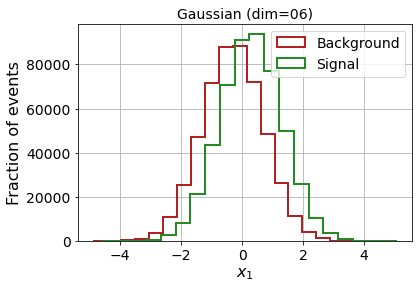

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67099	validation_1-logloss:0.67116
[1]	validation_0-logloss:0.65202	validation_1-logloss:0.65228
[2]	validation_0-logloss:0.63562	validation_1-logloss:0.63594
[3]	validation_0-logloss:0.62136	validation_1-logloss:0.62180
[4]	validation_0-logloss:0.60886	validation_1-logloss:0.60936
[5]	validation_0-logloss:0.59782	validation_1-logloss:0.59838
[6]	validation_0-logloss:0.58795	validation_1-logloss:0.58862
[7]	validation_0-logloss:0.57915	validation_1-logloss:0.57991
[8]	validation_0-logloss:0.57125	validation_1-logloss:0.57206
[9]	validation_0-logloss:0.56417	validation_1-logloss:0.56503
[10]	validation_0-logloss:0.55775	validation_1-logloss:0.55872
[11]	validation_0-logloss:0.55195	validation_1-logloss:0.55297
[12]	validation_0-logloss:0.54667	validation_1-logloss:0.54776
[13]	validation_0-logloss:0.54184	validation_1-logloss:0.54300
[14]	validation_0-logloss:0.53748	validation_1-logloss:0.53870
[15]	validation_0-logloss:0.53346	validation_1-logloss:0.53471
[1

[130]	validation_0-logloss:0.47737	validation_1-logloss:0.48109
[131]	validation_0-logloss:0.47736	validation_1-logloss:0.48109
[132]	validation_0-logloss:0.47734	validation_1-logloss:0.48109
[133]	validation_0-logloss:0.47733	validation_1-logloss:0.48109
[134]	validation_0-logloss:0.47731	validation_1-logloss:0.48109
[135]	validation_0-logloss:0.47729	validation_1-logloss:0.48109
[136]	validation_0-logloss:0.47727	validation_1-logloss:0.48109
[137]	validation_0-logloss:0.47726	validation_1-logloss:0.48108
[138]	validation_0-logloss:0.47724	validation_1-logloss:0.48108
[139]	validation_0-logloss:0.47722	validation_1-logloss:0.48108
[140]	validation_0-logloss:0.47721	validation_1-logloss:0.48108
[141]	validation_0-logloss:0.47720	validation_1-logloss:0.48108
[142]	validation_0-logloss:0.47719	validation_1-logloss:0.48108
[143]	validation_0-logloss:0.47717	validation_1-logloss:0.48108
[144]	validation_0-logloss:0.47715	validation_1-logloss:0.48108
[145]	validation_0-logloss:0.47714	valid

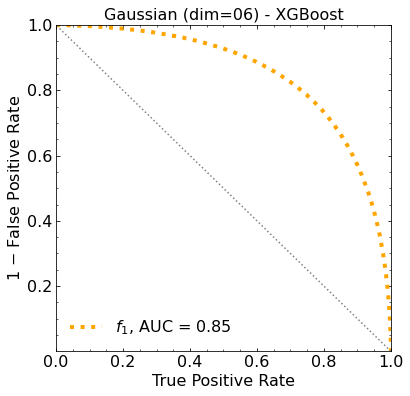

Classification score:


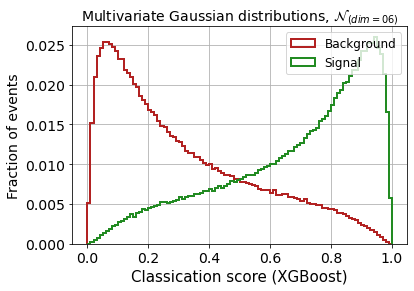

Classification score interpolation:


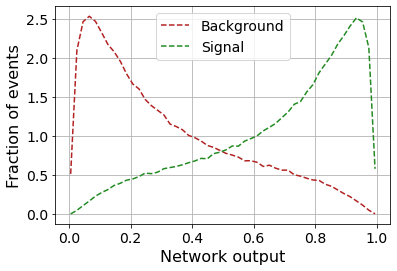


 ----------------------------------------- 

TRUE PDF LIKELIHOOD (GAUSSIANS):
B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  10000

 If  10100  =  1009    then the proposed range has to be extended
n_ensembles (actual):  9233
This may take long...


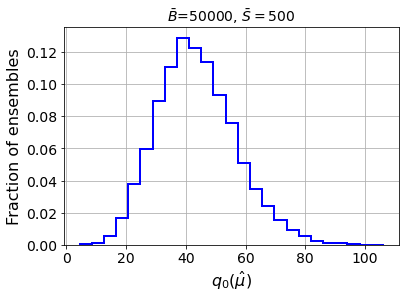

muhat mean:  1.1143723600129969
median q_muhat:  42.805093555220765
Z_gaussian:  6.542560168253767

 ------------------------------------ 

MACHINE-LEARNED LIKELIHOOD
B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  10000

 If  10100  =  1009    then the proposed range has to be extended
n_ensembles (actual):  9233

 This may take long... 



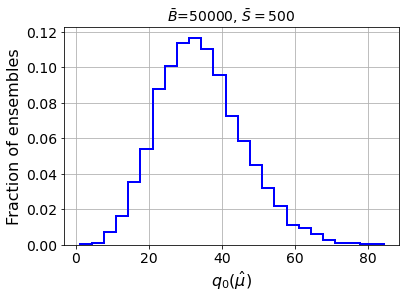

muhat mean:  1.0304234809920934
median q_muhat:  33.39139347004573
Z_XG:  5.7785286596196554

 ----------------------------------------- 

Working points, counting over 1 bin:
S_expected =  500
WP: 0     S/B**0.5=  2.23606797749979
WP:  0.25     S/B**0.5=  2.93234491428441
WP:  0.5     S/B**0.5=  3.5631600501290634
WP:  0.75     S/B**0.5=  4.168735417038943
------------------------


In [83]:
dim=6

#######################
# generate the events #
#######################
    
background_X_1 = np.random.normal(-epsilon,1,N)
background_X_2 = np.random.normal(-epsilon,1,N)
background_X_3 = np.random.normal(-epsilon,1,N)
background_X_4 = np.random.normal(-epsilon,1,N)
background_X_5 = np.random.normal(-epsilon,1,N)
background_X_6 = np.random.normal(-epsilon,1,N)
    
signal_X_1 = np.random.normal(epsilon,1,N)
signal_X_2 = np.random.normal(epsilon,1,N)
signal_X_3 = np.random.normal(epsilon,1,N)
signal_X_4 = np.random.normal(epsilon,1,N)
signal_X_5 = np.random.normal(epsilon,1,N)
signal_X_6 = np.random.normal(epsilon,1,N)

dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))
dim4 = np.concatenate((background_X_4,signal_X_4))
dim5 = np.concatenate((background_X_5,signal_X_5))
dim6 = np.concatenate((background_X_6,signal_X_6))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['dim4'] = dim4.reshape(-1)
df['dim5'] = dim5.reshape(-1)
df['dim6'] = dim6.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2','dim3','dim4','dim5','dim6']].values 
Y_gauss = df[['Y']].values

X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss, Y_gauss, test_size=0.5)


print(X_gauss_train.shape)
print(Y_gauss_train.shape)
print(X_gauss_val.shape)
print(Y_gauss_val.shape)


# PLOT (only 1st feature) to visualize the data
X_gauss_val_SM = []
X_gauss_val_NP = []

for i in range(len(Y_gauss_val)):
    if Y_gauss_val[i] ==0:
        X_gauss_val_SM.append(X_gauss_val[i].tolist())
    else:
        X_gauss_val_NP.append(X_gauss_val[i].tolist())    


X_gauss_val_SM = np.array(X_gauss_val_SM)
X_gauss_val_NP = np.array(X_gauss_val_NP)


weights = np.ones_like(X_gauss_val_SM[:,0])/float(len(X_gauss_val_SM[:,0]))
plt.hist(X_gauss_val_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_val_NP[:,0])/float(len(X_gauss_val_NP[:,0]))
plt.hist(X_gauss_val_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  




#######################
# CLASSIFIER: XGBoost #
#######################

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_gauss_train,Y_gauss_train,eval_set=[(X_gauss_train, Y_gauss_train), (X_gauss_val, Y_gauss_val)],
        eval_metric='logloss',early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_gauss_val).T[1]


# ROC
fpr_gauss_xg, tpr_gauss_xg, _ = roc_curve(Y_gauss_val, y_pred_xg)
roc_auc_xg = auc(fpr_gauss_xg, tpr_gauss_xg)

store_AUC.append(roc_auc_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_gauss_xg,1-fpr_gauss_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.title(r"Gaussian (dim=%0.2d) - XGBoost" % dim,fontsize=16)
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_val)):
    if Y_gauss_val[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('Multivariate Gaussian distributions, $\mathcal{N}_{(dim=%0.2d)}$' % dim, fontsize=14)
plt.show()





# INTERPOLATE TO USE AS p_s(x) and p_b(x) ESTIMATES

# center of each bin

binsSM_mid = []
binsNP_mid = []

for i in range(len(binsSM)-1):
    binsSM_mid.append( ((binsSM[i+1]-binsSM[i])/2)+binsSM[i] )
    
for i in range(len(binsNP)-1):
    binsNP_mid.append( ((binsNP[i+1]-binsNP[i])/2)+binsNP[i] )
    

# get the width of each bin
bin_width_SM = binsSM[1] - binsSM[0]
bin_width_NP = binsNP[1] - binsNP[0]
   
    
# Interpolation, cubic
fcubic_XG_SM = interp1d(binsSM_mid, nSM, kind='cubic')
fcubic_XG_NP = interp1d(binsNP_mid, nNP, kind='cubic')


# Normalize

def fcubic_XG_SM_norm(x):
    return fcubic_XG_SM(x)/bin_width_SM

def fcubic_XG_NP_norm(x):
    return fcubic_XG_NP(x)/bin_width_NP


print('Classification score interpolation:')
# x to plot
xnew_XG_SM = np.linspace(min(binsSM_mid), max(binsSM_mid), num=50, endpoint=True)
xnew_XG_NP = np.linspace(min(binsNP_mid), max(binsNP_mid), num=50, endpoint=True)

plt.plot(xnew_XG_SM, fcubic_XG_SM_norm(xnew_XG_SM), '--', color='firebrick', label='Background')
plt.plot(xnew_XG_NP, fcubic_XG_NP_norm(xnew_XG_NP), '--', color='forestgreen', label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Network output",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.show()

print('\n ----------------------------------------- \n')





###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

print('TRUE PDF LIKELIHOOD (GAUSSIANS):')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print('S/$\sqrt{B}$: ', SsqrtB)
print('n_ensembles (initial): ', n_ensembles)


# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected


# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break


for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))



# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######



print('This may take long...')


#############################
# NOW LETS APPLY THE METHOD #
#############################
muhat_selected_list = []
q_muhat = []

for bb in range(len(list_nums_ensembles)):

    for kk in range(list_nums_ensembles[bb]):

        # SIGNAL events in an ensemble
        NP_shuf = shuffle(X_gauss_val_NP)[:list_S_per_ensembles[bb]]

        prob_NP_given_B = [] # p_b(S_ensemble)
        prob_NP_given_S = [] # p_s(S_ensemble)

        for ll in range(len(NP_shuf)):
            prob_NP_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]-epsilon)**2 + (NP_shuf[ll,1]-epsilon)**2 + (NP_shuf[ll,2]-epsilon)**2 + (NP_shuf[ll,3]-epsilon)**2 + (NP_shuf[ll,4]-epsilon)**2 + (NP_shuf[ll,5]-epsilon)**2 ) ) )
            prob_NP_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]+epsilon)**2 + (NP_shuf[ll,1]+epsilon)**2 + (NP_shuf[ll,2]+epsilon)**2 + (NP_shuf[ll,3]+epsilon)**2 + (NP_shuf[ll,4]+epsilon)**2 + (NP_shuf[ll,5]+epsilon)**2 ) ) )


        # BACKGROUND events in an ensemble
        SM_shuf = shuffle(X_gauss_val_SM)[:list_B_per_ensembles[bb]]

        prob_SM_given_B = [] # p_b(B_ensemble)
        prob_SM_given_S = [] # p_s(B_ensemble)

        for ll in range(len(SM_shuf)):
            prob_SM_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]-epsilon)**2 + (SM_shuf[ll,1]-epsilon)**2 + (SM_shuf[ll,2]-epsilon)**2 + (SM_shuf[ll,3]-epsilon)**2 + (SM_shuf[ll,4]-epsilon)**2 + (SM_shuf[ll,5]-epsilon)**2 ) ) )
            prob_SM_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]+epsilon)**2 + (SM_shuf[ll,1]+epsilon)**2 + (SM_shuf[ll,2]+epsilon)**2 + (SM_shuf[ll,3]+epsilon)**2 + (SM_shuf[ll,4]+epsilon)**2 + (SM_shuf[ll,5]+epsilon)**2 ) ) )


        # p_b(x_ensemble) =    concatenate: p_b(B_ensemble) and p_b(S_ensemble)
        prob_x_given_B = prob_SM_given_B + prob_NP_given_B

        # p_s(x_ensemble) =    concatenate: p_s(B_ensemble) and p_s(S_ensemble)
        prob_x_given_S = prob_SM_given_S + prob_NP_given_S




        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble



        mu_hat_condition_equal_1 = []

        # grid, mu_hat is around 1
        muhat_test = np.arange(0.5, 2, 0.1).tolist()

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



        muhat_selected = 1

        # from the grid, select the mu_hat such that the condition is equal to 1
        if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 > 0:
                    muhat_selected = muhat_test[ll]
                    break


        if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 < 0:
                    muhat_selected = muhat_test[ll]
                    break


        muhat_selected_list.append(muhat_selected)



        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
plt.show()


# Finally calculate muhat_mean and Z_gaussian
muhat_mean_gaussian = np.mean(muhat_selected_list)
store_muhat_mean_gaussian.append(muhat_mean_gaussian)

# Remove nan if any
q_muhat = [x for x in q_muhat if x == x]

q_muhat_median = np.median(q_muhat)

Z_gaussian = abs(q_muhat_median)**0.5
store_Z_gaussian.append(Z_gaussian)

print('muhat mean: ', muhat_mean_gaussian)
print('median q_muhat: ', q_muhat_median)
print('Z_gaussian: ', Z_gaussian)


print('\n ------------------------------------ \n')


    
    
    
##############################
# MACHINE-LEARNED LIKELIHOOD #
##############################

print('MACHINE-LEARNED LIKELIHOOD')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)
print('n_ensembles (initial): ', n_ensembles)


# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected


# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break


for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))



# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######



print('\n This may take long... \n')


# To avoid issues
for kkk in range(len(pred_XG_NP)):
    if pred_XG_NP[kkk] < min(binsNP_mid):
        pred_XG_NP[kkk] = min(binsNP_mid)
    elif pred_XG_NP[kkk] > max(binsNP_mid):
        pred_XG_NP[kkk] = max(binsNP_mid)        

for kkk in range(len(pred_XG_SM)):
    if pred_XG_SM[kkk] < min(binsSM_mid):
        pred_XG_SM[kkk] = min(binsSM_mid)
    elif pred_XG_SM[kkk] > max(binsSM_mid):
        pred_XG_SM[kkk] = max(binsSM_mid)
        
        


# NOW LETS APPLY THE METHOD

muhat_selected_list = []
q_muhat = []

for bb in range(len(list_nums_ensembles)):

    for kk in range(list_nums_ensembles[bb]):

        # SIGNAL: classification score for the SIGNAL events in an ensemble
        pred_NP_shuf = np.random.choice(pred_XG_NP, list_S_per_ensembles[bb])

        # BACKGROUND: classification score for the BACKGROUND events in an ensemble
        pred_SM_shuf = np.random.choice(pred_XG_SM, list_B_per_ensembles[bb])



        # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_B = np.ndarray.tolist( fcubic_XG_SM_norm( pred_SM_shuf ) ) + np.ndarray.tolist( fcubic_XG_SM_norm( pred_NP_shuf ) )

        # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_S = np.ndarray.tolist( fcubic_XG_NP_norm( pred_SM_shuf ) ) + np.ndarray.tolist( fcubic_XG_NP_norm( pred_NP_shuf ) )





        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble



        mu_hat_condition_equal_1 = []

        # grid, mu_hat is around 1
        muhat_test = np.arange(0.5, 2, 0.1).tolist()

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



        muhat_selected = 1

        # from the grid, select the mu_hat such that the condition is equal to 1
        if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 > 0:
                    muhat_selected = muhat_test[ll]
                    break


        if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 < 0:
                    muhat_selected = muhat_test[ll]
                    break


        muhat_selected_list.append(muhat_selected)



        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
plt.show()



# Finally calculate muhat_mean and Z_gaussian
muhat_mean_XG = np.mean(muhat_selected_list)
store_muhat_mean_XG_MLL.append(muhat_mean_XG)

# Remove nan if any
q_muhat = [x for x in q_muhat if x == x]

q_muhat_median = np.median(q_muhat)

Z_XG = abs(q_muhat_median)**0.5
store_Z_XG_MLL.append(Z_XG)

print('muhat mean: ', muhat_mean_XG)
print('median q_muhat: ', q_muhat_median)
print('Z_XG: ', Z_XG)


print('\n ----------------------------------------- \n')
    
    
    
    
    
    
#######################################
# Working points, counting over 1 bin #
#######################################

print('Working points, counting over 1 bin:')

# BACKGROUND 

# number of background ensembles
B_ensembles = int(len(pred_XG_SM)/B_expected)

# shorten the number of B events so I get an integer number of ensembles
pred_XG_SM_entero = pred_XG_SM[:int(len(pred_XG_SM)/B_expected) * B_expected]

XG_SM_passWP0 = 0
XG_SM_passWP1 = 0
XG_SM_passWP2 = 0

for i in range(len(pred_XG_SM_entero)):
    if pred_XG_SM_entero[i] > WP[0]:
        XG_SM_passWP0 += 1
    if pred_XG_SM_entero[i] > WP[1]:
        XG_SM_passWP1 += 1
    if pred_XG_SM_entero[i] > WP[2]:
        XG_SM_passWP2 += 1



# SIGNAL

# number of signal ensembles
S_ensembles = int(len(pred_XG_NP)/S_expected)

# shorten the number of S events so I get an integer number of ensembles
pred_XG_NP_entero = pred_XG_NP[:int(len(pred_XG_NP)/S_expected) * S_expected]

XG_NP_passWP0 = 0
XG_NP_passWP1 = 0
XG_NP_passWP2 = 0

for i in range(len(pred_XG_NP_entero)):
    if pred_XG_NP_entero[i] > WP[0]:
        XG_NP_passWP0 += 1
    if pred_XG_NP_entero[i] > WP[1]:
        XG_NP_passWP1 += 1
    if pred_XG_NP_entero[i] > WP[2]:
        XG_NP_passWP2 += 1

Z_WP0 = ( XG_NP_passWP0 / S_ensembles ) / ( XG_SM_passWP0 / B_ensembles )**0.5
Z_WP1 = ( XG_NP_passWP1 / S_ensembles ) / ( XG_SM_passWP1 / B_ensembles )**0.5
Z_WP2 = ( XG_NP_passWP2 / S_ensembles ) / ( XG_SM_passWP2 / B_ensembles )**0.5


# save the results Z_binned after WP
SrootB_WP0.append( Z_WP0 )
SrootB_WP1.append( Z_WP1 )
SrootB_WP2.append( Z_WP2 )

print('S_expected = ', S_expected)
print('WP: 0     S/B**0.5= ', S_expected/(B_expected)**0.5)
print('WP: ', WP[0], '    S/B**0.5= ', Z_WP0 )
print('WP: ', WP[1], '    S/B**0.5= ', Z_WP1 )
print('WP: ', WP[2], '    S/B**0.5= ', Z_WP2 )
print('------------------------')

In [84]:
print('dim = ', dim)

print(roc_auc_xg)

print(muhat_mean_gaussian)
print(Z_gaussian)

print(muhat_mean_XG)
print(Z_XG)

print(Z_WP0)
print(Z_WP1)
print(Z_WP2)

dim =  6
0.8492481620103038
1.1143723600129969
6.542560168253767
1.0304234809920934
5.7785286596196554
2.93234491428441
3.5631600501290634
4.168735417038943


In [ ]:
# To use if you dont want to run everything again. Store the previous results
store_AUC.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()

store_muhat_mean_XG_MLL.append()
store_Z_XG_MLL.append()

SrootB_WP0.append()
SrootB_WP1.append()
SrootB_WP2.append()

## Dim=7

(1000000, 7)
(1000000, 1)
(1000000, 7)
(1000000, 1)


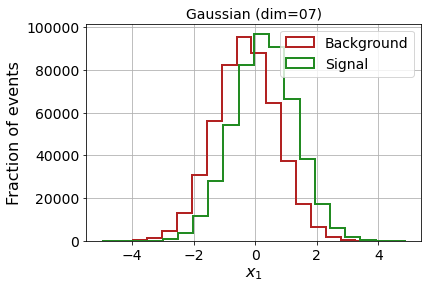

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67084	validation_1-logloss:0.67109
[1]	validation_0-logloss:0.65118	validation_1-logloss:0.65150
[2]	validation_0-logloss:0.63403	validation_1-logloss:0.63443
[3]	validation_0-logloss:0.61892	validation_1-logloss:0.61946
[4]	validation_0-logloss:0.60554	validation_1-logloss:0.60620
[5]	validation_0-logloss:0.59358	validation_1-logloss:0.59434
[6]	validation_0-logloss:0.58282	validation_1-logloss:0.58362
[7]	validation_0-logloss:0.57317	validation_1-logloss:0.57403
[8]	validation_0-logloss:0.56436	validation_1-logloss:0.56538
[9]	validation_0-logloss:0.55640	validation_1-logloss:0.55758
[10]	validation_0-logloss:0.54916	validation_1-logloss:0.55044
[11]	validation_0-logloss:0.54255	validation_1-logloss:0.54389
[12]	validation_0-logloss:0.53647	validation_1-logloss:0.53793
[13]	validation_0-logloss:0.53095	validation_1-logloss:0.53244
[14]	validation_0-logloss:0.52585	validation_1-logloss:0.52742
[15]	validation_0-logloss:0.52115	validation_1-logloss:0.52276
[1

[130]	validation_0-logloss:0.44854	validation_1-logloss:0.45352
[131]	validation_0-logloss:0.44851	validation_1-logloss:0.45352
[132]	validation_0-logloss:0.44849	validation_1-logloss:0.45351
[133]	validation_0-logloss:0.44846	validation_1-logloss:0.45350
[134]	validation_0-logloss:0.44843	validation_1-logloss:0.45349
[135]	validation_0-logloss:0.44841	validation_1-logloss:0.45349
[136]	validation_0-logloss:0.44839	validation_1-logloss:0.45348
[137]	validation_0-logloss:0.44837	validation_1-logloss:0.45348
[138]	validation_0-logloss:0.44834	validation_1-logloss:0.45347
[139]	validation_0-logloss:0.44832	validation_1-logloss:0.45347
[140]	validation_0-logloss:0.44830	validation_1-logloss:0.45346
[141]	validation_0-logloss:0.44828	validation_1-logloss:0.45346
[142]	validation_0-logloss:0.44826	validation_1-logloss:0.45345
[143]	validation_0-logloss:0.44824	validation_1-logloss:0.45345
[144]	validation_0-logloss:0.44822	validation_1-logloss:0.45345
[145]	validation_0-logloss:0.44820	valid

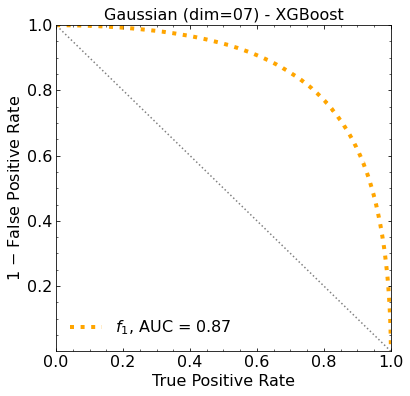

Classification score:


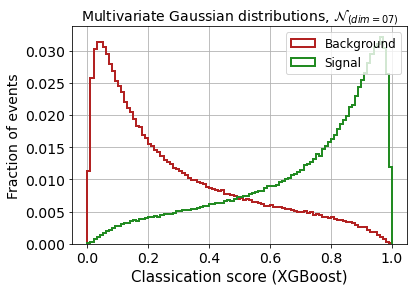

Classification score interpolation:


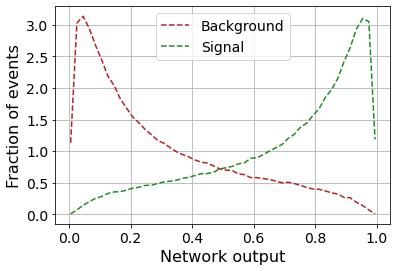


 ----------------------------------------- 

TRUE PDF LIKELIHOOD (GAUSSIANS):
B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  10000

 If  10100  =  1009    then the proposed range has to be extended
n_ensembles (actual):  9233
This may take long...


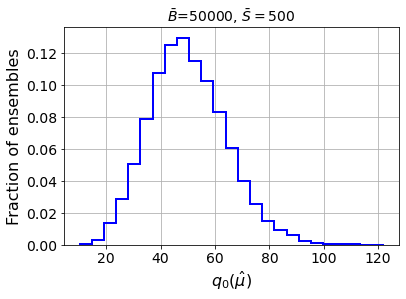

muhat mean:  1.0299902523556805
median q_muhat:  49.226478761475164
Z_gaussian:  7.016158404816354

 ------------------------------------ 

MACHINE-LEARNED LIKELIHOOD
B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  10000

 If  10100  =  1009    then the proposed range has to be extended
n_ensembles (actual):  9233

 This may take long... 



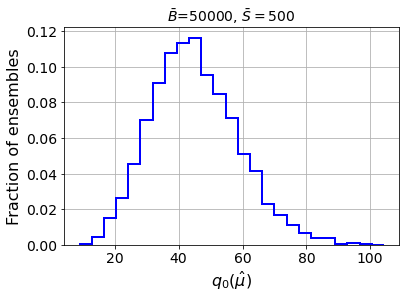

muhat mean:  1.0302285281057078
median q_muhat:  44.123911582992264
Z_XG:  6.642583201059078

 ----------------------------------------- 

Working points, counting over 1 bin:
S_expected =  500
WP: 0     S/B**0.5=  2.23606797749979
WP:  0.25     S/B**0.5=  3.078903503895336
WP:  0.5     S/B**0.5=  3.7920854651140865
WP:  0.75     S/B**0.5=  4.575809532266483
------------------------


In [53]:
dim=7

#######################
# generate the events #
#######################
    
background_X_1 = np.random.normal(-epsilon,1,N)
background_X_2 = np.random.normal(-epsilon,1,N)
background_X_3 = np.random.normal(-epsilon,1,N)
background_X_4 = np.random.normal(-epsilon,1,N)
background_X_5 = np.random.normal(-epsilon,1,N)
background_X_6 = np.random.normal(-epsilon,1,N)
background_X_7 = np.random.normal(-epsilon,1,N)
    
signal_X_1 = np.random.normal(epsilon,1,N)
signal_X_2 = np.random.normal(epsilon,1,N)
signal_X_3 = np.random.normal(epsilon,1,N)
signal_X_4 = np.random.normal(epsilon,1,N)
signal_X_5 = np.random.normal(epsilon,1,N)
signal_X_6 = np.random.normal(epsilon,1,N)
signal_X_7 = np.random.normal(epsilon,1,N)

dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))
dim4 = np.concatenate((background_X_4,signal_X_4))
dim5 = np.concatenate((background_X_5,signal_X_5))
dim6 = np.concatenate((background_X_6,signal_X_6))
dim7 = np.concatenate((background_X_7,signal_X_7))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['dim4'] = dim4.reshape(-1)
df['dim5'] = dim5.reshape(-1)
df['dim6'] = dim6.reshape(-1)
df['dim7'] = dim7.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2','dim3','dim4','dim5','dim6','dim7']].values 
Y_gauss = df[['Y']].values

X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss, Y_gauss, test_size=0.5)


print(X_gauss_train.shape)
print(Y_gauss_train.shape)
print(X_gauss_val.shape)
print(Y_gauss_val.shape)


# PLOT (only 1st feature) to visualize the data
X_gauss_val_SM = []
X_gauss_val_NP = []

for i in range(len(Y_gauss_val)):
    if Y_gauss_val[i] ==0:
        X_gauss_val_SM.append(X_gauss_val[i].tolist())
    else:
        X_gauss_val_NP.append(X_gauss_val[i].tolist())    


X_gauss_val_SM = np.array(X_gauss_val_SM)
X_gauss_val_NP = np.array(X_gauss_val_NP)


weights = np.ones_like(X_gauss_val_SM[:,0])/float(len(X_gauss_val_SM[:,0]))
plt.hist(X_gauss_val_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_val_NP[:,0])/float(len(X_gauss_val_NP[:,0]))
plt.hist(X_gauss_val_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  




#######################
# CLASSIFIER: XGBoost #
#######################

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_gauss_train,Y_gauss_train,eval_set=[(X_gauss_train, Y_gauss_train), (X_gauss_val, Y_gauss_val)],
        eval_metric='logloss',early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_gauss_val).T[1]


# ROC
fpr_gauss_xg, tpr_gauss_xg, _ = roc_curve(Y_gauss_val, y_pred_xg)
roc_auc_xg = auc(fpr_gauss_xg, tpr_gauss_xg)

store_AUC.append(roc_auc_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_gauss_xg,1-fpr_gauss_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.title(r"Gaussian (dim=%0.2d) - XGBoost" % dim,fontsize=16)
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_val)):
    if Y_gauss_val[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('Multivariate Gaussian distributions, $\mathcal{N}_{(dim=%0.2d)}$' % dim, fontsize=14)
plt.show()





# INTERPOLATE TO USE AS p_s(x) and p_b(x) ESTIMATES

# center of each bin

binsSM_mid = []
binsNP_mid = []

for i in range(len(binsSM)-1):
    binsSM_mid.append( ((binsSM[i+1]-binsSM[i])/2)+binsSM[i] )
    
for i in range(len(binsNP)-1):
    binsNP_mid.append( ((binsNP[i+1]-binsNP[i])/2)+binsNP[i] )
    

# get the width of each bin
bin_width_SM = binsSM[1] - binsSM[0]
bin_width_NP = binsNP[1] - binsNP[0]
   
    
# Interpolation, cubic
fcubic_XG_SM = interp1d(binsSM_mid, nSM, kind='cubic')
fcubic_XG_NP = interp1d(binsNP_mid, nNP, kind='cubic')


# Normalize

def fcubic_XG_SM_norm(x):
    return fcubic_XG_SM(x)/bin_width_SM

def fcubic_XG_NP_norm(x):
    return fcubic_XG_NP(x)/bin_width_NP


print('Classification score interpolation:')
# x to plot
xnew_XG_SM = np.linspace(min(binsSM_mid), max(binsSM_mid), num=50, endpoint=True)
xnew_XG_NP = np.linspace(min(binsNP_mid), max(binsNP_mid), num=50, endpoint=True)

plt.plot(xnew_XG_SM, fcubic_XG_SM_norm(xnew_XG_SM), '--', color='firebrick', label='Background')
plt.plot(xnew_XG_NP, fcubic_XG_NP_norm(xnew_XG_NP), '--', color='forestgreen', label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Network output",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.show()

print('\n ----------------------------------------- \n')





###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

print('TRUE PDF LIKELIHOOD (GAUSSIANS):')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print('S/$\sqrt{B}$: ', SsqrtB)
print('n_ensembles (initial): ', n_ensembles)


# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected


# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break


for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))



# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######



print('This may take long...')


#############################
# NOW LETS APPLY THE METHOD #
#############################
muhat_selected_list = []
q_muhat = []

for bb in range(len(list_nums_ensembles)):

    for kk in range(list_nums_ensembles[bb]):

        # SIGNAL events in an ensemble
        NP_shuf = shuffle(X_gauss_val_NP)[:list_S_per_ensembles[bb]]

        prob_NP_given_B = [] # p_b(S_ensemble)
        prob_NP_given_S = [] # p_s(S_ensemble)

        for ll in range(len(NP_shuf)):
            prob_NP_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]-epsilon)**2 + (NP_shuf[ll,1]-epsilon)**2 + (NP_shuf[ll,2]-epsilon)**2 + (NP_shuf[ll,3]-epsilon)**2 + (NP_shuf[ll,4]-epsilon)**2 + (NP_shuf[ll,5]-epsilon)**2 + (NP_shuf[ll,6]-epsilon)**2 ) ) )
            prob_NP_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]+epsilon)**2 + (NP_shuf[ll,1]+epsilon)**2 + (NP_shuf[ll,2]+epsilon)**2 + (NP_shuf[ll,3]+epsilon)**2 + (NP_shuf[ll,4]+epsilon)**2 + (NP_shuf[ll,5]+epsilon)**2 + (NP_shuf[ll,6]+epsilon)**2 ) ) )


        # BACKGROUND events in an ensemble
        SM_shuf = shuffle(X_gauss_val_SM)[:list_B_per_ensembles[bb]]

        prob_SM_given_B = [] # p_b(B_ensemble)
        prob_SM_given_S = [] # p_s(B_ensemble)

        for ll in range(len(SM_shuf)):
            prob_SM_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]-epsilon)**2 + (SM_shuf[ll,1]-epsilon)**2 + (SM_shuf[ll,2]-epsilon)**2 + (SM_shuf[ll,3]-epsilon)**2 + (SM_shuf[ll,4]-epsilon)**2 + (SM_shuf[ll,5]-epsilon)**2 + (SM_shuf[ll,6]-epsilon)**2 ) ) )
            prob_SM_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]+epsilon)**2 + (SM_shuf[ll,1]+epsilon)**2 + (SM_shuf[ll,2]+epsilon)**2 + (SM_shuf[ll,3]+epsilon)**2 + (SM_shuf[ll,4]+epsilon)**2 + (SM_shuf[ll,5]+epsilon)**2 + (SM_shuf[ll,6]+epsilon)**2 ) ) )


        # p_b(x_ensemble) =    concatenate: p_b(B_ensemble) and p_b(S_ensemble)
        prob_x_given_B = prob_SM_given_B + prob_NP_given_B

        # p_s(x_ensemble) =    concatenate: p_s(B_ensemble) and p_s(S_ensemble)
        prob_x_given_S = prob_SM_given_S + prob_NP_given_S




        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble



        mu_hat_condition_equal_1 = []

        # grid, mu_hat is around 1
        muhat_test = np.arange(0.5, 2, 0.1).tolist()

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



        muhat_selected = 1

        # from the grid, select the mu_hat such that the condition is equal to 1
        if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 > 0:
                    muhat_selected = muhat_test[ll]
                    break


        if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 < 0:
                    muhat_selected = muhat_test[ll]
                    break


        muhat_selected_list.append(muhat_selected)



        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
plt.show()


# Finally calculate muhat_mean and Z_gaussian
muhat_mean_gaussian = np.mean(muhat_selected_list)
store_muhat_mean_gaussian.append(muhat_mean_gaussian)

# Remove nan if any
q_muhat = [x for x in q_muhat if x == x]

q_muhat_median = np.median(q_muhat)

Z_gaussian = abs(q_muhat_median)**0.5
store_Z_gaussian.append(Z_gaussian)

print('muhat mean: ', muhat_mean_gaussian)
print('median q_muhat: ', q_muhat_median)
print('Z_gaussian: ', Z_gaussian)


print('\n ------------------------------------ \n')


    
    
    
##############################
# MACHINE-LEARNED LIKELIHOOD #
##############################

print('MACHINE-LEARNED LIKELIHOOD')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)
print('n_ensembles (initial): ', n_ensembles)


# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected


# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break


for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))



# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######



print('\n This may take long... \n')


# To avoid issues
for kkk in range(len(pred_XG_NP)):
    if pred_XG_NP[kkk] < min(binsNP_mid):
        pred_XG_NP[kkk] = min(binsNP_mid)
    elif pred_XG_NP[kkk] > max(binsNP_mid):
        pred_XG_NP[kkk] = max(binsNP_mid)        

for kkk in range(len(pred_XG_SM)):
    if pred_XG_SM[kkk] < min(binsSM_mid):
        pred_XG_SM[kkk] = min(binsSM_mid)
    elif pred_XG_SM[kkk] > max(binsSM_mid):
        pred_XG_SM[kkk] = max(binsSM_mid)
        
        

# NOW LETS APPLY THE METHOD

muhat_selected_list = []
q_muhat = []

for bb in range(len(list_nums_ensembles)):

    for kk in range(list_nums_ensembles[bb]):

        # SIGNAL: classification score for the SIGNAL events in an ensemble
        pred_NP_shuf = np.random.choice(pred_XG_NP, list_S_per_ensembles[bb])

        # BACKGROUND: classification score for the BACKGROUND events in an ensemble
        pred_SM_shuf = np.random.choice(pred_XG_SM, list_B_per_ensembles[bb])



        # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_B = np.ndarray.tolist( fcubic_XG_SM_norm( pred_SM_shuf ) ) + np.ndarray.tolist( fcubic_XG_SM_norm( pred_NP_shuf ) )

        # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_S = np.ndarray.tolist( fcubic_XG_NP_norm( pred_SM_shuf ) ) + np.ndarray.tolist( fcubic_XG_NP_norm( pred_NP_shuf ) )





        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble



        mu_hat_condition_equal_1 = []

        # grid, mu_hat is around 1
        muhat_test = np.arange(0.5, 2, 0.1).tolist()

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



        muhat_selected = 1

        # from the grid, select the mu_hat such that the condition is equal to 1
        if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 > 0:
                    muhat_selected = muhat_test[ll]
                    break


        if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 < 0:
                    muhat_selected = muhat_test[ll]
                    break


        muhat_selected_list.append(muhat_selected)



        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
plt.show()



# Finally calculate muhat_mean and Z_gaussian
muhat_mean_XG = np.mean(muhat_selected_list)
store_muhat_mean_XG_MLL.append(muhat_mean_XG)

# Remove nan if any
q_muhat = [x for x in q_muhat if x == x]

q_muhat_median = np.median(q_muhat)

Z_XG = abs(q_muhat_median)**0.5
store_Z_XG_MLL.append(Z_XG)

print('muhat mean: ', muhat_mean_XG)
print('median q_muhat: ', q_muhat_median)
print('Z_XG: ', Z_XG)


print('\n ----------------------------------------- \n')
    
    
    
    
    
    
#######################################
# Working points, counting over 1 bin #
#######################################

print('Working points, counting over 1 bin:')

# BACKGROUND 

# number of background ensembles
B_ensembles = int(len(pred_XG_SM)/B_expected)

# shorten the number of B events so I get an integer number of ensembles
pred_XG_SM_entero = pred_XG_SM[:int(len(pred_XG_SM)/B_expected) * B_expected]

XG_SM_passWP0 = 0
XG_SM_passWP1 = 0
XG_SM_passWP2 = 0

for i in range(len(pred_XG_SM_entero)):
    if pred_XG_SM_entero[i] > WP[0]:
        XG_SM_passWP0 += 1
    if pred_XG_SM_entero[i] > WP[1]:
        XG_SM_passWP1 += 1
    if pred_XG_SM_entero[i] > WP[2]:
        XG_SM_passWP2 += 1



# SIGNAL

# number of signal ensembles
S_ensembles = int(len(pred_XG_NP)/S_expected)

# shorten the number of S events so I get an integer number of ensembles
pred_XG_NP_entero = pred_XG_NP[:int(len(pred_XG_NP)/S_expected) * S_expected]

XG_NP_passWP0 = 0
XG_NP_passWP1 = 0
XG_NP_passWP2 = 0

for i in range(len(pred_XG_NP_entero)):
    if pred_XG_NP_entero[i] > WP[0]:
        XG_NP_passWP0 += 1
    if pred_XG_NP_entero[i] > WP[1]:
        XG_NP_passWP1 += 1
    if pred_XG_NP_entero[i] > WP[2]:
        XG_NP_passWP2 += 1

Z_WP0 = ( XG_NP_passWP0 / S_ensembles ) / ( XG_SM_passWP0 / B_ensembles )**0.5
Z_WP1 = ( XG_NP_passWP1 / S_ensembles ) / ( XG_SM_passWP1 / B_ensembles )**0.5
Z_WP2 = ( XG_NP_passWP2 / S_ensembles ) / ( XG_SM_passWP2 / B_ensembles )**0.5


# save the results Z_binned after WP
SrootB_WP0.append( Z_WP0 )
SrootB_WP1.append( Z_WP1 )
SrootB_WP2.append( Z_WP2 )

print('S_expected = ', S_expected)
print('WP: 0     S/B**0.5= ', S_expected/(B_expected)**0.5)
print('WP: ', WP[0], '    S/B**0.5= ', Z_WP0 )
print('WP: ', WP[1], '    S/B**0.5= ', Z_WP1 )
print('WP: ', WP[2], '    S/B**0.5= ', Z_WP2 )
print('------------------------')

In [54]:
print('dim = ', dim)

print(roc_auc_xg)

print(muhat_mean_gaussian)
print(Z_gaussian)

print(muhat_mean_XG)
print(Z_XG)

print(Z_WP0)
print(Z_WP1)
print(Z_WP2)

dim =  7
0.8680980324323412
1.0299902523556805
7.016158404816354
1.0302285281057078
6.642583201059078
3.078903503895336
3.7920854651140865
4.575809532266483


In [ ]:
# To use if you dont want to run everything again. Store the previous results
store_AUC.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()

store_muhat_mean_XG_MLL.append()
store_Z_XG_MLL.append()

SrootB_WP0.append()
SrootB_WP1.append()
SrootB_WP2.append()

## Dim=8

(1000000, 8)
(1000000, 1)
(1000000, 8)
(1000000, 1)


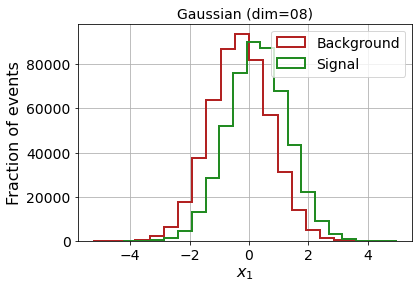

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67065	validation_1-logloss:0.67095
[1]	validation_0-logloss:0.65064	validation_1-logloss:0.65112
[2]	validation_0-logloss:0.63295	validation_1-logloss:0.63359
[3]	validation_0-logloss:0.61726	validation_1-logloss:0.61801
[4]	validation_0-logloss:0.60321	validation_1-logloss:0.60413
[5]	validation_0-logloss:0.59050	validation_1-logloss:0.59156
[6]	validation_0-logloss:0.57907	validation_1-logloss:0.58030
[7]	validation_0-logloss:0.56863	validation_1-logloss:0.57001
[8]	validation_0-logloss:0.55914	validation_1-logloss:0.56061
[9]	validation_0-logloss:0.55050	validation_1-logloss:0.55205
[10]	validation_0-logloss:0.54258	validation_1-logloss:0.54423
[11]	validation_0-logloss:0.53531	validation_1-logloss:0.53706
[12]	validation_0-logloss:0.52855	validation_1-logloss:0.53045
[13]	validation_0-logloss:0.52238	validation_1-logloss:0.52441
[14]	validation_0-logloss:0.51669	validation_1-logloss:0.51879
[15]	validation_0-logloss:0.51144	validation_1-logloss:0.51362
[1

[130]	validation_0-logloss:0.42228	validation_1-logloss:0.42853
[131]	validation_0-logloss:0.42225	validation_1-logloss:0.42851
[132]	validation_0-logloss:0.42221	validation_1-logloss:0.42850
[133]	validation_0-logloss:0.42217	validation_1-logloss:0.42848
[134]	validation_0-logloss:0.42213	validation_1-logloss:0.42846
[135]	validation_0-logloss:0.42210	validation_1-logloss:0.42844
[136]	validation_0-logloss:0.42207	validation_1-logloss:0.42842
[137]	validation_0-logloss:0.42203	validation_1-logloss:0.42841
[138]	validation_0-logloss:0.42199	validation_1-logloss:0.42840
[139]	validation_0-logloss:0.42196	validation_1-logloss:0.42838
[140]	validation_0-logloss:0.42192	validation_1-logloss:0.42837
[141]	validation_0-logloss:0.42189	validation_1-logloss:0.42836
[142]	validation_0-logloss:0.42185	validation_1-logloss:0.42834
[143]	validation_0-logloss:0.42183	validation_1-logloss:0.42834
[144]	validation_0-logloss:0.42181	validation_1-logloss:0.42833
[145]	validation_0-logloss:0.42178	valid

[259]	validation_0-logloss:0.42003	validation_1-logloss:0.42814
[260]	validation_0-logloss:0.42002	validation_1-logloss:0.42814
[261]	validation_0-logloss:0.42002	validation_1-logloss:0.42815
[262]	validation_0-logloss:0.42001	validation_1-logloss:0.42815
[263]	validation_0-logloss:0.42000	validation_1-logloss:0.42815
[264]	validation_0-logloss:0.41998	validation_1-logloss:0.42814


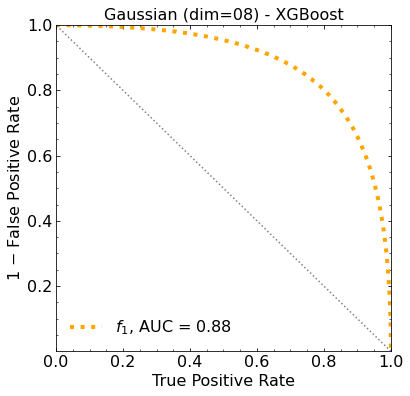

Classification score:


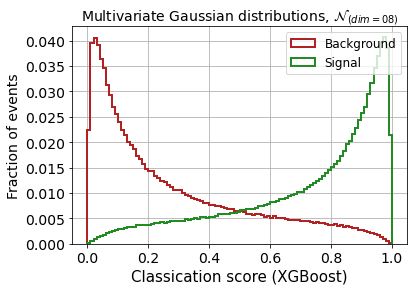

Classification score interpolation:


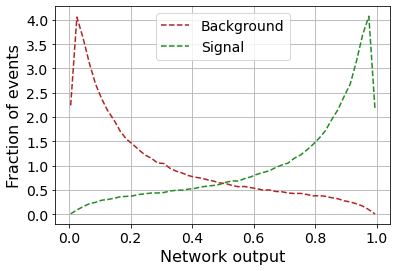


 ----------------------------------------- 

TRUE PDF LIKELIHOOD (GAUSSIANS):
B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  10000

 If  10100  =  1009    then the proposed range has to be extended
n_ensembles (actual):  9233
This may take long...


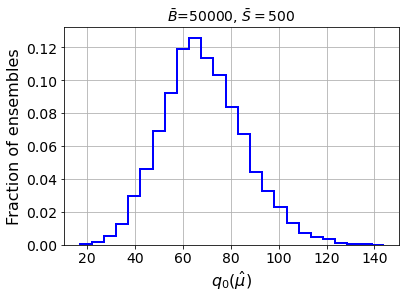

muhat mean:  1.067247915087187
median q_muhat:  67.5744166601063
Z_gaussian:  8.220365968745327

 ------------------------------------ 

MACHINE-LEARNED LIKELIHOOD
B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  10000

 If  10100  =  1009    then the proposed range has to be extended
n_ensembles (actual):  9233

 This may take long... 



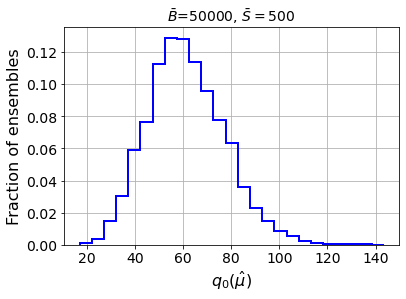

muhat mean:  1.0383948879020903
median q_muhat:  60.208709272332044
Z_XG:  7.759427122689667

 ----------------------------------------- 

Working points, counting over 1 bin:
S_expected =  500
WP: 0     S/B**0.5=  2.23606797749979
WP:  0.25     S/B**0.5=  3.221686398076239
WP:  0.5     S/B**0.5=  4.009579364157434
WP:  0.75     S/B**0.5=  4.9187069789766005
------------------------


In [55]:
dim=8

#######################
# generate the events #
#######################
    
background_X_1 = np.random.normal(-epsilon,1,N)
background_X_2 = np.random.normal(-epsilon,1,N)
background_X_3 = np.random.normal(-epsilon,1,N)
background_X_4 = np.random.normal(-epsilon,1,N)
background_X_5 = np.random.normal(-epsilon,1,N)
background_X_6 = np.random.normal(-epsilon,1,N)
background_X_7 = np.random.normal(-epsilon,1,N)
background_X_8 = np.random.normal(-epsilon,1,N)
    
signal_X_1 = np.random.normal(epsilon,1,N)
signal_X_2 = np.random.normal(epsilon,1,N)
signal_X_3 = np.random.normal(epsilon,1,N)
signal_X_4 = np.random.normal(epsilon,1,N)
signal_X_5 = np.random.normal(epsilon,1,N)
signal_X_6 = np.random.normal(epsilon,1,N)
signal_X_7 = np.random.normal(epsilon,1,N)
signal_X_8 = np.random.normal(epsilon,1,N)

dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))
dim4 = np.concatenate((background_X_4,signal_X_4))
dim5 = np.concatenate((background_X_5,signal_X_5))
dim6 = np.concatenate((background_X_6,signal_X_6))
dim7 = np.concatenate((background_X_7,signal_X_7))
dim8 = np.concatenate((background_X_8,signal_X_8))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['dim4'] = dim4.reshape(-1)
df['dim5'] = dim5.reshape(-1)
df['dim6'] = dim6.reshape(-1)
df['dim7'] = dim7.reshape(-1)
df['dim8'] = dim8.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2','dim3','dim4','dim5','dim6','dim7','dim8']].values 
Y_gauss = df[['Y']].values

X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss, Y_gauss, test_size=0.5)


print(X_gauss_train.shape)
print(Y_gauss_train.shape)
print(X_gauss_val.shape)
print(Y_gauss_val.shape)


# PLOT (only 1st feature) to visualize the data
X_gauss_val_SM = []
X_gauss_val_NP = []

for i in range(len(Y_gauss_val)):
    if Y_gauss_val[i] ==0:
        X_gauss_val_SM.append(X_gauss_val[i].tolist())
    else:
        X_gauss_val_NP.append(X_gauss_val[i].tolist())    


X_gauss_val_SM = np.array(X_gauss_val_SM)
X_gauss_val_NP = np.array(X_gauss_val_NP)


weights = np.ones_like(X_gauss_val_SM[:,0])/float(len(X_gauss_val_SM[:,0]))
plt.hist(X_gauss_val_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_val_NP[:,0])/float(len(X_gauss_val_NP[:,0]))
plt.hist(X_gauss_val_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  




#######################
# CLASSIFIER: XGBoost #
#######################

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_gauss_train,Y_gauss_train,eval_set=[(X_gauss_train, Y_gauss_train), (X_gauss_val, Y_gauss_val)],
        eval_metric='logloss',early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_gauss_val).T[1]


# ROC
fpr_gauss_xg, tpr_gauss_xg, _ = roc_curve(Y_gauss_val, y_pred_xg)
roc_auc_xg = auc(fpr_gauss_xg, tpr_gauss_xg)

store_AUC.append(roc_auc_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_gauss_xg,1-fpr_gauss_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.title(r"Gaussian (dim=%0.2d) - XGBoost" % dim,fontsize=16)
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_val)):
    if Y_gauss_val[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('Multivariate Gaussian distributions, $\mathcal{N}_{(dim=%0.2d)}$' % dim, fontsize=14)
plt.show()





# INTERPOLATE TO USE AS p_s(x) and p_b(x) ESTIMATES

# center of each bin

binsSM_mid = []
binsNP_mid = []

for i in range(len(binsSM)-1):
    binsSM_mid.append( ((binsSM[i+1]-binsSM[i])/2)+binsSM[i] )
    
for i in range(len(binsNP)-1):
    binsNP_mid.append( ((binsNP[i+1]-binsNP[i])/2)+binsNP[i] )
    

# get the width of each bin
bin_width_SM = binsSM[1] - binsSM[0]
bin_width_NP = binsNP[1] - binsNP[0]
   
    
# Interpolation, cubic
fcubic_XG_SM = interp1d(binsSM_mid, nSM, kind='cubic')
fcubic_XG_NP = interp1d(binsNP_mid, nNP, kind='cubic')


# Normalize

def fcubic_XG_SM_norm(x):
    return fcubic_XG_SM(x)/bin_width_SM

def fcubic_XG_NP_norm(x):
    return fcubic_XG_NP(x)/bin_width_NP


print('Classification score interpolation:')
# x to plot
xnew_XG_SM = np.linspace(min(binsSM_mid), max(binsSM_mid), num=50, endpoint=True)
xnew_XG_NP = np.linspace(min(binsNP_mid), max(binsNP_mid), num=50, endpoint=True)

plt.plot(xnew_XG_SM, fcubic_XG_SM_norm(xnew_XG_SM), '--', color='firebrick', label='Background')
plt.plot(xnew_XG_NP, fcubic_XG_NP_norm(xnew_XG_NP), '--', color='forestgreen', label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Network output",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.show()

print('\n ----------------------------------------- \n')





###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

print('TRUE PDF LIKELIHOOD (GAUSSIANS):')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print('S/$\sqrt{B}$: ', SsqrtB)
print('n_ensembles (initial): ', n_ensembles)


# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected


# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break


for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))



# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######



print('This may take long...')


#############################
# NOW LETS APPLY THE METHOD #
#############################
muhat_selected_list = []
q_muhat = []

for bb in range(len(list_nums_ensembles)):

    for kk in range(list_nums_ensembles[bb]):

        # SIGNAL events in an ensemble
        NP_shuf = shuffle(X_gauss_val_NP)[:list_S_per_ensembles[bb]]

        prob_NP_given_B = [] # p_b(S_ensemble)
        prob_NP_given_S = [] # p_s(S_ensemble)

        for ll in range(len(NP_shuf)):
            prob_NP_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]-epsilon)**2 + (NP_shuf[ll,1]-epsilon)**2 + (NP_shuf[ll,2]-epsilon)**2 + (NP_shuf[ll,3]-epsilon)**2 + (NP_shuf[ll,4]-epsilon)**2 + (NP_shuf[ll,5]-epsilon)**2 + (NP_shuf[ll,6]-epsilon)**2 + (NP_shuf[ll,7]-epsilon)**2 ) ) )
            prob_NP_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]+epsilon)**2 + (NP_shuf[ll,1]+epsilon)**2 + (NP_shuf[ll,2]+epsilon)**2 + (NP_shuf[ll,3]+epsilon)**2 + (NP_shuf[ll,4]+epsilon)**2 + (NP_shuf[ll,5]+epsilon)**2 + (NP_shuf[ll,6]+epsilon)**2 + (NP_shuf[ll,7]+epsilon)**2 ) ) )


        # BACKGROUND events in an ensemble
        SM_shuf = shuffle(X_gauss_val_SM)[:list_B_per_ensembles[bb]]

        prob_SM_given_B = [] # p_b(B_ensemble)
        prob_SM_given_S = [] # p_s(B_ensemble)

        for ll in range(len(SM_shuf)):
            prob_SM_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]-epsilon)**2 + (SM_shuf[ll,1]-epsilon)**2 + (SM_shuf[ll,2]-epsilon)**2 + (SM_shuf[ll,3]-epsilon)**2 + (SM_shuf[ll,4]-epsilon)**2 + (SM_shuf[ll,5]-epsilon)**2 + (SM_shuf[ll,6]-epsilon)**2 + (SM_shuf[ll,7]-epsilon)**2 ) ) )
            prob_SM_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]+epsilon)**2 + (SM_shuf[ll,1]+epsilon)**2 + (SM_shuf[ll,2]+epsilon)**2 + (SM_shuf[ll,3]+epsilon)**2 + (SM_shuf[ll,4]+epsilon)**2 + (SM_shuf[ll,5]+epsilon)**2 + (SM_shuf[ll,6]+epsilon)**2 + (SM_shuf[ll,7]+epsilon)**2 ) ) )


        # p_b(x_ensemble) =    concatenate: p_b(B_ensemble) and p_b(S_ensemble)
        prob_x_given_B = prob_SM_given_B + prob_NP_given_B

        # p_s(x_ensemble) =    concatenate: p_s(B_ensemble) and p_s(S_ensemble)
        prob_x_given_S = prob_SM_given_S + prob_NP_given_S




        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble



        mu_hat_condition_equal_1 = []

        # grid, mu_hat is around 1
        muhat_test = np.arange(0.5, 2, 0.1).tolist()

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



        muhat_selected = 1

        # from the grid, select the mu_hat such that the condition is equal to 1
        if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 > 0:
                    muhat_selected = muhat_test[ll]
                    break


        if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 < 0:
                    muhat_selected = muhat_test[ll]
                    break


        muhat_selected_list.append(muhat_selected)



        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
plt.show()


# Finally calculate muhat_mean and Z_gaussian
muhat_mean_gaussian = np.mean(muhat_selected_list)
store_muhat_mean_gaussian.append(muhat_mean_gaussian)

# Remove nan if any
q_muhat = [x for x in q_muhat if x == x]

q_muhat_median = np.median(q_muhat)

Z_gaussian = abs(q_muhat_median)**0.5
store_Z_gaussian.append(Z_gaussian)

print('muhat mean: ', muhat_mean_gaussian)
print('median q_muhat: ', q_muhat_median)
print('Z_gaussian: ', Z_gaussian)


print('\n ------------------------------------ \n')


    
    
    
##############################
# MACHINE-LEARNED LIKELIHOOD #
##############################

print('MACHINE-LEARNED LIKELIHOOD')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)
print('n_ensembles (initial): ', n_ensembles)


# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected


# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break


for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))



# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######



print('\n This may take long... \n')


# To avoid issues
for kkk in range(len(pred_XG_NP)):
    if pred_XG_NP[kkk] < min(binsNP_mid):
        pred_XG_NP[kkk] = min(binsNP_mid)
    elif pred_XG_NP[kkk] > max(binsNP_mid):
        pred_XG_NP[kkk] = max(binsNP_mid)        

for kkk in range(len(pred_XG_SM)):
    if pred_XG_SM[kkk] < min(binsSM_mid):
        pred_XG_SM[kkk] = min(binsSM_mid)
    elif pred_XG_SM[kkk] > max(binsSM_mid):
        pred_XG_SM[kkk] = max(binsSM_mid)
        
        
        
# NOW LETS APPLY THE METHOD

muhat_selected_list = []
q_muhat = []

for bb in range(len(list_nums_ensembles)):

    for kk in range(list_nums_ensembles[bb]):

        # SIGNAL: classification score for the SIGNAL events in an ensemble
        pred_NP_shuf = np.random.choice(pred_XG_NP, list_S_per_ensembles[bb])

        # BACKGROUND: classification score for the BACKGROUND events in an ensemble
        pred_SM_shuf = np.random.choice(pred_XG_SM, list_B_per_ensembles[bb])



        # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_B = np.ndarray.tolist( fcubic_XG_SM_norm( pred_SM_shuf ) ) + np.ndarray.tolist( fcubic_XG_SM_norm( pred_NP_shuf ) )

        # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_S = np.ndarray.tolist( fcubic_XG_NP_norm( pred_SM_shuf ) ) + np.ndarray.tolist( fcubic_XG_NP_norm( pred_NP_shuf ) )





        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble



        mu_hat_condition_equal_1 = []

        # grid, mu_hat is around 1
        muhat_test = np.arange(0.5, 2, 0.1).tolist()

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



        muhat_selected = 1

        # from the grid, select the mu_hat such that the condition is equal to 1
        if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 > 0:
                    muhat_selected = muhat_test[ll]
                    break


        if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 < 0:
                    muhat_selected = muhat_test[ll]
                    break


        muhat_selected_list.append(muhat_selected)



        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
plt.show()



# Finally calculate muhat_mean and Z_gaussian
muhat_mean_XG = np.mean(muhat_selected_list)
store_muhat_mean_XG_MLL.append(muhat_mean_XG)

# Remove nan if any
q_muhat = [x for x in q_muhat if x == x]

q_muhat_median = np.median(q_muhat)

Z_XG = abs(q_muhat_median)**0.5
store_Z_XG_MLL.append(Z_XG)

print('muhat mean: ', muhat_mean_XG)
print('median q_muhat: ', q_muhat_median)
print('Z_XG: ', Z_XG)


print('\n ----------------------------------------- \n')
    
    
    
    
    
    
#######################################
# Working points, counting over 1 bin #
#######################################

print('Working points, counting over 1 bin:')

# BACKGROUND 

# number of background ensembles
B_ensembles = int(len(pred_XG_SM)/B_expected)

# shorten the number of B events so I get an integer number of ensembles
pred_XG_SM_entero = pred_XG_SM[:int(len(pred_XG_SM)/B_expected) * B_expected]

XG_SM_passWP0 = 0
XG_SM_passWP1 = 0
XG_SM_passWP2 = 0

for i in range(len(pred_XG_SM_entero)):
    if pred_XG_SM_entero[i] > WP[0]:
        XG_SM_passWP0 += 1
    if pred_XG_SM_entero[i] > WP[1]:
        XG_SM_passWP1 += 1
    if pred_XG_SM_entero[i] > WP[2]:
        XG_SM_passWP2 += 1



# SIGNAL

# number of signal ensembles
S_ensembles = int(len(pred_XG_NP)/S_expected)

# shorten the number of S events so I get an integer number of ensembles
pred_XG_NP_entero = pred_XG_NP[:int(len(pred_XG_NP)/S_expected) * S_expected]

XG_NP_passWP0 = 0
XG_NP_passWP1 = 0
XG_NP_passWP2 = 0

for i in range(len(pred_XG_NP_entero)):
    if pred_XG_NP_entero[i] > WP[0]:
        XG_NP_passWP0 += 1
    if pred_XG_NP_entero[i] > WP[1]:
        XG_NP_passWP1 += 1
    if pred_XG_NP_entero[i] > WP[2]:
        XG_NP_passWP2 += 1

Z_WP0 = ( XG_NP_passWP0 / S_ensembles ) / ( XG_SM_passWP0 / B_ensembles )**0.5
Z_WP1 = ( XG_NP_passWP1 / S_ensembles ) / ( XG_SM_passWP1 / B_ensembles )**0.5
Z_WP2 = ( XG_NP_passWP2 / S_ensembles ) / ( XG_SM_passWP2 / B_ensembles )**0.5


# save the results Z_binned after WP
SrootB_WP0.append( Z_WP0 )
SrootB_WP1.append( Z_WP1 )
SrootB_WP2.append( Z_WP2 )

print('S_expected = ', S_expected)
print('WP: 0     S/B**0.5= ', S_expected/(B_expected)**0.5)
print('WP: ', WP[0], '    S/B**0.5= ', Z_WP0 )
print('WP: ', WP[1], '    S/B**0.5= ', Z_WP1 )
print('WP: ', WP[2], '    S/B**0.5= ', Z_WP2 )
print('------------------------')

In [56]:
print('dim = ', dim)

print(roc_auc_xg)

print(muhat_mean_gaussian)
print(Z_gaussian)

print(muhat_mean_XG)
print(Z_XG)

print(Z_WP0)
print(Z_WP1)
print(Z_WP2)

dim =  8
0.88368524894415
1.067247915087187
8.220365968745327
1.0383948879020903
7.759427122689667
3.221686398076239
4.009579364157434
4.9187069789766005


In [ ]:
# To use if you dont want to run everything again. Store the previous results
store_AUC.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()

store_muhat_mean_XG_MLL.append()
store_Z_XG_MLL.append()

SrootB_WP0.append()
SrootB_WP1.append()
SrootB_WP2.append()

## Dim=9

(1000000, 9)
(1000000, 1)
(1000000, 9)
(1000000, 1)


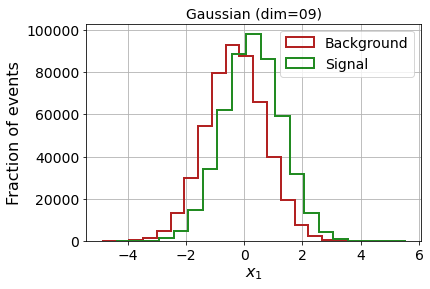

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67066	validation_1-logloss:0.67095
[1]	validation_0-logloss:0.65058	validation_1-logloss:0.65110
[2]	validation_0-logloss:0.63253	validation_1-logloss:0.63327
[3]	validation_0-logloss:0.61647	validation_1-logloss:0.61742
[4]	validation_0-logloss:0.60199	validation_1-logloss:0.60310
[5]	validation_0-logloss:0.58884	validation_1-logloss:0.59012
[6]	validation_0-logloss:0.57687	validation_1-logloss:0.57830
[7]	validation_0-logloss:0.56591	validation_1-logloss:0.56750
[8]	validation_0-logloss:0.55584	validation_1-logloss:0.55764
[9]	validation_0-logloss:0.54662	validation_1-logloss:0.54856
[10]	validation_0-logloss:0.53814	validation_1-logloss:0.54022
[11]	validation_0-logloss:0.53026	validation_1-logloss:0.53245
[12]	validation_0-logloss:0.52302	validation_1-logloss:0.52532
[13]	validation_0-logloss:0.51635	validation_1-logloss:0.51879
[14]	validation_0-logloss:0.51007	validation_1-logloss:0.51261
[15]	validation_0-logloss:0.50432	validation_1-logloss:0.50699
[1

[130]	validation_0-logloss:0.40000	validation_1-logloss:0.40714
[131]	validation_0-logloss:0.39994	validation_1-logloss:0.40710
[132]	validation_0-logloss:0.39990	validation_1-logloss:0.40707
[133]	validation_0-logloss:0.39985	validation_1-logloss:0.40703
[134]	validation_0-logloss:0.39979	validation_1-logloss:0.40700
[135]	validation_0-logloss:0.39973	validation_1-logloss:0.40697
[136]	validation_0-logloss:0.39968	validation_1-logloss:0.40694
[137]	validation_0-logloss:0.39963	validation_1-logloss:0.40690
[138]	validation_0-logloss:0.39959	validation_1-logloss:0.40688
[139]	validation_0-logloss:0.39954	validation_1-logloss:0.40685
[140]	validation_0-logloss:0.39950	validation_1-logloss:0.40682
[141]	validation_0-logloss:0.39945	validation_1-logloss:0.40680
[142]	validation_0-logloss:0.39940	validation_1-logloss:0.40677
[143]	validation_0-logloss:0.39936	validation_1-logloss:0.40675
[144]	validation_0-logloss:0.39932	validation_1-logloss:0.40673
[145]	validation_0-logloss:0.39928	valid

[259]	validation_0-logloss:0.39714	validation_1-logloss:0.40619
[260]	validation_0-logloss:0.39714	validation_1-logloss:0.40619
[261]	validation_0-logloss:0.39713	validation_1-logloss:0.40619
[262]	validation_0-logloss:0.39713	validation_1-logloss:0.40619
[263]	validation_0-logloss:0.39712	validation_1-logloss:0.40619
[264]	validation_0-logloss:0.39710	validation_1-logloss:0.40619
[265]	validation_0-logloss:0.39709	validation_1-logloss:0.40619
[266]	validation_0-logloss:0.39709	validation_1-logloss:0.40619
[267]	validation_0-logloss:0.39708	validation_1-logloss:0.40619
[268]	validation_0-logloss:0.39706	validation_1-logloss:0.40619
[269]	validation_0-logloss:0.39705	validation_1-logloss:0.40619
[270]	validation_0-logloss:0.39704	validation_1-logloss:0.40619
[271]	validation_0-logloss:0.39702	validation_1-logloss:0.40619
[272]	validation_0-logloss:0.39701	validation_1-logloss:0.40619
[273]	validation_0-logloss:0.39700	validation_1-logloss:0.40619
[274]	validation_0-logloss:0.39698	valid

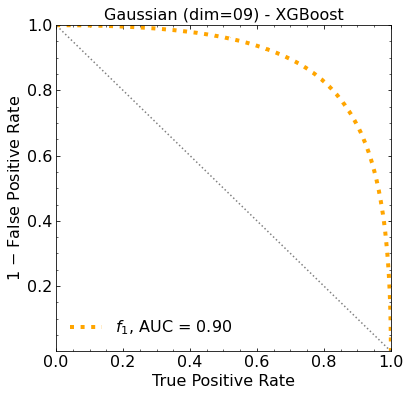

Classification score:


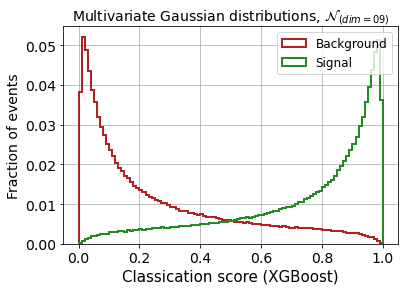

Classification score interpolation:


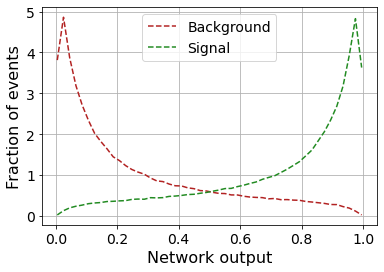


 ----------------------------------------- 

TRUE PDF LIKELIHOOD (GAUSSIANS):
B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  10000

 If  10100  =  1009    then the proposed range has to be extended
n_ensembles (actual):  9233
This may take long...


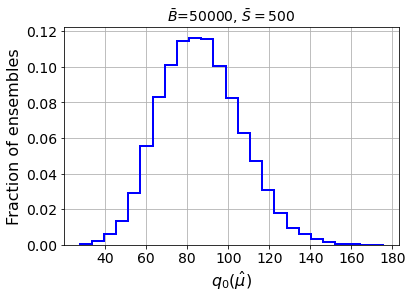

muhat mean:  1.0612910213365103
median q_muhat:  85.7074848036923
Z_gaussian:  9.257833699289067

 ------------------------------------ 

MACHINE-LEARNED LIKELIHOOD
B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  10000

 If  10100  =  1009    then the proposed range has to be extended
n_ensembles (actual):  9233

 This may take long... 



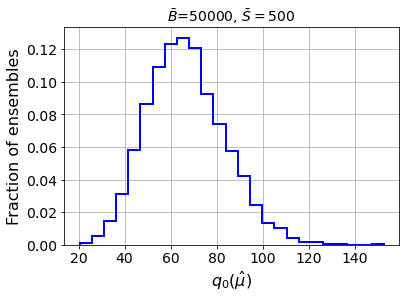

muhat mean:  1.0078630997508933
median q_muhat:  65.63657726687632
Z_XG:  8.101640405922513

 ----------------------------------------- 

Working points, counting over 1 bin:
S_expected =  500
WP: 0     S/B**0.5=  2.23606797749979
WP:  0.25     S/B**0.5=  3.3576921798165507
WP:  0.5     S/B**0.5=  4.221507798506152
WP:  0.75     S/B**0.5=  5.268454919720407
------------------------


In [73]:
dim=9

#######################
# generate the events #
#######################
    
background_X_1 = np.random.normal(-epsilon,1,N)
background_X_2 = np.random.normal(-epsilon,1,N)
background_X_3 = np.random.normal(-epsilon,1,N)
background_X_4 = np.random.normal(-epsilon,1,N)
background_X_5 = np.random.normal(-epsilon,1,N)
background_X_6 = np.random.normal(-epsilon,1,N)
background_X_7 = np.random.normal(-epsilon,1,N)
background_X_8 = np.random.normal(-epsilon,1,N)
background_X_9 = np.random.normal(-epsilon,1,N)
    
signal_X_1 = np.random.normal(epsilon,1,N)
signal_X_2 = np.random.normal(epsilon,1,N)
signal_X_3 = np.random.normal(epsilon,1,N)
signal_X_4 = np.random.normal(epsilon,1,N)
signal_X_5 = np.random.normal(epsilon,1,N)
signal_X_6 = np.random.normal(epsilon,1,N)
signal_X_7 = np.random.normal(epsilon,1,N)
signal_X_8 = np.random.normal(epsilon,1,N)
signal_X_9 = np.random.normal(epsilon,1,N)

dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))
dim4 = np.concatenate((background_X_4,signal_X_4))
dim5 = np.concatenate((background_X_5,signal_X_5))
dim6 = np.concatenate((background_X_6,signal_X_6))
dim7 = np.concatenate((background_X_7,signal_X_7))
dim8 = np.concatenate((background_X_8,signal_X_8))
dim9 = np.concatenate((background_X_9,signal_X_9))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['dim4'] = dim4.reshape(-1)
df['dim5'] = dim5.reshape(-1)
df['dim6'] = dim6.reshape(-1)
df['dim7'] = dim7.reshape(-1)
df['dim8'] = dim8.reshape(-1)
df['dim9'] = dim9.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2','dim3','dim4','dim5','dim6','dim7','dim8','dim9']].values 
Y_gauss = df[['Y']].values

X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss, Y_gauss, test_size=0.5)


print(X_gauss_train.shape)
print(Y_gauss_train.shape)
print(X_gauss_val.shape)
print(Y_gauss_val.shape)


# PLOT (only 1st feature) to visualize the data
X_gauss_val_SM = []
X_gauss_val_NP = []

for i in range(len(Y_gauss_val)):
    if Y_gauss_val[i] ==0:
        X_gauss_val_SM.append(X_gauss_val[i].tolist())
    else:
        X_gauss_val_NP.append(X_gauss_val[i].tolist())    


X_gauss_val_SM = np.array(X_gauss_val_SM)
X_gauss_val_NP = np.array(X_gauss_val_NP)


weights = np.ones_like(X_gauss_val_SM[:,0])/float(len(X_gauss_val_SM[:,0]))
plt.hist(X_gauss_val_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_val_NP[:,0])/float(len(X_gauss_val_NP[:,0]))
plt.hist(X_gauss_val_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  




#######################
# CLASSIFIER: XGBoost #
#######################

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_gauss_train,Y_gauss_train,eval_set=[(X_gauss_train, Y_gauss_train), (X_gauss_val, Y_gauss_val)],
        eval_metric='logloss',early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_gauss_val).T[1]


# ROC
fpr_gauss_xg, tpr_gauss_xg, _ = roc_curve(Y_gauss_val, y_pred_xg)
roc_auc_xg = auc(fpr_gauss_xg, tpr_gauss_xg)

store_AUC.append(roc_auc_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_gauss_xg,1-fpr_gauss_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.title(r"Gaussian (dim=%0.2d) - XGBoost" % dim,fontsize=16)
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_val)):
    if Y_gauss_val[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('Multivariate Gaussian distributions, $\mathcal{N}_{(dim=%0.2d)}$' % dim, fontsize=14)
plt.show()





# INTERPOLATE TO USE AS p_s(x) and p_b(x) ESTIMATES

# center of each bin

binsSM_mid = []
binsNP_mid = []

for i in range(len(binsSM)-1):
    binsSM_mid.append( ((binsSM[i+1]-binsSM[i])/2)+binsSM[i] )
    
for i in range(len(binsNP)-1):
    binsNP_mid.append( ((binsNP[i+1]-binsNP[i])/2)+binsNP[i] )
    

# get the width of each bin
bin_width_SM = binsSM[1] - binsSM[0]
bin_width_NP = binsNP[1] - binsNP[0]
   
    
# Interpolation, cubic
fcubic_XG_SM = interp1d(binsSM_mid, nSM, kind='cubic')
fcubic_XG_NP = interp1d(binsNP_mid, nNP, kind='cubic')


# Normalize

def fcubic_XG_SM_norm(x):
    return fcubic_XG_SM(x)/bin_width_SM

def fcubic_XG_NP_norm(x):
    return fcubic_XG_NP(x)/bin_width_NP


print('Classification score interpolation:')
# x to plot
xnew_XG_SM = np.linspace(min(binsSM_mid), max(binsSM_mid), num=50, endpoint=True)
xnew_XG_NP = np.linspace(min(binsNP_mid), max(binsNP_mid), num=50, endpoint=True)

plt.plot(xnew_XG_SM, fcubic_XG_SM_norm(xnew_XG_SM), '--', color='firebrick', label='Background')
plt.plot(xnew_XG_NP, fcubic_XG_NP_norm(xnew_XG_NP), '--', color='forestgreen', label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Network output",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.show()

print('\n ----------------------------------------- \n')





###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

print('TRUE PDF LIKELIHOOD (GAUSSIANS):')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print('S/$\sqrt{B}$: ', SsqrtB)
print('n_ensembles (initial): ', n_ensembles)


# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected


# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break


for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))



# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######



print('This may take long...')


#############################
# NOW LETS APPLY THE METHOD #
#############################
muhat_selected_list = []
q_muhat = []

for bb in range(len(list_nums_ensembles)):

    for kk in range(list_nums_ensembles[bb]):

        # SIGNAL events in an ensemble
        NP_shuf = shuffle(X_gauss_val_NP)[:list_S_per_ensembles[bb]]

        prob_NP_given_B = [] # p_b(S_ensemble)
        prob_NP_given_S = [] # p_s(S_ensemble)

        for ll in range(len(NP_shuf)):
            prob_NP_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]-epsilon)**2 + (NP_shuf[ll,1]-epsilon)**2 + (NP_shuf[ll,2]-epsilon)**2 + (NP_shuf[ll,3]-epsilon)**2 + (NP_shuf[ll,4]-epsilon)**2 + (NP_shuf[ll,5]-epsilon)**2 + (NP_shuf[ll,6]-epsilon)**2 + (NP_shuf[ll,7]-epsilon)**2 + (NP_shuf[ll,8]-epsilon)**2 ) ) )
            prob_NP_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]+epsilon)**2 + (NP_shuf[ll,1]+epsilon)**2 + (NP_shuf[ll,2]+epsilon)**2 + (NP_shuf[ll,3]+epsilon)**2 + (NP_shuf[ll,4]+epsilon)**2 + (NP_shuf[ll,5]+epsilon)**2 + (NP_shuf[ll,6]+epsilon)**2 + (NP_shuf[ll,7]+epsilon)**2 + (NP_shuf[ll,8]+epsilon)**2 ) ) )


        # BACKGROUND events in an ensemble
        SM_shuf = shuffle(X_gauss_val_SM)[:list_B_per_ensembles[bb]]

        prob_SM_given_B = [] # p_b(B_ensemble)
        prob_SM_given_S = [] # p_s(B_ensemble)

        for ll in range(len(SM_shuf)):
            prob_SM_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]-epsilon)**2 + (SM_shuf[ll,1]-epsilon)**2 + (SM_shuf[ll,2]-epsilon)**2 + (SM_shuf[ll,3]-epsilon)**2 + (SM_shuf[ll,4]-epsilon)**2 + (SM_shuf[ll,5]-epsilon)**2 + (SM_shuf[ll,6]-epsilon)**2 + (SM_shuf[ll,7]-epsilon)**2 + (SM_shuf[ll,8]-epsilon)**2 ) ) )
            prob_SM_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]+epsilon)**2 + (SM_shuf[ll,1]+epsilon)**2 + (SM_shuf[ll,2]+epsilon)**2 + (SM_shuf[ll,3]+epsilon)**2 + (SM_shuf[ll,4]+epsilon)**2 + (SM_shuf[ll,5]+epsilon)**2 + (SM_shuf[ll,6]+epsilon)**2 + (SM_shuf[ll,7]+epsilon)**2 + (SM_shuf[ll,8]+epsilon)**2 ) ) )


        # p_b(x_ensemble) =    concatenate: p_b(B_ensemble) and p_b(S_ensemble)
        prob_x_given_B = prob_SM_given_B + prob_NP_given_B

        # p_s(x_ensemble) =    concatenate: p_s(B_ensemble) and p_s(S_ensemble)
        prob_x_given_S = prob_SM_given_S + prob_NP_given_S




        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble



        mu_hat_condition_equal_1 = []

        # grid, mu_hat is around 1
        muhat_test = np.arange(0.5, 2, 0.1).tolist()

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



        muhat_selected = 1

        # from the grid, select the mu_hat such that the condition is equal to 1
        if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 > 0:
                    muhat_selected = muhat_test[ll]
                    break


        if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 < 0:
                    muhat_selected = muhat_test[ll]
                    break


        muhat_selected_list.append(muhat_selected)



        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
plt.show()


# Finally calculate muhat_mean and Z_gaussian
muhat_mean_gaussian = np.mean(muhat_selected_list)
store_muhat_mean_gaussian.append(muhat_mean_gaussian)

# Remove nan if any
q_muhat = [x for x in q_muhat if x == x]

q_muhat_median = np.median(q_muhat)

Z_gaussian = abs(q_muhat_median)**0.5
store_Z_gaussian.append(Z_gaussian)

print('muhat mean: ', muhat_mean_gaussian)
print('median q_muhat: ', q_muhat_median)
print('Z_gaussian: ', Z_gaussian)


print('\n ------------------------------------ \n')


    
    
    
##############################
# MACHINE-LEARNED LIKELIHOOD #
##############################

print('MACHINE-LEARNED LIKELIHOOD')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)
print('n_ensembles (initial): ', n_ensembles)


# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected


# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break


for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))



# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######



print('\n This may take long... \n')


# To avoid issues
for kkk in range(len(pred_XG_NP)):
    if pred_XG_NP[kkk] < min(binsNP_mid):
        pred_XG_NP[kkk] = min(binsNP_mid)
    elif pred_XG_NP[kkk] > max(binsNP_mid):
        pred_XG_NP[kkk] = max(binsNP_mid)        

for kkk in range(len(pred_XG_SM)):
    if pred_XG_SM[kkk] < min(binsSM_mid):
        pred_XG_SM[kkk] = min(binsSM_mid)
    elif pred_XG_SM[kkk] > max(binsSM_mid):
        pred_XG_SM[kkk] = max(binsSM_mid)
        
        
        
# NOW LETS APPLY THE METHOD

muhat_selected_list = []
q_muhat = []

for bb in range(len(list_nums_ensembles)):

    for kk in range(list_nums_ensembles[bb]):

        # SIGNAL: classification score for the SIGNAL events in an ensemble
        pred_NP_shuf = np.random.choice(pred_XG_NP, list_S_per_ensembles[bb])

        # BACKGROUND: classification score for the BACKGROUND events in an ensemble
        pred_SM_shuf = np.random.choice(pred_XG_SM, list_B_per_ensembles[bb])



        # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_B = np.ndarray.tolist( fcubic_XG_SM_norm( pred_SM_shuf ) ) + np.ndarray.tolist( fcubic_XG_SM_norm( pred_NP_shuf ) )

        # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_S = np.ndarray.tolist( fcubic_XG_NP_norm( pred_SM_shuf ) ) + np.ndarray.tolist( fcubic_XG_NP_norm( pred_NP_shuf ) )





        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble



        mu_hat_condition_equal_1 = []

        # grid, mu_hat is around 1
        muhat_test = np.arange(0.5, 2, 0.1).tolist()

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



        muhat_selected = 1

        # from the grid, select the mu_hat such that the condition is equal to 1
        if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 > 0:
                    muhat_selected = muhat_test[ll]
                    break


        if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 < 0:
                    muhat_selected = muhat_test[ll]
                    break


        muhat_selected_list.append(muhat_selected)



        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
plt.show()



# Finally calculate muhat_mean and Z_gaussian
muhat_mean_XG = np.mean(muhat_selected_list)
store_muhat_mean_XG_MLL.append(muhat_mean_XG)

# Remove nan if any
q_muhat = [x for x in q_muhat if x == x]

q_muhat_median = np.median(q_muhat)

Z_XG = abs(q_muhat_median)**0.5
store_Z_XG_MLL.append(Z_XG)

print('muhat mean: ', muhat_mean_XG)
print('median q_muhat: ', q_muhat_median)
print('Z_XG: ', Z_XG)


print('\n ----------------------------------------- \n')
    
    
    
    
    
    
#######################################
# Working points, counting over 1 bin #
#######################################

print('Working points, counting over 1 bin:')

# BACKGROUND 

# number of background ensembles
B_ensembles = int(len(pred_XG_SM)/B_expected)

# shorten the number of B events so I get an integer number of ensembles
pred_XG_SM_entero = pred_XG_SM[:int(len(pred_XG_SM)/B_expected) * B_expected]

XG_SM_passWP0 = 0
XG_SM_passWP1 = 0
XG_SM_passWP2 = 0

for i in range(len(pred_XG_SM_entero)):
    if pred_XG_SM_entero[i] > WP[0]:
        XG_SM_passWP0 += 1
    if pred_XG_SM_entero[i] > WP[1]:
        XG_SM_passWP1 += 1
    if pred_XG_SM_entero[i] > WP[2]:
        XG_SM_passWP2 += 1



# SIGNAL

# number of signal ensembles
S_ensembles = int(len(pred_XG_NP)/S_expected)

# shorten the number of S events so I get an integer number of ensembles
pred_XG_NP_entero = pred_XG_NP[:int(len(pred_XG_NP)/S_expected) * S_expected]

XG_NP_passWP0 = 0
XG_NP_passWP1 = 0
XG_NP_passWP2 = 0

for i in range(len(pred_XG_NP_entero)):
    if pred_XG_NP_entero[i] > WP[0]:
        XG_NP_passWP0 += 1
    if pred_XG_NP_entero[i] > WP[1]:
        XG_NP_passWP1 += 1
    if pred_XG_NP_entero[i] > WP[2]:
        XG_NP_passWP2 += 1

Z_WP0 = ( XG_NP_passWP0 / S_ensembles ) / ( XG_SM_passWP0 / B_ensembles )**0.5
Z_WP1 = ( XG_NP_passWP1 / S_ensembles ) / ( XG_SM_passWP1 / B_ensembles )**0.5
Z_WP2 = ( XG_NP_passWP2 / S_ensembles ) / ( XG_SM_passWP2 / B_ensembles )**0.5


# save the results Z_binned after WP
SrootB_WP0.append( Z_WP0 )
SrootB_WP1.append( Z_WP1 )
SrootB_WP2.append( Z_WP2 )

print('S_expected = ', S_expected)
print('WP: 0     S/B**0.5= ', S_expected/(B_expected)**0.5)
print('WP: ', WP[0], '    S/B**0.5= ', Z_WP0 )
print('WP: ', WP[1], '    S/B**0.5= ', Z_WP1 )
print('WP: ', WP[2], '    S/B**0.5= ', Z_WP2 )
print('------------------------')

In [74]:
print('dim = ', dim)

print(roc_auc_xg)

print(muhat_mean_gaussian)
print(Z_gaussian)

print(muhat_mean_XG)
print(Z_XG)

print(Z_WP0)
print(Z_WP1)
print(Z_WP2)

dim =  9
0.8962218621293583
1.0612910213365103
9.257833699289067
1.0078630997508933
8.101640405922513
3.3576921798165507
4.221507798506152
5.268454919720407


In [ ]:
# To use if you dont want to run everything again. Store the previous results
store_AUC.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()

store_muhat_mean_XG_MLL.append()
store_Z_XG_MLL.append()

SrootB_WP0.append()
SrootB_WP1.append()
SrootB_WP2.append()

## Dim=10

(1000000, 10)
(1000000, 1)
(1000000, 10)
(1000000, 1)


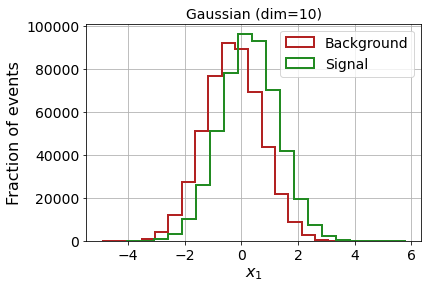

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67065	validation_1-logloss:0.67102
[1]	validation_0-logloss:0.65031	validation_1-logloss:0.65082
[2]	validation_0-logloss:0.63206	validation_1-logloss:0.63269
[3]	validation_0-logloss:0.61555	validation_1-logloss:0.61626
[4]	validation_0-logloss:0.60064	validation_1-logloss:0.60155
[5]	validation_0-logloss:0.58701	validation_1-logloss:0.58801
[6]	validation_0-logloss:0.57455	validation_1-logloss:0.57568
[7]	validation_0-logloss:0.56314	validation_1-logloss:0.56441
[8]	validation_0-logloss:0.55264	validation_1-logloss:0.55405
[9]	validation_0-logloss:0.54293	validation_1-logloss:0.54446
[10]	validation_0-logloss:0.53400	validation_1-logloss:0.53567
[11]	validation_0-logloss:0.52571	validation_1-logloss:0.52749
[12]	validation_0-logloss:0.51800	validation_1-logloss:0.51986
[13]	validation_0-logloss:0.51079	validation_1-logloss:0.51276
[14]	validation_0-logloss:0.50414	validation_1-logloss:0.50622
[15]	validation_0-logloss:0.49785	validation_1-logloss:0.50007
[1

[130]	validation_0-logloss:0.37799	validation_1-logloss:0.38461
[131]	validation_0-logloss:0.37791	validation_1-logloss:0.38455
[132]	validation_0-logloss:0.37782	validation_1-logloss:0.38449
[133]	validation_0-logloss:0.37774	validation_1-logloss:0.38443
[134]	validation_0-logloss:0.37768	validation_1-logloss:0.38438
[135]	validation_0-logloss:0.37761	validation_1-logloss:0.38434
[136]	validation_0-logloss:0.37753	validation_1-logloss:0.38429
[137]	validation_0-logloss:0.37747	validation_1-logloss:0.38425
[138]	validation_0-logloss:0.37741	validation_1-logloss:0.38420
[139]	validation_0-logloss:0.37735	validation_1-logloss:0.38416
[140]	validation_0-logloss:0.37729	validation_1-logloss:0.38411
[141]	validation_0-logloss:0.37723	validation_1-logloss:0.38407
[142]	validation_0-logloss:0.37716	validation_1-logloss:0.38403
[143]	validation_0-logloss:0.37710	validation_1-logloss:0.38400
[144]	validation_0-logloss:0.37704	validation_1-logloss:0.38396
[145]	validation_0-logloss:0.37699	valid

[259]	validation_0-logloss:0.37406	validation_1-logloss:0.38290
[260]	validation_0-logloss:0.37406	validation_1-logloss:0.38289
[261]	validation_0-logloss:0.37405	validation_1-logloss:0.38289
[262]	validation_0-logloss:0.37404	validation_1-logloss:0.38289
[263]	validation_0-logloss:0.37403	validation_1-logloss:0.38289
[264]	validation_0-logloss:0.37403	validation_1-logloss:0.38289
[265]	validation_0-logloss:0.37402	validation_1-logloss:0.38289
[266]	validation_0-logloss:0.37400	validation_1-logloss:0.38289
[267]	validation_0-logloss:0.37400	validation_1-logloss:0.38289
[268]	validation_0-logloss:0.37398	validation_1-logloss:0.38289
[269]	validation_0-logloss:0.37396	validation_1-logloss:0.38289
[270]	validation_0-logloss:0.37395	validation_1-logloss:0.38289
[271]	validation_0-logloss:0.37394	validation_1-logloss:0.38289
[272]	validation_0-logloss:0.37393	validation_1-logloss:0.38289
[273]	validation_0-logloss:0.37392	validation_1-logloss:0.38289
[274]	validation_0-logloss:0.37390	valid

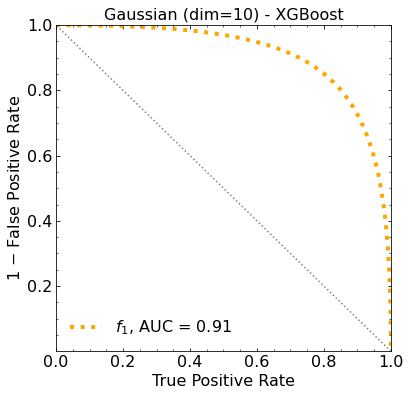

Classification score:


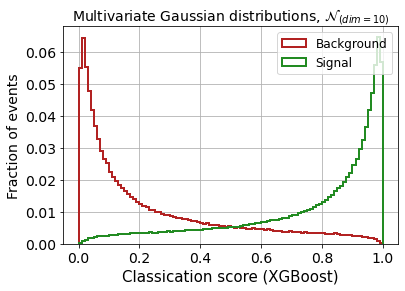

Classification score interpolation:


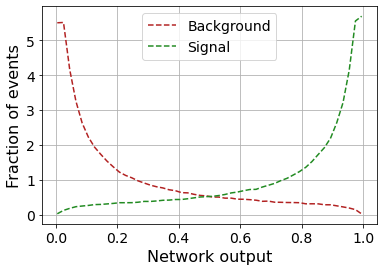


 ----------------------------------------- 

TRUE PDF LIKELIHOOD (GAUSSIANS):
B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  10000

 If  10100  =  1009    then the proposed range has to be extended
n_ensembles (actual):  9233
This may take long...


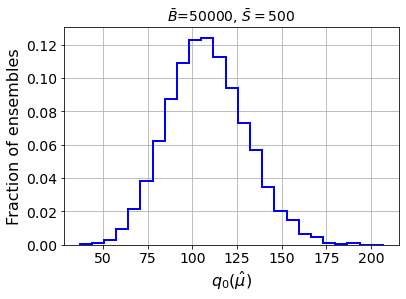

muhat mean:  1.0546951153471245
median q_muhat:  107.49020500751283
Z_gaussian:  10.367748309421522

 ------------------------------------ 

MACHINE-LEARNED LIKELIHOOD
B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  10000

 If  10100  =  1009    then the proposed range has to be extended
n_ensembles (actual):  9233

 This may take long... 



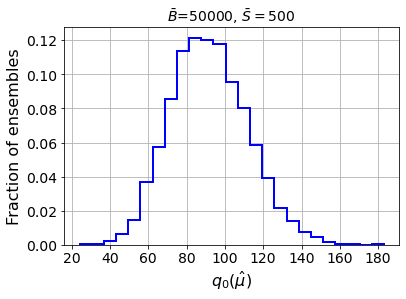

muhat mean:  1.0284414599805045
median q_muhat:  90.94133898373195
Z_XG:  9.536316845812745

 ----------------------------------------- 

Working points, counting over 1 bin:
S_expected =  500
WP: 0     S/B**0.5=  2.23606797749979
WP:  0.25     S/B**0.5=  3.5041475119962113
WP:  0.5     S/B**0.5=  4.439434598872518
WP:  0.75     S/B**0.5=  5.630188482136112
------------------------


In [59]:
dim=10

#######################
# generate the events #
#######################
    
background_X_1 = np.random.normal(-epsilon,1,N)
background_X_2 = np.random.normal(-epsilon,1,N)
background_X_3 = np.random.normal(-epsilon,1,N)
background_X_4 = np.random.normal(-epsilon,1,N)
background_X_5 = np.random.normal(-epsilon,1,N)
background_X_6 = np.random.normal(-epsilon,1,N)
background_X_7 = np.random.normal(-epsilon,1,N)
background_X_8 = np.random.normal(-epsilon,1,N)
background_X_9 = np.random.normal(-epsilon,1,N)
background_X_10 = np.random.normal(-epsilon,1,N)
    
signal_X_1 = np.random.normal(epsilon,1,N)
signal_X_2 = np.random.normal(epsilon,1,N)
signal_X_3 = np.random.normal(epsilon,1,N)
signal_X_4 = np.random.normal(epsilon,1,N)
signal_X_5 = np.random.normal(epsilon,1,N)
signal_X_6 = np.random.normal(epsilon,1,N)
signal_X_7 = np.random.normal(epsilon,1,N)
signal_X_8 = np.random.normal(epsilon,1,N)
signal_X_9 = np.random.normal(epsilon,1,N)
signal_X_10 = np.random.normal(epsilon,1,N)

dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))
dim4 = np.concatenate((background_X_4,signal_X_4))
dim5 = np.concatenate((background_X_5,signal_X_5))
dim6 = np.concatenate((background_X_6,signal_X_6))
dim7 = np.concatenate((background_X_7,signal_X_7))
dim8 = np.concatenate((background_X_8,signal_X_8))
dim9 = np.concatenate((background_X_9,signal_X_9))
dim10 = np.concatenate((background_X_10,signal_X_10))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['dim4'] = dim4.reshape(-1)
df['dim5'] = dim5.reshape(-1)
df['dim6'] = dim6.reshape(-1)
df['dim7'] = dim7.reshape(-1)
df['dim8'] = dim8.reshape(-1)
df['dim9'] = dim9.reshape(-1)
df['dim10'] = dim10.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2','dim3','dim4','dim5','dim6','dim7','dim8','dim9','dim10']].values 
Y_gauss = df[['Y']].values

X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss, Y_gauss, test_size=0.5)


print(X_gauss_train.shape)
print(Y_gauss_train.shape)
print(X_gauss_val.shape)
print(Y_gauss_val.shape)


# PLOT (only 1st feature) to visualize the data
X_gauss_val_SM = []
X_gauss_val_NP = []

for i in range(len(Y_gauss_val)):
    if Y_gauss_val[i] ==0:
        X_gauss_val_SM.append(X_gauss_val[i].tolist())
    else:
        X_gauss_val_NP.append(X_gauss_val[i].tolist())    


X_gauss_val_SM = np.array(X_gauss_val_SM)
X_gauss_val_NP = np.array(X_gauss_val_NP)


weights = np.ones_like(X_gauss_val_SM[:,0])/float(len(X_gauss_val_SM[:,0]))
plt.hist(X_gauss_val_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_val_NP[:,0])/float(len(X_gauss_val_NP[:,0]))
plt.hist(X_gauss_val_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  




#######################
# CLASSIFIER: XGBoost #
#######################

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_gauss_train,Y_gauss_train,eval_set=[(X_gauss_train, Y_gauss_train), (X_gauss_val, Y_gauss_val)],
        eval_metric='logloss',early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_gauss_val).T[1]


# ROC
fpr_gauss_xg, tpr_gauss_xg, _ = roc_curve(Y_gauss_val, y_pred_xg)
roc_auc_xg = auc(fpr_gauss_xg, tpr_gauss_xg)

store_AUC.append(roc_auc_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_gauss_xg,1-fpr_gauss_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.title(r"Gaussian (dim=%0.2d) - XGBoost" % dim,fontsize=16)
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_val)):
    if Y_gauss_val[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('Multivariate Gaussian distributions, $\mathcal{N}_{(dim=%0.2d)}$' % dim, fontsize=14)
plt.show()





# INTERPOLATE TO USE AS p_s(x) and p_b(x) ESTIMATES

# center of each bin

binsSM_mid = []
binsNP_mid = []

for i in range(len(binsSM)-1):
    binsSM_mid.append( ((binsSM[i+1]-binsSM[i])/2)+binsSM[i] )
    
for i in range(len(binsNP)-1):
    binsNP_mid.append( ((binsNP[i+1]-binsNP[i])/2)+binsNP[i] )
    

# get the width of each bin
bin_width_SM = binsSM[1] - binsSM[0]
bin_width_NP = binsNP[1] - binsNP[0]
   
    
# Interpolation, cubic
fcubic_XG_SM = interp1d(binsSM_mid, nSM, kind='cubic')
fcubic_XG_NP = interp1d(binsNP_mid, nNP, kind='cubic')


# Normalize

def fcubic_XG_SM_norm(x):
    return fcubic_XG_SM(x)/bin_width_SM

def fcubic_XG_NP_norm(x):
    return fcubic_XG_NP(x)/bin_width_NP


print('Classification score interpolation:')
# x to plot
xnew_XG_SM = np.linspace(min(binsSM_mid), max(binsSM_mid), num=50, endpoint=True)
xnew_XG_NP = np.linspace(min(binsNP_mid), max(binsNP_mid), num=50, endpoint=True)

plt.plot(xnew_XG_SM, fcubic_XG_SM_norm(xnew_XG_SM), '--', color='firebrick', label='Background')
plt.plot(xnew_XG_NP, fcubic_XG_NP_norm(xnew_XG_NP), '--', color='forestgreen', label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Network output",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.show()

print('\n ----------------------------------------- \n')





###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

print('TRUE PDF LIKELIHOOD (GAUSSIANS):')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print('S/$\sqrt{B}$: ', SsqrtB)
print('n_ensembles (initial): ', n_ensembles)


# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected


# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break


for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))



# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######



print('This may take long...')


#############################
# NOW LETS APPLY THE METHOD #
#############################
muhat_selected_list = []
q_muhat = []

for bb in range(len(list_nums_ensembles)):

    for kk in range(list_nums_ensembles[bb]):

        # SIGNAL events in an ensemble
        NP_shuf = shuffle(X_gauss_val_NP)[:list_S_per_ensembles[bb]]

        prob_NP_given_B = [] # p_b(S_ensemble)
        prob_NP_given_S = [] # p_s(S_ensemble)

        for ll in range(len(NP_shuf)):
            prob_NP_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]-epsilon)**2 + (NP_shuf[ll,1]-epsilon)**2 + (NP_shuf[ll,2]-epsilon)**2 + (NP_shuf[ll,3]-epsilon)**2 + (NP_shuf[ll,4]-epsilon)**2 + (NP_shuf[ll,5]-epsilon)**2 + (NP_shuf[ll,6]-epsilon)**2 + (NP_shuf[ll,7]-epsilon)**2 + (NP_shuf[ll,8]-epsilon)**2 + (NP_shuf[ll,9]-epsilon)**2 ) ) )
            prob_NP_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]+epsilon)**2 + (NP_shuf[ll,1]+epsilon)**2 + (NP_shuf[ll,2]+epsilon)**2 + (NP_shuf[ll,3]+epsilon)**2 + (NP_shuf[ll,4]+epsilon)**2 + (NP_shuf[ll,5]+epsilon)**2 + (NP_shuf[ll,6]+epsilon)**2 + (NP_shuf[ll,7]+epsilon)**2 + (NP_shuf[ll,8]+epsilon)**2 + (NP_shuf[ll,9]+epsilon)**2 ) ) )


        # BACKGROUND events in an ensemble
        SM_shuf = shuffle(X_gauss_val_SM)[:list_B_per_ensembles[bb]]

        prob_SM_given_B = [] # p_b(B_ensemble)
        prob_SM_given_S = [] # p_s(B_ensemble)

        for ll in range(len(SM_shuf)):
            prob_SM_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]-epsilon)**2 + (SM_shuf[ll,1]-epsilon)**2 + (SM_shuf[ll,2]-epsilon)**2 + (SM_shuf[ll,3]-epsilon)**2 + (SM_shuf[ll,4]-epsilon)**2 + (SM_shuf[ll,5]-epsilon)**2 + (SM_shuf[ll,6]-epsilon)**2 + (SM_shuf[ll,7]-epsilon)**2 + (SM_shuf[ll,8]-epsilon)**2 + (SM_shuf[ll,9]-epsilon)**2 ) ) )
            prob_SM_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]+epsilon)**2 + (SM_shuf[ll,1]+epsilon)**2 + (SM_shuf[ll,2]+epsilon)**2 + (SM_shuf[ll,3]+epsilon)**2 + (SM_shuf[ll,4]+epsilon)**2 + (SM_shuf[ll,5]+epsilon)**2 + (SM_shuf[ll,6]+epsilon)**2 + (SM_shuf[ll,7]+epsilon)**2 + (SM_shuf[ll,8]+epsilon)**2 + (SM_shuf[ll,9]+epsilon)**2 ) ) )


        # p_b(x_ensemble) =    concatenate: p_b(B_ensemble) and p_b(S_ensemble)
        prob_x_given_B = prob_SM_given_B + prob_NP_given_B

        # p_s(x_ensemble) =    concatenate: p_s(B_ensemble) and p_s(S_ensemble)
        prob_x_given_S = prob_SM_given_S + prob_NP_given_S




        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble



        mu_hat_condition_equal_1 = []

        # grid, mu_hat is around 1
        muhat_test = np.arange(0.5, 2, 0.1).tolist()

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



        muhat_selected = 1

        # from the grid, select the mu_hat such that the condition is equal to 1
        if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 > 0:
                    muhat_selected = muhat_test[ll]
                    break


        if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 < 0:
                    muhat_selected = muhat_test[ll]
                    break


        muhat_selected_list.append(muhat_selected)



        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
plt.show()


# Finally calculate muhat_mean and Z_gaussian
muhat_mean_gaussian = np.mean(muhat_selected_list)
store_muhat_mean_gaussian.append(muhat_mean_gaussian)

# Remove nan if any
q_muhat = [x for x in q_muhat if x == x]

q_muhat_median = np.median(q_muhat)

Z_gaussian = abs(q_muhat_median)**0.5
store_Z_gaussian.append(Z_gaussian)

print('muhat mean: ', muhat_mean_gaussian)
print('median q_muhat: ', q_muhat_median)
print('Z_gaussian: ', Z_gaussian)


print('\n ------------------------------------ \n')


    
    
    
##############################
# MACHINE-LEARNED LIKELIHOOD #
##############################

print('MACHINE-LEARNED LIKELIHOOD')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)
print('n_ensembles (initial): ', n_ensembles)


# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected


# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break


for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))



# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######



print('\n This may take long... \n')


# To avoid issues
for kkk in range(len(pred_XG_NP)):
    if pred_XG_NP[kkk] < min(binsNP_mid):
        pred_XG_NP[kkk] = min(binsNP_mid)
    elif pred_XG_NP[kkk] > max(binsNP_mid):
        pred_XG_NP[kkk] = max(binsNP_mid)        

for kkk in range(len(pred_XG_SM)):
    if pred_XG_SM[kkk] < min(binsSM_mid):
        pred_XG_SM[kkk] = min(binsSM_mid)
    elif pred_XG_SM[kkk] > max(binsSM_mid):
        pred_XG_SM[kkk] = max(binsSM_mid)
        
        

# NOW LETS APPLY THE METHOD

muhat_selected_list = []
q_muhat = []

for bb in range(len(list_nums_ensembles)):

    for kk in range(list_nums_ensembles[bb]):

        # SIGNAL: classification score for the SIGNAL events in an ensemble
        pred_NP_shuf = np.random.choice(pred_XG_NP, list_S_per_ensembles[bb])

        # BACKGROUND: classification score for the BACKGROUND events in an ensemble
        pred_SM_shuf = np.random.choice(pred_XG_SM, list_B_per_ensembles[bb])



        # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_B = np.ndarray.tolist( fcubic_XG_SM_norm( pred_SM_shuf ) ) + np.ndarray.tolist( fcubic_XG_SM_norm( pred_NP_shuf ) )

        # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_S = np.ndarray.tolist( fcubic_XG_NP_norm( pred_SM_shuf ) ) + np.ndarray.tolist( fcubic_XG_NP_norm( pred_NP_shuf ) )





        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble



        mu_hat_condition_equal_1 = []

        # grid, mu_hat is around 1
        muhat_test = np.arange(0.5, 2, 0.1).tolist()

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



        muhat_selected = 1

        # from the grid, select the mu_hat such that the condition is equal to 1
        if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 > 0:
                    muhat_selected = muhat_test[ll]
                    break


        if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
            for ll in range(len(mu_hat_condition_equal_1)):
                if mu_hat_condition_equal_1[ll] -1 < 0:
                    muhat_selected = muhat_test[ll]
                    break


        muhat_selected_list.append(muhat_selected)



        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
plt.show()



# Finally calculate muhat_mean and Z_gaussian
muhat_mean_XG = np.mean(muhat_selected_list)
store_muhat_mean_XG_MLL.append(muhat_mean_XG)

# Remove nan if any
q_muhat = [x for x in q_muhat if x == x]

q_muhat_median = np.median(q_muhat)

Z_XG = abs(q_muhat_median)**0.5
store_Z_XG_MLL.append(Z_XG)

print('muhat mean: ', muhat_mean_XG)
print('median q_muhat: ', q_muhat_median)
print('Z_XG: ', Z_XG)


print('\n ----------------------------------------- \n')
    
    
    
    
    
    
#######################################
# Working points, counting over 1 bin #
#######################################

print('Working points, counting over 1 bin:')

# BACKGROUND 

# number of background ensembles
B_ensembles = int(len(pred_XG_SM)/B_expected)

# shorten the number of B events so I get an integer number of ensembles
pred_XG_SM_entero = pred_XG_SM[:int(len(pred_XG_SM)/B_expected) * B_expected]

XG_SM_passWP0 = 0
XG_SM_passWP1 = 0
XG_SM_passWP2 = 0

for i in range(len(pred_XG_SM_entero)):
    if pred_XG_SM_entero[i] > WP[0]:
        XG_SM_passWP0 += 1
    if pred_XG_SM_entero[i] > WP[1]:
        XG_SM_passWP1 += 1
    if pred_XG_SM_entero[i] > WP[2]:
        XG_SM_passWP2 += 1



# SIGNAL

# number of signal ensembles
S_ensembles = int(len(pred_XG_NP)/S_expected)

# shorten the number of S events so I get an integer number of ensembles
pred_XG_NP_entero = pred_XG_NP[:int(len(pred_XG_NP)/S_expected) * S_expected]

XG_NP_passWP0 = 0
XG_NP_passWP1 = 0
XG_NP_passWP2 = 0

for i in range(len(pred_XG_NP_entero)):
    if pred_XG_NP_entero[i] > WP[0]:
        XG_NP_passWP0 += 1
    if pred_XG_NP_entero[i] > WP[1]:
        XG_NP_passWP1 += 1
    if pred_XG_NP_entero[i] > WP[2]:
        XG_NP_passWP2 += 1

Z_WP0 = ( XG_NP_passWP0 / S_ensembles ) / ( XG_SM_passWP0 / B_ensembles )**0.5
Z_WP1 = ( XG_NP_passWP1 / S_ensembles ) / ( XG_SM_passWP1 / B_ensembles )**0.5
Z_WP2 = ( XG_NP_passWP2 / S_ensembles ) / ( XG_SM_passWP2 / B_ensembles )**0.5


# save the results Z_binned after WP
SrootB_WP0.append( Z_WP0 )
SrootB_WP1.append( Z_WP1 )
SrootB_WP2.append( Z_WP2 )

print('S_expected = ', S_expected)
print('WP: 0     S/B**0.5= ', S_expected/(B_expected)**0.5)
print('WP: ', WP[0], '    S/B**0.5= ', Z_WP0 )
print('WP: ', WP[1], '    S/B**0.5= ', Z_WP1 )
print('WP: ', WP[2], '    S/B**0.5= ', Z_WP2 )
print('------------------------')

In [60]:
print('dim = ', dim)

print(roc_auc_xg)

print(muhat_mean_gaussian)
print(Z_gaussian)

print(muhat_mean_XG)
print(Z_XG)

print(Z_WP0)
print(Z_WP1)
print(Z_WP2)

dim =  10
0.9085024769053253
1.0546951153471245
10.367748309421522
1.0284414599805045
9.536316845812745
3.5041475119962113
4.439434598872518
5.630188482136112


In [ ]:
# To use if you dont want to run everything again. Store the previous results
store_AUC.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()

store_muhat_mean_XG_MLL.append()
store_Z_XG_MLL.append()

SrootB_WP0.append()
SrootB_WP1.append()
SrootB_WP2.append()

In [5]:
# FINAL STORED VALUES
print(store_AUC)

print(store_muhat_mean_gaussian)
print(store_Z_gaussian)

print(store_muhat_mean_XG_MLL)
print(store_Z_XG_MLL)

print(SrootB_WP0)
print(SrootB_WP1)
print(SrootB_WP2)

[0.6638915006110954, 0.725416446010977, 0.7684496798444643, 0.801921440479743, 0.8280846316635674, 0.8493588557956869, 0.8680980324323412, 0.88368524894415, 0.8962218621293583, 0.9085024769053253]
[1.0405826925159751, 1.0691107982237624, 1.0953536228744718, 1.077948662406585, 1.0331094985378533, 0.9999133542727173, 1.0299902523556805, 1.067247915087187, 1.0612910213365103, 1.0546951153471245]
[2.6371406343481856, 3.218752633224178, 3.9506217337341214, 4.567249108228731, 5.177837571998782, 6.025465452746964, 7.016158404816354, 8.220365968745327, 9.257833699289067, 10.367748309421522]
[0.9941622441243365, 1.0375392613451748, 1.0485757608577928, 1.042499729232102, 1.0362828982995775, 1.0304234809920934, 1.0302285281057078, 1.0383948879020903, 1.0262753167984402, 1.0284414599805045]
[2.474150269287416, 3.13174702981239, 3.753966425149022, 4.38190733417871, 5.104566455059247, 5.7785286596196554, 6.642583201059078, 7.759427122689667, 8.485023531821303, 9.536316845812745]
[2.267044600074433, 

In [4]:
# FINAL STORED VALUES
# To use if you dont want to run everything again. Its the previous results

store_AUC = [0.6638915006110954, 0.725416446010977, 0.7684496798444643, 0.801921440479743, 0.8280846316635674, 0.8493588557956869, 0.8680980324323412, 0.88368524894415, 0.8962218621293583, 0.9085024769053253]

store_muhat_mean_gaussian = [1.0405826925159751, 1.0691107982237624, 1.0953536228744718, 1.077948662406585, 1.0331094985378533, 0.9999133542727173, 1.0299902523556805, 1.067247915087187, 1.0612910213365103, 1.0546951153471245]
store_Z_gaussian = [2.6371406343481856, 3.218752633224178, 3.9506217337341214, 4.567249108228731, 5.177837571998782, 6.025465452746964, 7.016158404816354, 8.220365968745327, 9.257833699289067, 10.367748309421522]

store_muhat_mean_XG_MLL = [0.9941622441243365, 1.0375392613451748, 1.0485757608577928, 1.042499729232102, 1.0362828982995775, 1.0304234809920934, 1.0302285281057078, 1.0383948879020903, 1.0262753167984402, 1.0284414599805045]
store_Z_XG_MLL = [2.474150269287416, 3.13174702981239, 3.753966425149022, 4.38190733417871, 5.104566455059247, 5.7785286596196554, 6.642583201059078, 7.759427122689667, 8.485023531821303, 9.536316845812745]

SrootB_WP0 = [2.267044600074433, 2.3796724420276565, 2.508664062521924, 2.6501612122414833, 2.7934384898886457, 2.93234491428441, 3.078903503895336, 3.221686398076239, 3.3576921798165507, 3.5041475119962113]
SrootB_WP1 = [2.225532310946481, 2.560015384615385, 2.8444554292488755, 3.097421499100125, 3.340172178933246, 3.5631600501290634, 3.7920854651140865, 4.009579364157434, 4.221507798506152, 4.439434598872518]
SrootB_WP2 =[1.0575716153065058, 2.0630879237466377, 2.7485853598268957, 3.2959269619417806, 3.76635027415483, 4.168735417038943, 4.575809532266483, 4.9187069789766005, 5.322561630214522, 5.630188482136112]

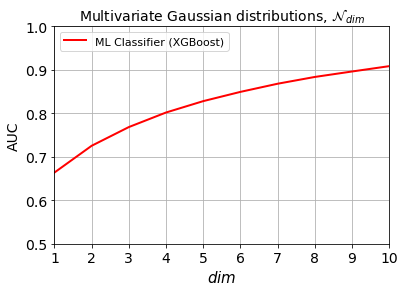

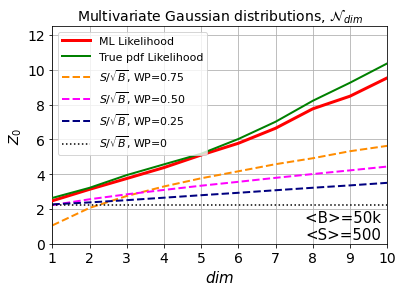

In [5]:
#########
# PLOTS #
#########

dim = [1,2,3,4,5,6,7,8,9,10]

plt.figure()
lw = 2

plt.plot(dim, store_AUC, '-', color='red', lw=lw, label=r'ML Classifier (XGBoost)')

plt.xlim([1, 10])
plt.ylim([0.5, 1.0])
#plt.xscale('log')
#plt.axes().set_aspect(0.7)
plt.xlabel('$dim$', fontsize=15)
plt.ylabel('AUC', fontsize=14)
plt.title('Multivariate Gaussian distributions, $\mathcal{N}_{dim}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend(loc="upper left", fontsize=11)
plt.savefig('images/' + 'AUCgaussians.pdf', format="pdf", bbox_inches="tight")
plt.show()




plt.figure()
lw = 2

plt.plot(dim, store_Z_XG_MLL, '-', color='red', lw=3, label=r'ML Likelihood' ,zorder=5)
plt.plot(dim, store_Z_gaussian, '-', color='green', lw=lw, label=r'True pdf Likelihood' ,zorder=5)
plt.plot(dim, SrootB_WP2, '--', color='darkorange', lw=lw, label=r'$S/\sqrt{B}$, WP=%0.2f' % WP[2] )
plt.plot(dim, SrootB_WP1, '--', color='magenta', lw=lw, label=r'$S/\sqrt{B}$, WP=%0.2f' % WP[1] )
plt.plot(dim, SrootB_WP0, '--', color='navy', lw=lw, label=r'$S/\sqrt{B}$, WP=%0.2f' % WP[0] )

plt.xlim([1, 10])
plt.ylim([0., 12.5])
#plt.yscale('log')
plt.text(7.8, 0.25, '<B>=50k \n<S>=500', fontsize = 15)
plt.xlabel('$dim$', fontsize=15)
plt.ylabel('$Z_{0}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axhline(y=SsqrtB, color='black', linestyle=':', label=r'$S/\sqrt{B}$, WP=0')
plt.grid()
plt.title('Multivariate Gaussian distributions, $\mathcal{N}_{dim}$', fontsize=14)
plt.legend(loc="upper left", fontsize=11, handlelength=2.5)
plt.savefig('images/' + 'gaussians50kS2.pdf', format="pdf", bbox_inches="tight")
plt.show()



### Optimal Classifier (Neyman-Pearson)


 ##################################### 
 DATA: Gaussians Dim: 1
 ##################################### 



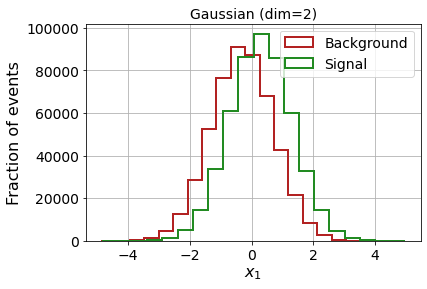

OPTIMAL (Neyman-Pearson) with true pdfs: 



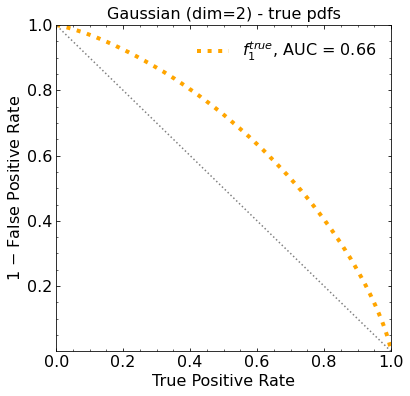


 Classification score: (o_x)


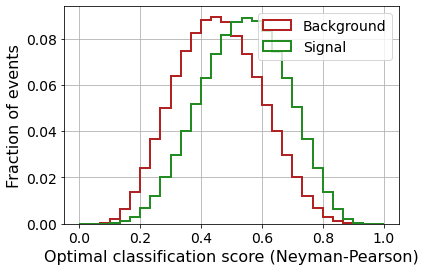


 ##################################### 
 DATA: Gaussians Dim: 2
 ##################################### 



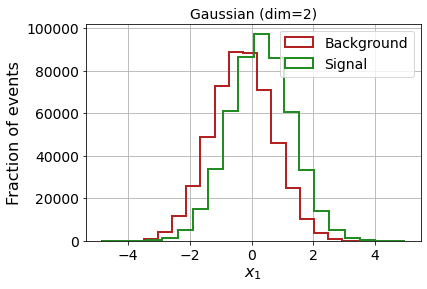

OPTIMAL (Neyman-Pearson) with true pdfs: 



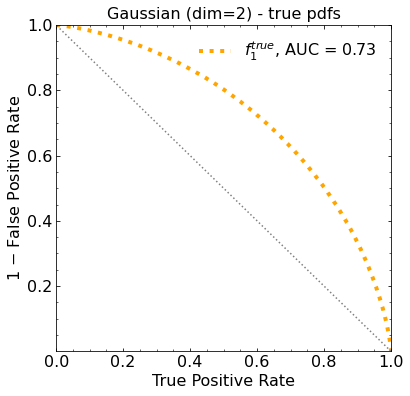


 Classification score: (o_x)


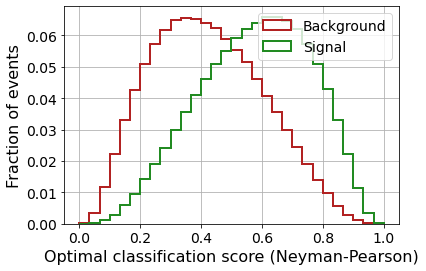


 ##################################### 
 DATA: Gaussians Dim: 3
 ##################################### 



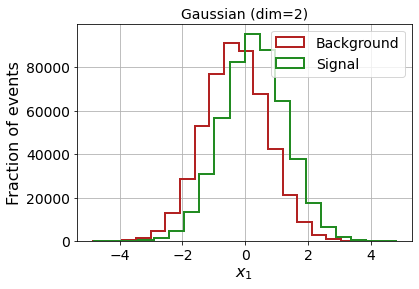

OPTIMAL (Neyman-Pearson) with true pdfs: 



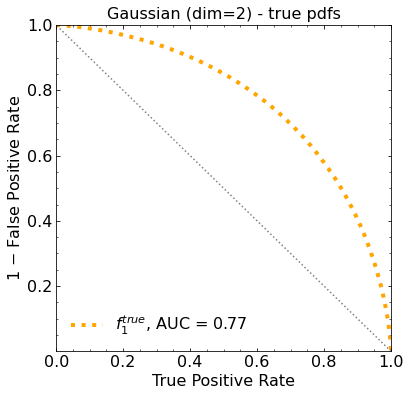


 Classification score: (o_x)


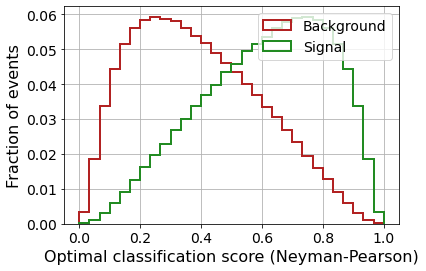


 ##################################### 
 DATA: Gaussians Dim: 4
 ##################################### 



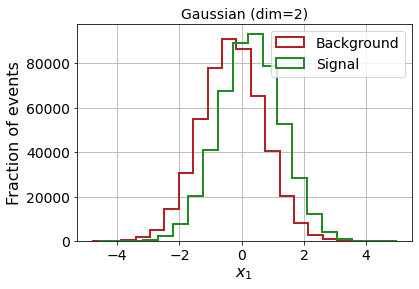

OPTIMAL (Neyman-Pearson) with true pdfs: 



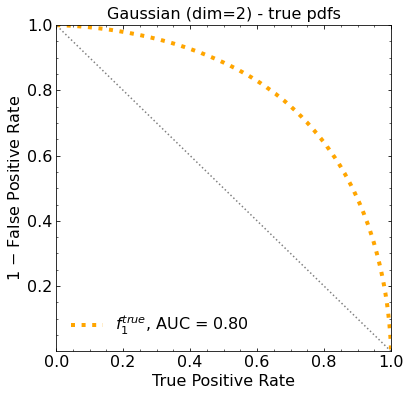


 Classification score: (o_x)


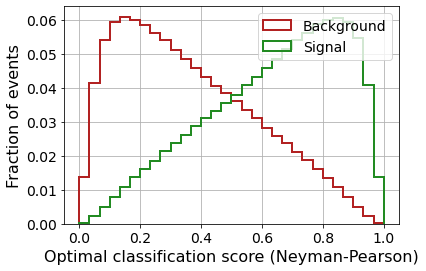


 ##################################### 
 DATA: Gaussians Dim: 5
 ##################################### 



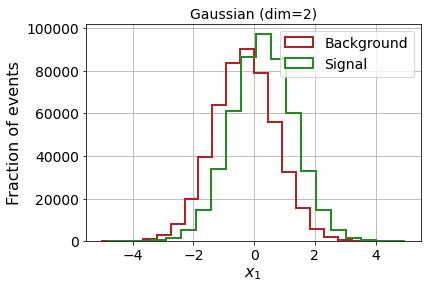

OPTIMAL (Neyman-Pearson) with true pdfs: 



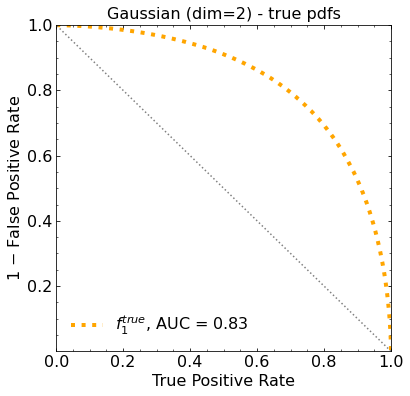


 Classification score: (o_x)


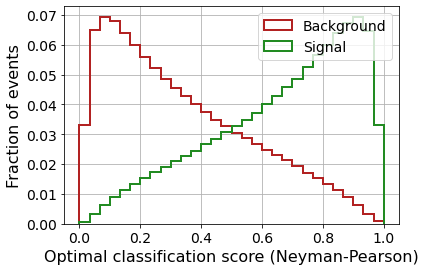


 ##################################### 
 DATA: Gaussians Dim: 6
 ##################################### 



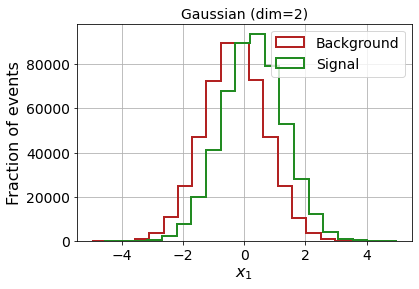

OPTIMAL (Neyman-Pearson) with true pdfs: 



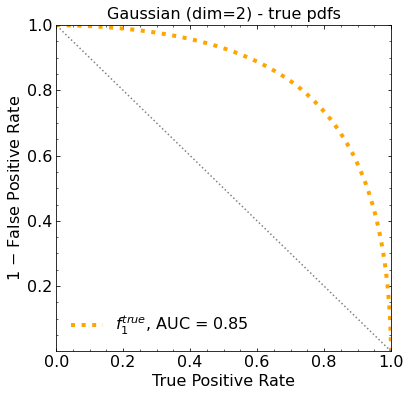


 Classification score: (o_x)


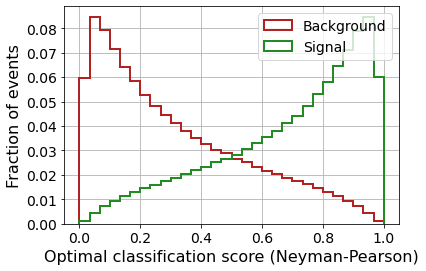


 ##################################### 
 DATA: Gaussians Dim: 7
 ##################################### 



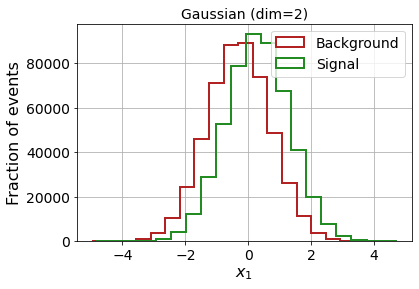

OPTIMAL (Neyman-Pearson) with true pdfs: 



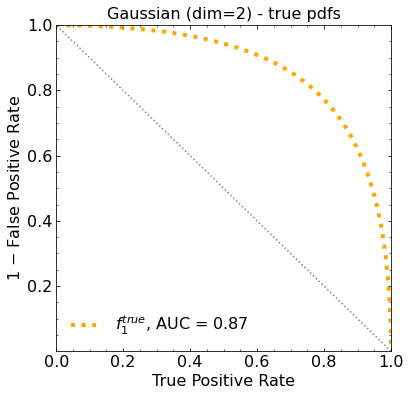


 Classification score: (o_x)


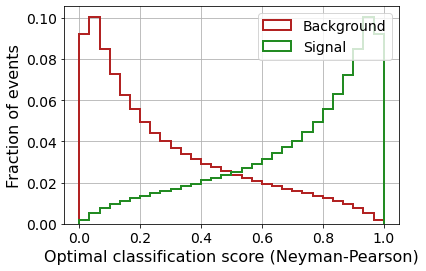


 ##################################### 
 DATA: Gaussians Dim: 8
 ##################################### 



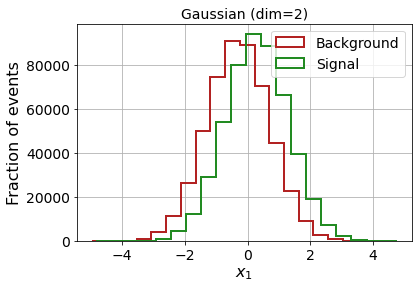

OPTIMAL (Neyman-Pearson) with true pdfs: 



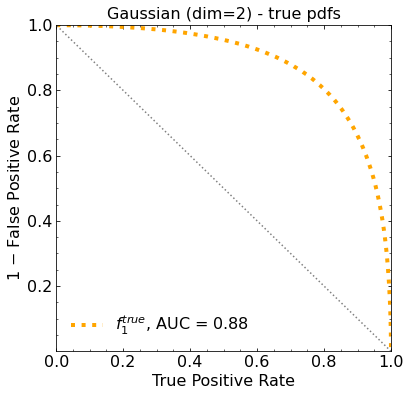


 Classification score: (o_x)


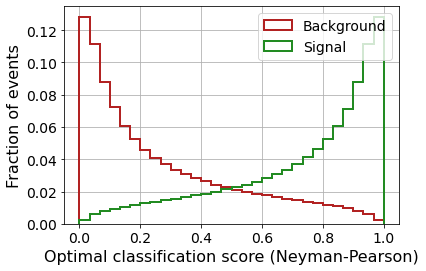


 ##################################### 
 DATA: Gaussians Dim: 9
 ##################################### 



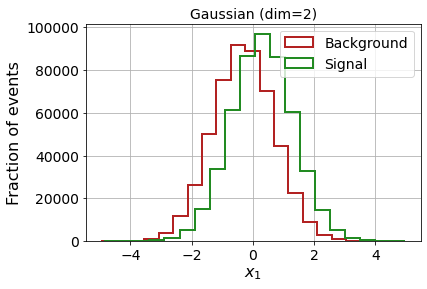

OPTIMAL (Neyman-Pearson) with true pdfs: 



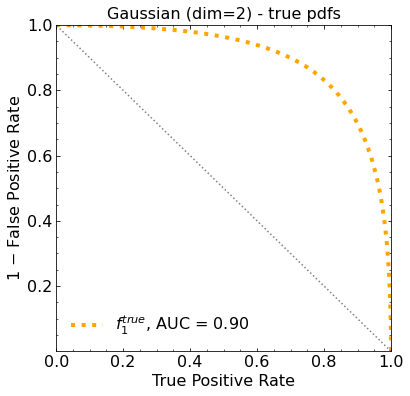


 Classification score: (o_x)


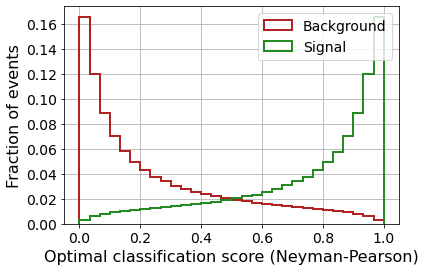


 ##################################### 
 DATA: Gaussians Dim: 10
 ##################################### 



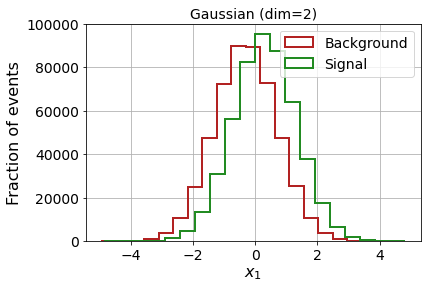

OPTIMAL (Neyman-Pearson) with true pdfs: 



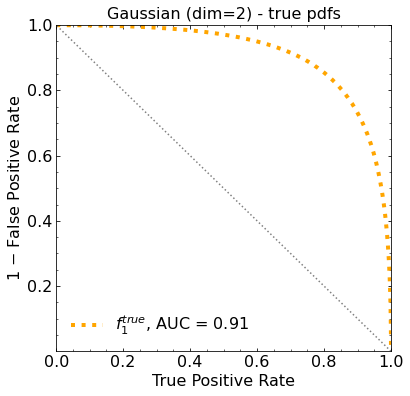


 Classification score: (o_x)


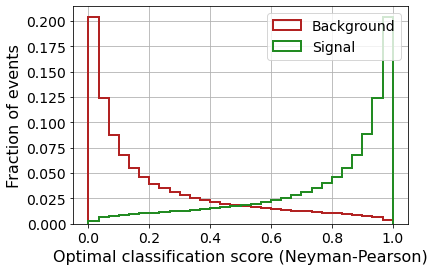

In [21]:
dim = [1,2,3,4,5,6,7,8,9,10]

store_AUC_optimalNP = []


#######################
# generate the events #
#######################

background_X_1 = np.random.normal(-epsilon,1,N)
background_X_2 = np.random.normal(-epsilon,1,N)
background_X_3 = np.random.normal(-epsilon,1,N)
background_X_4 = np.random.normal(-epsilon,1,N)
background_X_5 = np.random.normal(-epsilon,1,N)
background_X_6 = np.random.normal(-epsilon,1,N)
background_X_7 = np.random.normal(-epsilon,1,N)
background_X_8 = np.random.normal(-epsilon,1,N)
background_X_9 = np.random.normal(-epsilon,1,N)
background_X_10 = np.random.normal(-epsilon,1,N)

signal_X_1 = np.random.normal(epsilon,1,N)
signal_X_2 = np.random.normal(epsilon,1,N)
signal_X_3 = np.random.normal(epsilon,1,N)
signal_X_4 = np.random.normal(epsilon,1,N)
signal_X_5 = np.random.normal(epsilon,1,N)
signal_X_6 = np.random.normal(epsilon,1,N)
signal_X_7 = np.random.normal(epsilon,1,N)
signal_X_8 = np.random.normal(epsilon,1,N)
signal_X_9 = np.random.normal(epsilon,1,N)
signal_X_10 = np.random.normal(epsilon,1,N)

dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))
dim4 = np.concatenate((background_X_4,signal_X_4))
dim5 = np.concatenate((background_X_5,signal_X_5))
dim6 = np.concatenate((background_X_6,signal_X_6))
dim7 = np.concatenate((background_X_7,signal_X_7))
dim8 = np.concatenate((background_X_8,signal_X_8))
dim9 = np.concatenate((background_X_9,signal_X_9))
dim10 = np.concatenate((background_X_10,signal_X_10))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['dim4'] = dim4.reshape(-1)
df['dim5'] = dim5.reshape(-1)
df['dim6'] = dim6.reshape(-1)
df['dim7'] = dim7.reshape(-1)
df['dim8'] = dim8.reshape(-1)
df['dim9'] = dim9.reshape(-1)
df['dim10'] = dim10.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

dim_dic = ['dim1','dim2','dim3','dim4','dim5','dim6','dim7','dim8','dim9','dim10']



for k in range(len(dim)):
    
    print('\n ##################################### ')
    print(' DATA: Gaussians Dim:', dim[k])
    print(' ##################################### \n')
    

    X_gauss = df[dim_dic[:(k+1)]].values 
    Y_gauss = df[['Y']].values



    X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss, Y_gauss, test_size=0.5)
    
    
    
    
    # PLOT to visualize the data
    X_gauss_val_SM = []
    X_gauss_val_NP = []

    for i in range(len(Y_gauss_val)):
        if Y_gauss_val[i] ==0:
            X_gauss_val_SM.append(X_gauss_val[i].tolist())
        else:
            X_gauss_val_NP.append(X_gauss_val[i].tolist())    

            
    X_gauss_val_SM = np.array(X_gauss_val_SM)
    X_gauss_val_NP = np.array(X_gauss_val_NP)


    weights = np.ones_like(X_gauss_val_SM[:,0])/float(len(X_gauss_val_SM[:,0]))
    plt.hist(X_gauss_val_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

    weights = np.ones_like(X_gauss_val_NP[:,0])/float(len(X_gauss_val_NP[:,0]))
    plt.hist(X_gauss_val_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$x_1$",fontsize=16)
    plt.ylabel("Fraction of events",fontsize=16)
    plt.grid()
    plt.legend(fontsize=14)
    plt.title(r"Gaussian (dim=2)",fontsize=14)
    plt.show()  

    
    
    
    #######################################################
    # CLASSIFIER: OPTIMAL (Neyman-Pearson) with true pdfs #
    #######################################################
    
    print('OPTIMAL (Neyman-Pearson) with true pdfs: \n')
    
    o_x = []
        
        
    if dim[k]==1:
        for ll in range(len(X_gauss)):
            ps = (1./(2*math.pi)**0.5) * math.exp(-0.5*( (X_gauss[ll,0]-epsilon)**2 ) )
            pb = (1./(2*math.pi)**0.5) * math.exp(-0.5*( (X_gauss[ll,0]+epsilon)**2 ) )
            o_x.append( ps / (ps + pb) )
    elif dim[k]==2:
        for ll in range(len(X_gauss)):
            ps = (1./(2*math.pi)**0.5) * math.exp(-0.5*( (X_gauss[ll,0]-epsilon)**2 + (X_gauss[ll,1]-epsilon)**2 ) )
            pb = (1./(2*math.pi)**0.5) * math.exp(-0.5*( (X_gauss[ll,0]+epsilon)**2 + (X_gauss[ll,1]+epsilon)**2 ) )
            o_x.append( ps / (ps + pb) )
    elif dim[k]==3:
        for ll in range(len(X_gauss)):
            ps = (1./(2*math.pi)**0.5) * math.exp(-0.5*( (X_gauss[ll,0]-epsilon)**2 + (X_gauss[ll,1]-epsilon)**2 + (X_gauss[ll,2]-epsilon)**2 ) )
            pb = (1./(2*math.pi)**0.5) * math.exp(-0.5*( (X_gauss[ll,0]+epsilon)**2 + (X_gauss[ll,1]+epsilon)**2 + (X_gauss[ll,2]+epsilon)**2 ) )
            o_x.append( ps / (ps + pb) )
    elif dim[k]==4:
        for ll in range(len(X_gauss)):
            ps = (1./(2*math.pi)**0.5) * math.exp(-0.5*( (X_gauss[ll,0]-epsilon)**2 + (X_gauss[ll,1]-epsilon)**2 + (X_gauss[ll,2]-epsilon)**2 + (X_gauss[ll,3]-epsilon)**2 ) )
            pb = (1./(2*math.pi)**0.5) * math.exp(-0.5*( (X_gauss[ll,0]+epsilon)**2 + (X_gauss[ll,1]+epsilon)**2 + (X_gauss[ll,2]+epsilon)**2 + (X_gauss[ll,3]+epsilon)**2 ) )
            o_x.append( ps / (ps + pb) )
    elif dim[k]==5:
        for ll in range(len(X_gauss)):
            ps = (1./(2*math.pi)**0.5) * math.exp(-0.5*( (X_gauss[ll,0]-epsilon)**2 + (X_gauss[ll,1]-epsilon)**2 + (X_gauss[ll,2]-epsilon)**2 + (X_gauss[ll,3]-epsilon)**2 + (X_gauss[ll,4]-epsilon)**2 ) )
            pb = (1./(2*math.pi)**0.5) * math.exp(-0.5*( (X_gauss[ll,0]+epsilon)**2 + (X_gauss[ll,1]+epsilon)**2 + (X_gauss[ll,2]+epsilon)**2 + (X_gauss[ll,3]+epsilon)**2 + (X_gauss[ll,4]+epsilon)**2 ) )
            o_x.append( ps / (ps + pb) )
    elif dim[k]==6:
        for ll in range(len(X_gauss)):
            ps = (1./(2*math.pi)**0.5) * math.exp(-0.5*( (X_gauss[ll,0]-epsilon)**2 + (X_gauss[ll,1]-epsilon)**2 + (X_gauss[ll,2]-epsilon)**2 + (X_gauss[ll,3]-epsilon)**2 + (X_gauss[ll,4]-epsilon)**2 + (X_gauss[ll,5]-epsilon)**2 ) )
            pb = (1./(2*math.pi)**0.5) * math.exp(-0.5*( (X_gauss[ll,0]+epsilon)**2 + (X_gauss[ll,1]+epsilon)**2 + (X_gauss[ll,2]+epsilon)**2 + (X_gauss[ll,3]+epsilon)**2 + (X_gauss[ll,4]+epsilon)**2 + (X_gauss[ll,5]+epsilon)**2 ) )
            o_x.append( ps / (ps + pb) )
    elif dim[k]==7:
        for ll in range(len(X_gauss)):
            ps = (1./(2*math.pi)**0.5) * math.exp(-0.5*( (X_gauss[ll,0]-epsilon)**2 + (X_gauss[ll,1]-epsilon)**2 + (X_gauss[ll,2]-epsilon)**2 + (X_gauss[ll,3]-epsilon)**2 + (X_gauss[ll,4]-epsilon)**2 + (X_gauss[ll,5]-epsilon)**2 + (X_gauss[ll,6]-epsilon)**2 ) )
            pb = (1./(2*math.pi)**0.5) * math.exp(-0.5*( (X_gauss[ll,0]+epsilon)**2 + (X_gauss[ll,1]+epsilon)**2 + (X_gauss[ll,2]+epsilon)**2 + (X_gauss[ll,3]+epsilon)**2 + (X_gauss[ll,4]+epsilon)**2 + (X_gauss[ll,5]+epsilon)**2 + (X_gauss[ll,6]+epsilon)**2 ) )
            o_x.append( ps / (ps + pb) )
    elif dim[k]==8:
        for ll in range(len(X_gauss)):
            ps = (1./(2*math.pi)**0.5) * math.exp(-0.5*( (X_gauss[ll,0]-epsilon)**2 + (X_gauss[ll,1]-epsilon)**2 + (X_gauss[ll,2]-epsilon)**2 + (X_gauss[ll,3]-epsilon)**2 + (X_gauss[ll,4]-epsilon)**2 + (X_gauss[ll,5]-epsilon)**2 + (X_gauss[ll,6]-epsilon)**2 + (X_gauss[ll,7]-epsilon)**2 ) )
            pb = (1./(2*math.pi)**0.5) * math.exp(-0.5*( (X_gauss[ll,0]+epsilon)**2 + (X_gauss[ll,1]+epsilon)**2 + (X_gauss[ll,2]+epsilon)**2 + (X_gauss[ll,3]+epsilon)**2 + (X_gauss[ll,4]+epsilon)**2 + (X_gauss[ll,5]+epsilon)**2 + (X_gauss[ll,6]+epsilon)**2 + (X_gauss[ll,7]+epsilon)**2 ) )
            o_x.append( ps / (ps + pb) )
    elif dim[k]==9:
        for ll in range(len(X_gauss)):
            ps = (1./(2*math.pi)**0.5) * math.exp(-0.5*( (X_gauss[ll,0]-epsilon)**2 + (X_gauss[ll,1]-epsilon)**2 + (X_gauss[ll,2]-epsilon)**2 + (X_gauss[ll,3]-epsilon)**2 + (X_gauss[ll,4]-epsilon)**2 + (X_gauss[ll,5]-epsilon)**2 + (X_gauss[ll,6]-epsilon)**2 + (X_gauss[ll,7]-epsilon)**2 + (X_gauss[ll,8]-epsilon)**2 ) )
            pb = (1./(2*math.pi)**0.5) * math.exp(-0.5*( (X_gauss[ll,0]+epsilon)**2 + (X_gauss[ll,1]+epsilon)**2 + (X_gauss[ll,2]+epsilon)**2 + (X_gauss[ll,3]+epsilon)**2 + (X_gauss[ll,4]+epsilon)**2 + (X_gauss[ll,5]+epsilon)**2 + (X_gauss[ll,6]+epsilon)**2 + (X_gauss[ll,7]+epsilon)**2 + (X_gauss[ll,8]+epsilon)**2 ) )
            o_x.append( ps / (ps + pb) )
    elif dim[k]==10:
        for ll in range(len(X_gauss)):
            ps = (1./(2*math.pi)**0.5) * math.exp(-0.5*( (X_gauss[ll,0]-epsilon)**2 + (X_gauss[ll,1]-epsilon)**2 + (X_gauss[ll,2]-epsilon)**2 + (X_gauss[ll,3]-epsilon)**2 + (X_gauss[ll,4]-epsilon)**2 + (X_gauss[ll,5]-epsilon)**2 + (X_gauss[ll,6]-epsilon)**2 + (X_gauss[ll,7]-epsilon)**2 + (X_gauss[ll,8]-epsilon)**2 + (X_gauss[ll,9]-epsilon)**2 ) )
            pb = (1./(2*math.pi)**0.5) * math.exp(-0.5*( (X_gauss[ll,0]+epsilon)**2 + (X_gauss[ll,1]+epsilon)**2 + (X_gauss[ll,2]+epsilon)**2 + (X_gauss[ll,3]+epsilon)**2 + (X_gauss[ll,4]+epsilon)**2 + (X_gauss[ll,5]+epsilon)**2 + (X_gauss[ll,6]+epsilon)**2 + (X_gauss[ll,7]+epsilon)**2 + (X_gauss[ll,8]+epsilon)**2 + (X_gauss[ll,9]+epsilon)**2 ) )
            o_x.append( ps / (ps + pb) )


    o_x = np.array(o_x).reshape(len(o_x), 1)
    

    # ROC
    fpr_gauss_true, tpr_gauss_true, _ = roc_curve(Y_gauss, o_x)
    roc_auc_true = auc(fpr_gauss_true, tpr_gauss_true)

    store_AUC_optimalNP.append(roc_auc_true)
    

    

    # PLOT THE ROC WITH AUC
    fig = plt.figure(figsize=(6,6))
    gs = gridspec.GridSpec(1, 1) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax0.minorticks_on()


    plt.plot(tpr_gauss_true,1-fpr_gauss_true,label="$f_{1}^{true}$, AUC = %0.2f" % roc_auc_true,color="orange",ls=":",lw=4)
    plt.plot([1,0],[0,1],ls=":",color="grey")
    plt.xlabel("True Positive Rate",fontsize=16)
    plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
    plt.legend(frameon=False)
    plt.title(r"Gaussian (dim=2) - true pdfs",fontsize=16)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.yticks([0.2,0.4,0.6,0.8,1.])
    plt.legend(frameon=False,fontsize=16)
    plt.show()

    
    
    
    ########################
    # CLASSIFICATION SCORE #
    ########################

    pred_true_SM = []
    pred_true_NP = []

    for i in range(len(Y_gauss)):
        if Y_gauss[i] == 0:
            pred_true_SM.append(o_x[i,0])
        else:
            pred_true_NP.append(o_x[i,0])

    print('\n Classification score: (o_x)')

    weights = np.ones_like(pred_true_SM)/float(len(pred_true_SM))
    nSM, binsSM, patchesSM = plt.hist(pred_true_SM, 30, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

    weights = np.ones_like(pred_true_NP)/float(len(pred_true_NP))
    nNP, binsNP, patchesNP = plt.hist(pred_true_NP, 30, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Optimal classification score (Neyman-Pearson)",fontsize=16)
    plt.ylabel("Fraction of events",fontsize=16)
    plt.grid()
    plt.legend(fontsize=14)
    plt.show()
    

In [22]:
print(store_AUC_optimalNP)

[0.66416964181, 0.7260314370190001, 0.7691641092110002, 0.802200024045, 0.8289234419129999, 0.850705853488, 0.8692514571159999, 0.8849724950720002, 0.8985254201210001, 0.9102251522759999]


In [8]:
# To use if you dont want to run everything again. Its the previous results
store_AUC_optimalNP = [0.66416964181, 0.7260314370190001, 0.7691641092110002, 0.802200024045, 0.8289234419129999, 0.850705853488, 0.8692514571159999, 0.8849724950720002, 0.8985254201210001, 0.9102251522759999]

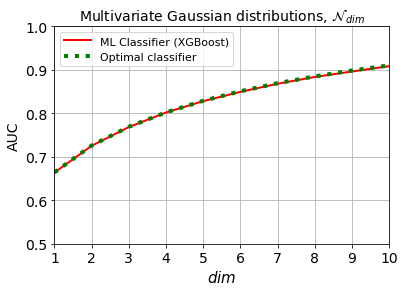

In [9]:
#########
# PLOTS #
#########

dim = [1,2,3,4,5,6,7,8,9,10]
    
plt.figure()
lw = 2

plt.plot(dim, store_AUC, '-', color='red', lw=lw, label=r'ML Classifier (XGBoost)')
plt.plot(dim, store_AUC_optimalNP, ':', color='green', lw=4.1, label=r'Optimal classifier')

plt.xlim([1, 10])
plt.ylim([0.5, 1.0])
#plt.xscale('log')
#plt.axes().set_aspect(0.7)
plt.xlabel('$dim$', fontsize=15)
plt.ylabel('AUC', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('Multivariate Gaussian distributions, $\mathcal{N}_{dim}$', fontsize=14)
plt.legend(loc="upper left", fontsize=11, handlelength=2.4)
plt.savefig('images/' + 'AUCgaussians.pdf', format="pdf", bbox_inches="tight")
plt.show()